In [ ]:
import xgboost as xgb
import json, logging
import numpy as np
import pandas as pd
import optuna
import joblib
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold
from optuna.visualization.matplotlib import plot_slice

In [ ]:
NOTEBOOK_NAME = "MIPLIB-XGBoost-Optimized"

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
RUN_DIR = Path("../results") / f"{timestamp}_{NOTEBOOK_NAME}"
SUBDIRS = ["model", "optuna", "metrics", "logs"]

for sd in SUBDIRS:
    (RUN_DIR / sd).mkdir(parents=True, exist_ok=True)

print(f"All outputs will be saved under: {RUN_DIR.resolve()}")

def save_model(model, name="xgb_runtime_model"):
    model_path = RUN_DIR / "model" / f"{name}.json"
    model.save_model(model_path)
    print(f"Model saved to {model_path}")


def save_optuna(study):
    joblib.dump(study, RUN_DIR / "optuna" / "study.pkl")
    trials_df = study.trials_dataframe()
    trials_df.to_csv(RUN_DIR / "optuna" / "trials.csv", index=False)
    with open(RUN_DIR / "optuna" / "best_params.json", "w") as f:
        json.dump(study.best_params, f, indent=2)
    print("Optuna study & best params stored")


def save_metrics(name: str, value):
    with open(RUN_DIR / "metrics" / f"{name}.json", "w") as f:
        json.dump(value, f, indent=2)

logfile = RUN_DIR / "logs" / "run.log"
logging.basicConfig(filename=logfile, filemode="w",
                    level=logging.INFO,
                    format="%(asctime)s %(levelname)s | %(message)s")
logging.info("Run directory initialised")

In [3]:
df_features = pd.read_csv('data/miplib_hutter_features.csv', header=0)
df_cplex_runtimes = pd.read_csv('/data/miplib_cplex_runtimes.csv')
df_cplex_runtimes["runtime_sec"] = pd.to_numeric(df_cplex_runtimes["runtime_sec"])
df_features.head()

,instance,probtype,n_vars,n_constr,n_nzcnt,nq_vars,nq_constr,nq_nzcnt,lp_avg,lp_l2_avg,...,cliqueCuts,impliedBoundCuts,flowCuts,mixedIntegerRoundingCuts,gomoryFractionalCuts,time_relax,time_VCG0,time_VCG1,time_VCG2,cplex_prob_time
0,30n20b8.mps.gz,1,18380.0,576,109706.0,0,0,0,0.451208,8.062840,...,0,0,0,0,0,0.47,0.01,0.00,0.01,4.21
1,2club200v15p5scn.mps.gz,1,200.0,17013,104811.0,0,0,0,0.310556,0.362519,...,0,0,0,0,0,0.30,0.01,0.00,0.02,9.10
2,8div-n59k10.mps.gz,1,6143.0,2065,539151.0,0,0,0,0.242108,9.867550,...,0,0,0,0,0,0.52,0.03,0.01,0.03,4.65
3,22433.mps.gz,1,429.0,198,3408.0,0,0,0,0.117360,0.200469,...,0,0,0,0,0,0.00,0.00,0.00,0.00,10.59
4,10teams.mps.gz,1,2025.0,230,12150.0,0,0,0,0.020263,0.081960,...,0,0,0,0,0,0.02,0.00,0.00,0.00,16.77


In [4]:
df_cplex_runtimes.head()

,instance,runtime_sec
0,a2864-99blp.mps.gz,3600.0
1,adult-regularized.mps.gz,3600.0
2,allcolor58.mps.gz,3600.0
3,assign1-10-4.mps.gz,3600.0
4,bab3.mps.gz,3600.0


In [5]:
df_combined = (
    df_features                         # left table
      .merge(                           # join
          df_cplex_runtimes[["instance", "runtime_sec"]],  # right table (only needed cols)
          on="instance",                # key column
          how="inner"                   # inner = intersection
      )
)
df_combined.head()

,instance,probtype,n_vars,n_constr,n_nzcnt,nq_vars,nq_constr,nq_nzcnt,lp_avg,lp_l2_avg,...,impliedBoundCuts,flowCuts,mixedIntegerRoundingCuts,gomoryFractionalCuts,time_relax,time_VCG0,time_VCG1,time_VCG2,cplex_prob_time,runtime_sec
0,30n20b8.mps.gz,1,18380.0,576,109706.0,0,0,0,0.451208,8.062840,...,0,0,0,0,0.47,0.01,0.00,0.01,4.21,2.13
1,2club200v15p5scn.mps.gz,1,200.0,17013,104811.0,0,0,0,0.310556,0.362519,...,0,0,0,0,0.30,0.01,0.00,0.02,9.10,3608.04
2,8div-n59k10.mps.gz,1,6143.0,2065,539151.0,0,0,0,0.242108,9.867550,...,0,0,0,0,0.52,0.03,0.01,0.03,4.65,3600.22
3,22433.mps.gz,1,429.0,198,3408.0,0,0,0,0.117360,0.200469,...,0,0,0,0,0.00,0.00,0.00,0.00,10.59,0.24
4,10teams.mps.gz,1,2025.0,230,12150.0,0,0,0,0.020263,0.081960,...,0,0,0,0,0.02,0.00,0.00,0.00,16.77,2.92


In [6]:
print(df_combined.shape)

(922, 150)


In [7]:
df_features = df_combined.drop(columns=["runtime_sec"])
df_cplex_runtimes = df_combined[["runtime_sec"]].copy()

df_features.set_index("instance", inplace=True)
df_cplex_runtimes.index = df_features.index

In [8]:
single_value_cols = df_features.columns[df_features.nunique(dropna=False) == 1]
single_value_cols

Index(['probtype', ' nq_vars', ' nq_constr', ' nq_nzcnt', ' num_s_variables',
       ' num_n_variables', ' ratio_s_variables', ' ratio_n_variables',
       ' itcnt_max', ' numnewsolution_sum', ' newin_sum', ' nodeleft_avg',
       ' nodeleft_varcoef', ' diffObj_avg', ' diffObj_median',
       ' diffObj_varcoef', ' diffObj_q90mq10', ' numfeas', ' iinf_avg',
       ' iinf_median', ' iinf_varcoef', ' iinf_q90mq10', ' diffBestInt_avg',
       ' diffBestInt_median', ' diffBestInt_varcoef', ' diffBestInt_q90mq10',
       ' diffBestObjUp_avg', ' diffBestObjUp_median', ' diffBestObjUp_varcoef',
       ' diffBestObjUp_q90mq10', ' numcuts_sum', ' diffGap_avg',
       ' diffGap_median', ' diffGap_varcoef', ' diffGap_q90mq10', ' pre_t',
       ' rel_t', ' new_row', ' new_col', ' new_nonzero', ' clique_table',
       ' cliqueCuts', ' impliedBoundCuts', ' flowCuts',
       ' mixedIntegerRoundingCuts', ' gomoryFractionalCuts'],
      dtype='object')

In [9]:
df_features.drop(single_value_cols, axis=1, inplace=True)
df_features

,n_vars,n_constr,n_nzcnt,lp_avg,lp_l2_avg,lp_linf,lp_objval,num_b_variables,num_i_variables,num_c_variables,...,obj_coef_per_sqr_constr2_std,mipgap,nodecnt,clqcnt,covcnt,time_relax,time_VCG0,time_VCG1,time_VCG2,cplex_prob_time
instance,,,,,,,,,,,,,,,,,,,,,
30n20b8.mps.gz,18380.0,576,109706.0,0.451208,8.062840,188.846000,0.390104,18318.0,62,0,...,0.056731,1.000000,0,0,0,0.47,0.01,0.00,0.01,4.21
2club200v15p5scn.mps.gz,200.0,17013,104811.0,0.310556,0.362519,0.500000,-121.222000,200.0,0,0,...,0.004690,0.765000,0,0,0,0.30,0.01,0.00,0.02,9.10
8div-n59k10.mps.gz,6143.0,2065,539151.0,0.242108,9.867550,708.000000,-709.000000,6138.0,5,0,...,0.006379,1.000000,0,0,0,0.52,0.03,0.01,0.03,4.65
22433.mps.gz,429.0,198,3408.0,0.117360,0.200469,0.466942,21240.500000,231.0,0,198,...,0.048224,0.000000,0,0,0,0.00,0.00,0.00,0.00,10.59
10teams.mps.gz,2025.0,230,12150.0,0.020263,0.081960,0.500000,917.000000,1800.0,0,225,...,6.408910,0.086580,0,5,0,0.02,0.00,0.00,0.00,16.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
z26.mps.gz,17937.0,850513,1715610.0,0.066037,0.165127,0.500000,-1651.940000,17937.0,0,0,...,0.114323,0.998272,0,0,0,4.49,0.62,0.09,0.65,7.73
8div-n59k12.mps.gz,24575.0,8211,8448020.0,0.251794,19.749700,2844.000000,-2845.000000,24570.0,5,0,...,0.003189,1.000000,0,0,0,37.19,0.42,0.04,0.42,5.89
bley_xl1.mps.gz,5831.0,175620,869391.0,0.056589,0.142278,0.500000,154.390000,5831.0,0,0,...,18.397400,0.000000,0,121,8,154.16,0.15,0.02,0.15,11.55


In [10]:
df_features.replace(-512, np.nan, inplace=True) # TODO: add these steps to pipeline
df_features

,n_vars,n_constr,n_nzcnt,lp_avg,lp_l2_avg,lp_linf,lp_objval,num_b_variables,num_i_variables,num_c_variables,...,obj_coef_per_sqr_constr2_std,mipgap,nodecnt,clqcnt,covcnt,time_relax,time_VCG0,time_VCG1,time_VCG2,cplex_prob_time
instance,,,,,,,,,,,,,,,,,,,,,
30n20b8.mps.gz,18380.0,576,109706.0,0.451208,8.062840,188.846000,0.390104,18318.0,62,0,...,0.056731,1.000000,0,0,0,0.47,0.01,0.00,0.01,4.21
2club200v15p5scn.mps.gz,200.0,17013,104811.0,0.310556,0.362519,0.500000,-121.222000,200.0,0,0,...,0.004690,0.765000,0,0,0,0.30,0.01,0.00,0.02,9.10
8div-n59k10.mps.gz,6143.0,2065,539151.0,0.242108,9.867550,708.000000,-709.000000,6138.0,5,0,...,0.006379,1.000000,0,0,0,0.52,0.03,0.01,0.03,4.65
22433.mps.gz,429.0,198,3408.0,0.117360,0.200469,0.466942,21240.500000,231.0,0,198,...,0.048224,0.000000,0,0,0,0.00,0.00,0.00,0.00,10.59
10teams.mps.gz,2025.0,230,12150.0,0.020263,0.081960,0.500000,917.000000,1800.0,0,225,...,6.408910,0.086580,0,5,0,0.02,0.00,0.00,0.00,16.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
z26.mps.gz,17937.0,850513,1715610.0,0.066037,0.165127,0.500000,-1651.940000,17937.0,0,0,...,0.114323,0.998272,0,0,0,4.49,0.62,0.09,0.65,7.73
8div-n59k12.mps.gz,24575.0,8211,8448020.0,0.251794,19.749700,2844.000000,-2845.000000,24570.0,5,0,...,0.003189,1.000000,0,0,0,37.19,0.42,0.04,0.42,5.89
bley_xl1.mps.gz,5831.0,175620,869391.0,0.056589,0.142278,0.500000,154.390000,5831.0,0,0,...,18.397400,0.000000,0,121,8,154.16,0.15,0.02,0.15,11.55


In [11]:
X = df_features
runtimes = df_cplex_runtimes['runtime_sec'].clip(lower=0.005)
y = np.log10(runtimes)

In [12]:
N_FOLDS   = 10
RANDOM_STATE    = 1234

xgb_params = dict(
    n_estimators   = 100,
    objective      = "reg:squarederror",
    tree_method    = "hist",
    eval_metric    = "rmse",
    random_state   = RANDOM_STATE
)

In [13]:
rmse_scorer = make_scorer(
        lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
        greater_is_better=False
    )

In [14]:
def corr_coeff(y_true, mu):
    """
    Pearson correlation between target and predicted mean.
    Equals Matlab’s ‘cc’.
    """
    return np.corrcoef(y_true, mu)[0, 1]

In [15]:
outer = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
rmse_outer = []
ccs_outer = []
best_overall_rmse = np.inf
best_study        = None          # will hold the Optuna study with the lowest fold RMSE
best_fold_idx     = None
best_params       = None

for fold, (train_idx, test_idx) in enumerate(outer.split(X), 1):
    print(f"Outer fold {fold}/10")
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    def objective(trial):
        num_round = trial.suggest_int("num_boost_round", 300, 1200, step=50)
        params = {
            "learning_rate":     trial.suggest_float("learning_rate", 0.02, 0.2, log=True),
            "max_depth":         trial.suggest_int("max_depth", 5, 10),
            "min_child_weight":  trial.suggest_float("min_child_weight", 1e-3, 1, log=True),
            "subsample":         trial.suggest_float("subsample", .5, .9),
            "colsample_bytree":  trial.suggest_float("colsample_bytree", .7, .9),
            "reg_alpha":         trial.suggest_float("reg_alpha", 1e-8, 1, log=True),
            "reg_lambda":        trial.suggest_float("reg_lambda", 1e-8, 1, log=True),
            # fixed:
            "objective":         "reg:squarederror",
            "tree_method":       "hist",
            "random_state":      RANDOM_STATE,
            "gamma":             0,
        }

        dtrain = xgb.DMatrix(X_tr, label=y_tr)

        cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round       = num_round,
        nfold           = 2,
        metrics         = "rmse",
        seed            = RANDOM_STATE,
        stratified      = False,
        shuffle         = True,
        early_stopping_rounds = 50,
        verbose_eval    = False,
        )
        best_rmse = cv_results["test-rmse-mean"].iloc[-1]
        return -best_rmse


    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
    study.optimize(objective, n_trials=40, show_progress_bar=True, n_jobs=-1)

    fold_params = study.best_params.copy()
    num_round   = fold_params.pop("num_boost_round")

    fold_params |= {
        "objective"   : "reg:squarederror",
        "tree_method" : "hist",
        "seed"        : RANDOM_STATE,
    }

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dtest  = xgb.DMatrix(X_te, label=y_te)

    booster = xgb.train(
        params            = fold_params,
        dtrain            = dtrain,
        num_boost_round   = num_round,
        evals             = [(dtrain, "train")],
        verbose_eval      = False,
    )

    preds = booster.predict(dtest)
    fold_rmse = np.sqrt(mean_squared_error(y_te, preds))
    rmse_outer.append(fold_rmse)
    ccs_outer.append(corr_coeff(y_te, preds))


    print(f"  RMSE = {fold_rmse:.4f}")

    if fold_rmse < best_overall_rmse:
        best_overall_rmse = fold_rmse
        best_study        = study
        best_fold_idx     = fold
        best_params       = fold_params | {"num_boost_round": num_round}

Outer fold 1/10


[I 2025-07-30 19:04:06,402] A new study created in memory with name: no-name-4c6ba42d-90ef-4061-a2e6-ceee4d406499
Best trial: 11. Best value: -1.05606:   2%|▎         | 1/40 [00:05<03:15,  5.01s/it]

[I 2025-07-30 19:04:11,413] Trial 11 finished with value: -1.0560607806169497 and parameters: {'num_boost_round': 700, 'learning_rate': 0.12684838815654345, 'max_depth': 6, 'min_child_weight': 0.6505807982353677, 'subsample': 0.7785931506052538, 'colsample_bytree': 0.7517108128536514, 'reg_alpha': 5.213862416128306e-07, 'reg_lambda': 0.023226792887260185}. Best is trial 11 with value: -1.0560607806169497.


Best trial: 4. Best value: -1.01332:   5%|▌         | 2/40 [00:07<02:16,  3.60s/it] 

[I 2025-07-30 19:04:14,034] Trial 4 finished with value: -1.0133236938966226 and parameters: {'num_boost_round': 400, 'learning_rate': 0.07184498935771874, 'max_depth': 5, 'min_child_weight': 0.033010255392625636, 'subsample': 0.5036864496718806, 'colsample_bytree': 0.8267291191021857, 'reg_alpha': 0.27373264572150696, 'reg_lambda': 0.581584256369517}. Best is trial 4 with value: -1.0133236938966226.
[I 2025-07-30 19:04:14,106] Trial 5 finished with value: -1.0487302646245231 and parameters: {'num_boost_round': 300, 'learning_rate': 0.09685869898084146, 'max_depth': 9, 'min_child_weight': 0.13640207874579996, 'subsample': 0.5075381384962421, 'colsample_bytree': 0.8322181631182743, 'reg_alpha': 2.081179317178684e-05, 'reg_lambda': 0.0002606370970929223}. Best is trial 4 with value: -1.0133236938966226.


Best trial: 4. Best value: -1.01332:  10%|█         | 4/40 [00:08<01:01,  1.72s/it]

[I 2025-07-30 19:04:15,218] Trial 7 finished with value: -1.0584757072176818 and parameters: {'num_boost_round': 850, 'learning_rate': 0.14657847341069355, 'max_depth': 9, 'min_child_weight': 0.031179168347424843, 'subsample': 0.8227567782796462, 'colsample_bytree': 0.8483470951720317, 'reg_alpha': 9.970826369403763e-07, 'reg_lambda': 1.7688732850173376e-07}. Best is trial 4 with value: -1.0133236938966226.


Best trial: 4. Best value: -1.01332:  15%|█▌        | 6/40 [00:09<00:31,  1.07it/s]

[I 2025-07-30 19:04:15,518] Trial 6 finished with value: -1.0475652636991228 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.1643318990637477, 'max_depth': 7, 'min_child_weight': 0.094524289848324, 'subsample': 0.5765073707654653, 'colsample_bytree': 0.878876242760781, 'reg_alpha': 0.0013378700245830644, 'reg_lambda': 1.2138689121360744e-07}. Best is trial 4 with value: -1.0133236938966226.
[I 2025-07-30 19:04:15,681] Trial 9 finished with value: -1.0168869781090635 and parameters: {'num_boost_round': 500, 'learning_rate': 0.06641975066233965, 'max_depth': 10, 'min_child_weight': 0.4675562549289368, 'subsample': 0.663795482340256, 'colsample_bytree': 0.7124325244443922, 'reg_alpha': 0.10551223730427198, 'reg_lambda': 4.897923680302238e-05}. Best is trial 4 with value: -1.0133236938966226.


Best trial: 0. Best value: -1.00187:  18%|█▊        | 7/40 [00:10<00:37,  1.13s/it]

[I 2025-07-30 19:04:17,235] Trial 0 finished with value: -1.0018745777322648 and parameters: {'num_boost_round': 900, 'learning_rate': 0.0320359941754201, 'max_depth': 7, 'min_child_weight': 0.005185211403886581, 'subsample': 0.6301921896055382, 'colsample_bytree': 0.7071093076770022, 'reg_alpha': 0.0025284595969796934, 'reg_lambda': 0.0007636691024332237}. Best is trial 0 with value: -1.0018745777322648.


Best trial: 0. Best value: -1.00187:  20%|██        | 8/40 [00:11<00:31,  1.00it/s]

[I 2025-07-30 19:04:17,943] Trial 1 finished with value: -1.0178091052108083 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.08998076514597218, 'max_depth': 8, 'min_child_weight': 0.310058426185605, 'subsample': 0.7116292164847412, 'colsample_bytree': 0.8909347082004687, 'reg_alpha': 4.6743707897964026e-05, 'reg_lambda': 6.295931501638555e-06}. Best is trial 0 with value: -1.0018745777322648.


Best trial: 0. Best value: -1.00187:  22%|██▎       | 9/40 [00:12<00:32,  1.06s/it]

[I 2025-07-30 19:04:19,150] Trial 13 finished with value: -1.0772628948500094 and parameters: {'num_boost_round': 850, 'learning_rate': 0.17778835883751967, 'max_depth': 9, 'min_child_weight': 0.011225265881973222, 'subsample': 0.6405757329267141, 'colsample_bytree': 0.8630245171741839, 'reg_alpha': 0.00040948110637273615, 'reg_lambda': 9.274855187319143e-08}. Best is trial 0 with value: -1.0018745777322648.


Best trial: 0. Best value: -1.00187:  25%|██▌       | 10/40 [00:13<00:25,  1.16it/s]

[I 2025-07-30 19:04:19,556] Trial 10 finished with value: -1.0233606914945819 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.08377730337257003, 'max_depth': 8, 'min_child_weight': 0.02057147955170059, 'subsample': 0.8115768825954286, 'colsample_bytree': 0.7215748172093716, 'reg_alpha': 1.1086794112844537e-05, 'reg_lambda': 0.0009673222838266294}. Best is trial 0 with value: -1.0018745777322648.


Best trial: 0. Best value: -1.00187:  28%|██▊       | 11/40 [00:13<00:20,  1.41it/s]

[I 2025-07-30 19:04:19,909] Trial 15 finished with value: -1.0285311377353017 and parameters: {'num_boost_round': 850, 'learning_rate': 0.15483031421365478, 'max_depth': 6, 'min_child_weight': 0.058500257520980425, 'subsample': 0.8088389956375192, 'colsample_bytree': 0.860678339485863, 'reg_alpha': 0.005053294464786872, 'reg_lambda': 0.00633865881182072}. Best is trial 0 with value: -1.0018745777322648.


Best trial: 0. Best value: -1.00187:  30%|███       | 12/40 [00:14<00:23,  1.18it/s]

[I 2025-07-30 19:04:21,067] Trial 16 finished with value: -1.050489911647039 and parameters: {'num_boost_round': 300, 'learning_rate': 0.11849097969642862, 'max_depth': 6, 'min_child_weight': 0.001743977684317063, 'subsample': 0.6247513237905241, 'colsample_bytree': 0.8048537298163941, 'reg_alpha': 7.70083752728806e-07, 'reg_lambda': 2.0329911086244017e-05}. Best is trial 0 with value: -1.0018745777322648.


Best trial: 0. Best value: -1.00187:  32%|███▎      | 13/40 [00:17<00:42,  1.59s/it]

[I 2025-07-30 19:04:24,388] Trial 19 finished with value: -1.0719146420784043 and parameters: {'num_boost_round': 500, 'learning_rate': 0.12283396458277138, 'max_depth': 8, 'min_child_weight': 0.01451227959450621, 'subsample': 0.5913837091717269, 'colsample_bytree': 0.733109067299252, 'reg_alpha': 0.00033136211988652364, 'reg_lambda': 0.002925453460871774}. Best is trial 0 with value: -1.0018745777322648.


Best trial: 0. Best value: -1.00187:  35%|███▌      | 14/40 [00:18<00:35,  1.36s/it]

[I 2025-07-30 19:04:25,203] Trial 20 finished with value: -1.0367972062350403 and parameters: {'num_boost_round': 350, 'learning_rate': 0.16072061355080391, 'max_depth': 8, 'min_child_weight': 0.002637007324483764, 'subsample': 0.6956515753590802, 'colsample_bytree': 0.8955546798968167, 'reg_alpha': 0.006019229344462154, 'reg_lambda': 0.0008671656592823242}. Best is trial 0 with value: -1.0018745777322648.


Best trial: 12. Best value: -0.991447:  38%|███▊      | 15/40 [00:19<00:29,  1.20s/it]

[I 2025-07-30 19:04:26,007] Trial 12 finished with value: -0.9914467250571017 and parameters: {'num_boost_round': 400, 'learning_rate': 0.029959087268056836, 'max_depth': 7, 'min_child_weight': 0.002947817219880522, 'subsample': 0.6833896017023958, 'colsample_bytree': 0.7442073938628437, 'reg_alpha': 4.4388998385999713e-07, 'reg_lambda': 0.1580075228500001}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  40%|████      | 16/40 [00:20<00:22,  1.05it/s]

[I 2025-07-30 19:04:26,421] Trial 2 finished with value: -0.9935799931978886 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.04090200974595113, 'max_depth': 10, 'min_child_weight': 0.0045995909761685095, 'subsample': 0.8171921853464823, 'colsample_bytree': 0.7417515491669348, 'reg_alpha': 1.3816115105935507e-07, 'reg_lambda': 0.6957715135847824}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  42%|████▎     | 17/40 [00:22<00:31,  1.36s/it]

[I 2025-07-30 19:04:28,734] Trial 17 finished with value: -1.0027231337156204 and parameters: {'num_boost_round': 850, 'learning_rate': 0.037746941628842366, 'max_depth': 5, 'min_child_weight': 0.010834506811919694, 'subsample': 0.6001867679930754, 'colsample_bytree': 0.7168474307968764, 'reg_alpha': 2.2264893234191077e-08, 'reg_lambda': 0.36709279026495134}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  45%|████▌     | 18/40 [00:23<00:31,  1.42s/it]

[I 2025-07-30 19:04:30,283] Trial 14 finished with value: -0.9945543312538058 and parameters: {'num_boost_round': 700, 'learning_rate': 0.025964270502946578, 'max_depth': 7, 'min_child_weight': 0.005541260015722256, 'subsample': 0.699402517328703, 'colsample_bytree': 0.747484794449156, 'reg_alpha': 1.4727317535870794e-07, 'reg_lambda': 0.0008400338320772245}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  48%|████▊     | 19/40 [00:24<00:26,  1.28s/it]

[I 2025-07-30 19:04:31,214] Trial 22 finished with value: -1.014398324822666 and parameters: {'num_boost_round': 550, 'learning_rate': 0.03382659586859597, 'max_depth': 5, 'min_child_weight': 0.0017814387095482678, 'subsample': 0.5604076412226366, 'colsample_bytree': 0.7909180173290712, 'reg_alpha': 0.696385046441059, 'reg_lambda': 0.8473407704239154}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  50%|█████     | 20/40 [00:25<00:20,  1.01s/it]

[I 2025-07-30 19:04:31,607] Trial 18 finished with value: -1.0067643867622846 and parameters: {'num_boost_round': 800, 'learning_rate': 0.03851373737501142, 'max_depth': 10, 'min_child_weight': 0.23706454514393902, 'subsample': 0.6115575010390477, 'colsample_bytree': 0.8433269647562164, 'reg_alpha': 0.011770264232116199, 'reg_lambda': 1.7833237360090299e-06}. Best is trial 12 with value: -0.9914467250571017.
[I 2025-07-30 19:04:31,637] Trial 21 finished with value: -1.0000104572185993 and parameters: {'num_boost_round': 650, 'learning_rate': 0.028781217553037208, 'max_depth': 6, 'min_child_weight': 0.0012869327074581617, 'subsample': 0.7389576992967163, 'colsample_bytree': 0.7753293203802015, 'reg_alpha': 1.2102135414009225e-08, 'reg_lambda': 0.01001031494001156}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  55%|█████▌    | 22/40 [00:25<00:11,  1.51it/s]

[I 2025-07-30 19:04:32,129] Trial 23 finished with value: -1.0068852253943323 and parameters: {'num_boost_round': 600, 'learning_rate': 0.03428845158789751, 'max_depth': 5, 'min_child_weight': 0.0033690866732168125, 'subsample': 0.5084361585152256, 'colsample_bytree': 0.7724836953531897, 'reg_alpha': 0.950192931380722, 'reg_lambda': 0.5249967464401396}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  57%|█████▊    | 23/40 [00:28<00:21,  1.25s/it]

[I 2025-07-30 19:04:35,154] Trial 3 finished with value: -0.9934893952077128 and parameters: {'num_boost_round': 900, 'learning_rate': 0.050616955441247, 'max_depth': 8, 'min_child_weight': 0.0046891350898893595, 'subsample': 0.7175324387875568, 'colsample_bytree': 0.7008052718272129, 'reg_alpha': 1.768945940384396e-05, 'reg_lambda': 6.523669817051672e-06}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  60%|██████    | 24/40 [00:30<00:21,  1.37s/it]

[I 2025-07-30 19:04:36,856] Trial 8 finished with value: -1.007767005517397 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.04407361979236467, 'max_depth': 10, 'min_child_weight': 0.5173704335296884, 'subsample': 0.5988217009953194, 'colsample_bytree': 0.7451400679717497, 'reg_alpha': 0.00022899739678879796, 'reg_lambda': 0.0012749181487312663}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  62%|██████▎   | 25/40 [00:32<00:22,  1.53s/it]

[I 2025-07-30 19:04:38,724] Trial 24 finished with value: -1.000229305904276 and parameters: {'num_boost_round': 650, 'learning_rate': 0.035144650611513596, 'max_depth': 5, 'min_child_weight': 0.0034457780669959748, 'subsample': 0.5010471180034023, 'colsample_bytree': 0.7715920963039866, 'reg_alpha': 0.9241742359196431, 'reg_lambda': 0.46307351226822285}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  65%|██████▌   | 26/40 [00:34<00:24,  1.73s/it]

[I 2025-07-30 19:04:41,077] Trial 26 finished with value: -0.9983781229205249 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.028113359006688068, 'max_depth': 7, 'min_child_weight': 0.006051869406818772, 'subsample': 0.7375947885459754, 'colsample_bytree': 0.7646507389926154, 'reg_alpha': 1.0210722044455457e-08, 'reg_lambda': 0.7181111626789581}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  68%|██████▊   | 27/40 [00:35<00:18,  1.40s/it]

[I 2025-07-30 19:04:41,643] Trial 25 finished with value: -1.0061859531945543 and parameters: {'num_boost_round': 600, 'learning_rate': 0.03203258122407285, 'max_depth': 5, 'min_child_weight': 0.005126875280030382, 'subsample': 0.5228528918972075, 'colsample_bytree': 0.7688159807156169, 'reg_alpha': 0.45105648864241116, 'reg_lambda': 0.6889284341823972}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  70%|███████   | 28/40 [00:40<00:29,  2.46s/it]

[I 2025-07-30 19:04:46,707] Trial 30 finished with value: -1.0272126108450395 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.04840859173728799, 'max_depth': 10, 'min_child_weight': 0.004970255145816555, 'subsample': 0.8959630936238312, 'colsample_bytree': 0.7751295180741495, 'reg_alpha': 1.158718486828604e-08, 'reg_lambda': 0.06070259558895287}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  72%|███████▎  | 29/40 [00:45<00:34,  3.13s/it]

[I 2025-07-30 19:04:51,462] Trial 32 finished with value: -1.004773767762188 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.022849706800313122, 'max_depth': 7, 'min_child_weight': 0.004927736407724359, 'subsample': 0.8877123227718147, 'colsample_bytree': 0.753984544023809, 'reg_alpha': 1.0012268095328414e-07, 'reg_lambda': 0.0596256287563125}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  75%|███████▌  | 30/40 [00:45<00:23,  2.37s/it]

[I 2025-07-30 19:04:52,029] Trial 27 finished with value: -0.9983360690970089 and parameters: {'num_boost_round': 650, 'learning_rate': 0.036811879396833336, 'max_depth': 10, 'min_child_weight': 0.001064078664705733, 'subsample': 0.8777626366278839, 'colsample_bytree': 0.7662022737900598, 'reg_alpha': 1.6233821306963467e-08, 'reg_lambda': 0.8512915990187201}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  78%|███████▊  | 31/40 [00:46<00:17,  1.93s/it]

[I 2025-07-30 19:04:52,886] Trial 29 finished with value: -1.0234812083486868 and parameters: {'num_boost_round': 600, 'learning_rate': 0.0465535161131953, 'max_depth': 10, 'min_child_weight': 0.001379677143510608, 'subsample': 0.893981693275177, 'colsample_bytree': 0.7836817777262499, 'reg_alpha': 1.463438106394587e-08, 'reg_lambda': 0.08748099179733171}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  80%|████████  | 32/40 [00:47<00:14,  1.75s/it]

[I 2025-07-30 19:04:54,235] Trial 33 finished with value: -1.001117960807142 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.02102645896650541, 'max_depth': 7, 'min_child_weight': 0.005252944763212203, 'subsample': 0.8613913880962213, 'colsample_bytree': 0.7422230416951506, 'reg_alpha': 9.826086611760905e-08, 'reg_lambda': 0.07446565355967015}. Best is trial 12 with value: -0.9914467250571017.
[I 2025-07-30 19:04:54,327] Trial 31 finished with value: -1.0106476558657114 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.04790527652220098, 'max_depth': 10, 'min_child_weight': 0.004663638658672625, 'subsample': 0.8694717517521172, 'colsample_bytree': 0.763626257676505, 'reg_alpha': 1.779852419645171e-08, 'reg_lambda': 0.06608443249681267}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  85%|████████▌ | 34/40 [00:48<00:06,  1.14s/it]

[I 2025-07-30 19:04:55,080] Trial 34 finished with value: -1.0168026213882895 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.04927065877035541, 'max_depth': 10, 'min_child_weight': 0.0067487752783109405, 'subsample': 0.8741683756899761, 'colsample_bytree': 0.7002319037395132, 'reg_alpha': 4.005823966285251e-06, 'reg_lambda': 0.05645640534993765}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  90%|█████████ | 36/40 [00:52<00:05,  1.30s/it]

[I 2025-07-30 19:04:58,499] Trial 36 finished with value: -1.0128552412768923 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.04857927865234967, 'max_depth': 9, 'min_child_weight': 0.005857730056505787, 'subsample': 0.8723070428469535, 'colsample_bytree': 0.702083950669542, 'reg_alpha': 4.334797467864721e-06, 'reg_lambda': 0.046632911752001606}. Best is trial 12 with value: -0.9914467250571017.
[I 2025-07-30 19:04:58,643] Trial 37 finished with value: -1.0274770503428305 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.047792635640231076, 'max_depth': 9, 'min_child_weight': 0.001178834835457852, 'subsample': 0.8980706453346939, 'colsample_bytree': 0.700700072485068, 'reg_alpha': 4.539179889094649e-06, 'reg_lambda': 0.07228516384914864}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  92%|█████████▎| 37/40 [00:55<00:05,  1.96s/it]

[I 2025-07-30 19:05:02,387] Trial 28 finished with value: -1.0175562721717428 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.021627652627316273, 'max_depth': 10, 'min_child_weight': 0.004340284048325361, 'subsample': 0.8983061005065366, 'colsample_bytree': 0.7612952678514527, 'reg_alpha': 1.2023943165395307e-08, 'reg_lambda': 0.04629944709873289}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447:  95%|█████████▌| 38/40 [00:56<00:03,  1.54s/it]

[I 2025-07-30 19:05:02,848] Trial 35 finished with value: -1.0138207047116332 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.020687532739758804, 'max_depth': 9, 'min_child_weight': 0.005803707097508549, 'subsample': 0.8909502161323093, 'colsample_bytree': 0.7025866162864592, 'reg_alpha': 2.6103308572289016e-06, 'reg_lambda': 0.10129208248918734}. Best is trial 12 with value: -0.9914467250571017.


Best trial: 12. Best value: -0.991447: 100%|██████████| 40/40 [00:58<00:00,  1.47s/it]


[I 2025-07-30 19:05:05,246] Trial 38 finished with value: -1.003834655157614 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.021666700169511232, 'max_depth': 9, 'min_child_weight': 0.0010538525297903085, 'subsample': 0.8826649005284769, 'colsample_bytree': 0.7390837249707297, 'reg_alpha': 4.185515826154697e-06, 'reg_lambda': 0.02329234985152807}. Best is trial 12 with value: -0.9914467250571017.
[I 2025-07-30 19:05:05,372] Trial 39 finished with value: -1.0101827496062212 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.022704959306931064, 'max_depth': 9, 'min_child_weight': 0.0010591301032515175, 'subsample': 0.8843348554171534, 'colsample_bytree': 0.7003403363023782, 'reg_alpha': 5.478308565162792e-06, 'reg_lambda': 0.09509518724487033}. Best is trial 12 with value: -0.9914467250571017.


[I 2025-07-30 19:05:06,727] A new study created in memory with name: no-name-4a895fe0-1e4b-4423-a27c-a88c207a9274


  RMSE = 1.0828
Outer fold 2/10


Best trial: 6. Best value: -1.05914:   2%|▎         | 1/40 [00:04<03:11,  4.91s/it]

[I 2025-07-30 19:05:11,634] Trial 6 finished with value: -1.0591381642920425 and parameters: {'num_boost_round': 850, 'learning_rate': 0.10995714767374488, 'max_depth': 5, 'min_child_weight': 0.003032593555460026, 'subsample': 0.888772516330545, 'colsample_bytree': 0.8740240205672646, 'reg_alpha': 1.7514722986064934e-08, 'reg_lambda': 0.0015192605860559572}. Best is trial 6 with value: -1.0591381642920425.


Best trial: 6. Best value: -1.05914:   5%|▌         | 2/40 [00:05<01:25,  2.25s/it]

[I 2025-07-30 19:05:11,979] Trial 7 finished with value: -1.0662574365283584 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.19229843881173003, 'max_depth': 8, 'min_child_weight': 0.020775088738167226, 'subsample': 0.8701324216297518, 'colsample_bytree': 0.8962598860408467, 'reg_alpha': 0.0013042492782400497, 'reg_lambda': 5.666605477452697e-05}. Best is trial 6 with value: -1.0591381642920425.
[I 2025-07-30 19:05:12,021] Trial 8 finished with value: -1.0718334247277452 and parameters: {'num_boost_round': 900, 'learning_rate': 0.14769579995010726, 'max_depth': 5, 'min_child_weight': 0.6603223902404044, 'subsample': 0.8146910087193635, 'colsample_bytree': 0.7575719204046296, 'reg_alpha': 5.0311328810837634e-05, 'reg_lambda': 0.014678415700194214}. Best is trial 6 with value: -1.0591381642920425.


Best trial: 9. Best value: -1.0321:  10%|█         | 4/40 [00:07<00:57,  1.58s/it] 

[I 2025-07-30 19:05:14,398] Trial 9 finished with value: -1.0320953687711787 and parameters: {'num_boost_round': 350, 'learning_rate': 0.0822310232615736, 'max_depth': 5, 'min_child_weight': 0.42276735870505805, 'subsample': 0.6736432898447651, 'colsample_bytree': 0.8391700020797461, 'reg_alpha': 0.0007163725472534177, 'reg_lambda': 0.00017976966371595248}. Best is trial 9 with value: -1.0320953687711787.
[I 2025-07-30 19:05:14,574] Trial 1 finished with value: -1.0678622330053997 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.14275894509426787, 'max_depth': 7, 'min_child_weight': 0.0013579636964533197, 'subsample': 0.7928043726416519, 'colsample_bytree': 0.8785235104201006, 'reg_alpha': 2.5023715991672957e-06, 'reg_lambda': 4.154766801766751e-08}. Best is trial 9 with value: -1.0320953687711787.


Best trial: 4. Best value: -1.01941:  15%|█▌        | 6/40 [00:11<01:00,  1.77s/it]

[I 2025-07-30 19:05:17,746] Trial 4 finished with value: -1.0194118827225847 and parameters: {'num_boost_round': 950, 'learning_rate': 0.047897410367102974, 'max_depth': 5, 'min_child_weight': 0.19140382071692214, 'subsample': 0.7194683752706492, 'colsample_bytree': 0.8582199201434116, 'reg_alpha': 0.0027509632565651696, 'reg_lambda': 7.342011517043922e-07}. Best is trial 4 with value: -1.0194118827225847.


Best trial: 4. Best value: -1.01941:  18%|█▊        | 7/40 [00:12<00:50,  1.53s/it]

[I 2025-07-30 19:05:18,669] Trial 3 finished with value: -1.023440180019151 and parameters: {'num_boost_round': 950, 'learning_rate': 0.050698481269715254, 'max_depth': 7, 'min_child_weight': 0.011780218645801711, 'subsample': 0.6692316947108805, 'colsample_bytree': 0.7303856422001406, 'reg_alpha': 6.983658519786293e-07, 'reg_lambda': 7.731248039624037e-07}. Best is trial 4 with value: -1.0194118827225847.


Best trial: 4. Best value: -1.01941:  20%|██        | 8/40 [00:14<00:53,  1.68s/it]

[I 2025-07-30 19:05:20,749] Trial 0 finished with value: -1.0308261010138335 and parameters: {'num_boost_round': 900, 'learning_rate': 0.045607134434898826, 'max_depth': 6, 'min_child_weight': 0.3709916573401587, 'subsample': 0.812644035430325, 'colsample_bytree': 0.7201411821372437, 'reg_alpha': 5.057279966193134e-05, 'reg_lambda': 0.006354133835197309}. Best is trial 4 with value: -1.0194118827225847.


Best trial: 4. Best value: -1.01941:  22%|██▎       | 9/40 [00:16<00:57,  1.85s/it]

[I 2025-07-30 19:05:22,997] Trial 5 finished with value: -1.046391643129665 and parameters: {'num_boost_round': 700, 'learning_rate': 0.037459758347689116, 'max_depth': 9, 'min_child_weight': 0.165042651311134, 'subsample': 0.8637301668575643, 'colsample_bytree': 0.8105674423700828, 'reg_alpha': 4.5444363183670897e-07, 'reg_lambda': 6.107046982484313e-07}. Best is trial 4 with value: -1.0194118827225847.


Best trial: 10. Best value: -1.01791:  25%|██▌       | 10/40 [00:17<00:52,  1.76s/it]

[I 2025-07-30 19:05:24,553] Trial 10 finished with value: -1.0179084267711422 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.06690715147741796, 'max_depth': 9, 'min_child_weight': 0.007519824571232091, 'subsample': 0.6970942725729474, 'colsample_bytree': 0.8029977948390709, 'reg_alpha': 4.330959308383831e-05, 'reg_lambda': 0.1313722392383551}. Best is trial 10 with value: -1.0179084267711422.


Best trial: 10. Best value: -1.01791:  28%|██▊       | 11/40 [00:18<00:40,  1.41s/it]

[I 2025-07-30 19:05:25,152] Trial 13 finished with value: -1.0377762168482811 and parameters: {'num_boost_round': 450, 'learning_rate': 0.04793726572068942, 'max_depth': 8, 'min_child_weight': 0.6214107355024646, 'subsample': 0.5749574064307093, 'colsample_bytree': 0.7504150144454375, 'reg_alpha': 0.002448756577442639, 'reg_lambda': 5.289463929049599e-05}. Best is trial 10 with value: -1.0179084267711422.


Best trial: 10. Best value: -1.01791:  30%|███       | 12/40 [00:19<00:35,  1.25s/it]

[I 2025-07-30 19:05:26,033] Trial 17 finished with value: -1.067691085697522 and parameters: {'num_boost_round': 650, 'learning_rate': 0.12157954165701763, 'max_depth': 7, 'min_child_weight': 0.007480948165870477, 'subsample': 0.8578431785786322, 'colsample_bytree': 0.8916528084466511, 'reg_alpha': 0.002488201987529686, 'reg_lambda': 0.10122041364820626}. Best is trial 10 with value: -1.0179084267711422.


Best trial: 10. Best value: -1.01791:  32%|███▎      | 13/40 [00:21<00:39,  1.47s/it]

[I 2025-07-30 19:05:28,017] Trial 11 finished with value: -1.0427171863488898 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.035252087305291877, 'max_depth': 7, 'min_child_weight': 0.003824355622371846, 'subsample': 0.7762270312010235, 'colsample_bytree': 0.7471512529398031, 'reg_alpha': 2.3320407965326106e-05, 'reg_lambda': 2.6259805942741236e-06}. Best is trial 10 with value: -1.0179084267711422.


Best trial: 10. Best value: -1.01791:  35%|███▌      | 14/40 [00:22<00:39,  1.54s/it]

[I 2025-07-30 19:05:29,705] Trial 18 finished with value: -1.0315955599704583 and parameters: {'num_boost_round': 500, 'learning_rate': 0.06495080792075138, 'max_depth': 9, 'min_child_weight': 0.1464305714252881, 'subsample': 0.6801996300697171, 'colsample_bytree': 0.7295439995821666, 'reg_alpha': 4.013951477267774e-05, 'reg_lambda': 9.006125715540711e-05}. Best is trial 10 with value: -1.0179084267711422.


Best trial: 10. Best value: -1.01791:  38%|███▊      | 15/40 [00:25<00:42,  1.71s/it]

[I 2025-07-30 19:05:31,821] Trial 15 finished with value: -1.0467308735180827 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.09191571894468599, 'max_depth': 10, 'min_child_weight': 0.730019033370994, 'subsample': 0.7907079970090162, 'colsample_bytree': 0.8313157732285467, 'reg_alpha': 0.0027721902498404243, 'reg_lambda': 0.19109817345681157}. Best is trial 10 with value: -1.0179084267711422.


Best trial: 10. Best value: -1.01791:  40%|████      | 16/40 [00:26<00:40,  1.69s/it]

[I 2025-07-30 19:05:33,455] Trial 12 finished with value: -1.0404451991129715 and parameters: {'num_boost_round': 500, 'learning_rate': 0.057425052879396414, 'max_depth': 8, 'min_child_weight': 0.9987616970446793, 'subsample': 0.8773838094099244, 'colsample_bytree': 0.7858327964095588, 'reg_alpha': 7.130341471361351e-05, 'reg_lambda': 7.906829043484123e-05}. Best is trial 10 with value: -1.0179084267711422.


Best trial: 10. Best value: -1.01791:  42%|████▎     | 17/40 [00:28<00:38,  1.66s/it]

[I 2025-07-30 19:05:35,057] Trial 2 finished with value: -1.0280349633877495 and parameters: {'num_boost_round': 450, 'learning_rate': 0.037045284238107046, 'max_depth': 8, 'min_child_weight': 0.0016661375210247867, 'subsample': 0.7679090131168591, 'colsample_bytree': 0.8906168921869329, 'reg_alpha': 0.48177947804824595, 'reg_lambda': 0.040345344378143674}. Best is trial 10 with value: -1.0179084267711422.


Best trial: 10. Best value: -1.01791:  45%|████▌     | 18/40 [00:38<01:35,  4.36s/it]

[I 2025-07-30 19:05:45,699] Trial 14 finished with value: -1.0365177636342464 and parameters: {'num_boost_round': 400, 'learning_rate': 0.02383386189626968, 'max_depth': 10, 'min_child_weight': 0.16143469635668917, 'subsample': 0.8393829154496685, 'colsample_bytree': 0.7936989230552229, 'reg_alpha': 0.0017852106993745693, 'reg_lambda': 0.0032332033259085437}. Best is trial 10 with value: -1.0179084267711422.


Best trial: 10. Best value: -1.01791:  48%|████▊     | 19/40 [00:44<01:40,  4.79s/it]

[I 2025-07-30 19:05:51,501] Trial 16 finished with value: -1.0431544935276456 and parameters: {'num_boost_round': 550, 'learning_rate': 0.023941841113601606, 'max_depth': 8, 'min_child_weight': 0.034182532527219436, 'subsample': 0.7835716866361636, 'colsample_bytree': 0.8782116250460547, 'reg_alpha': 1.9182277552157945e-06, 'reg_lambda': 4.675575435338566e-06}. Best is trial 10 with value: -1.0179084267711422.


Best trial: 10. Best value: -1.01791:  50%|█████     | 20/40 [00:45<01:12,  3.62s/it]

[I 2025-07-30 19:05:52,384] Trial 19 finished with value: -1.0280515663453897 and parameters: {'num_boost_round': 500, 'learning_rate': 0.024860692447413273, 'max_depth': 8, 'min_child_weight': 0.020697745089665195, 'subsample': 0.7297476894800331, 'colsample_bytree': 0.7482339742160938, 'reg_alpha': 0.0073058305122445846, 'reg_lambda': 0.0001118612837841297}. Best is trial 10 with value: -1.0179084267711422.


Best trial: 10. Best value: -1.01791:  52%|█████▎    | 21/40 [00:53<01:31,  4.83s/it]

[I 2025-07-30 19:06:00,054] Trial 31 finished with value: -1.039200976723132 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.07661589075783798, 'max_depth': 6, 'min_child_weight': 0.06028966292248589, 'subsample': 0.603624443545715, 'colsample_bytree': 0.8509722055067809, 'reg_alpha': 0.042119519256774075, 'reg_lambda': 1.2736104689707593e-08}. Best is trial 10 with value: -1.0179084267711422.


Best trial: 21. Best value: -1.0154:  55%|█████▌    | 22/40 [00:55<01:13,  4.10s/it] 

[I 2025-07-30 19:06:02,433] Trial 21 finished with value: -1.0154045631855404 and parameters: {'num_boost_round': 550, 'learning_rate': 0.0217813924423624, 'max_depth': 10, 'min_child_weight': 0.005880391277880372, 'subsample': 0.5289375901945174, 'colsample_bytree': 0.775273301345265, 'reg_alpha': 0.27555780272016767, 'reg_lambda': 0.2404028065759004}. Best is trial 21 with value: -1.0154045631855404.


Best trial: 21. Best value: -1.0154:  57%|█████▊    | 23/40 [00:58<01:01,  3.59s/it]

[I 2025-07-30 19:06:04,847] Trial 29 finished with value: -1.0299146160004011 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.02022515507183123, 'max_depth': 6, 'min_child_weight': 0.05121092867585489, 'subsample': 0.6141832502992407, 'colsample_bytree': 0.8501063661805749, 'reg_alpha': 0.06772208270882771, 'reg_lambda': 1.0871167362492541e-08}. Best is trial 21 with value: -1.0154045631855404.


Best trial: 21. Best value: -1.0154:  60%|██████    | 24/40 [00:58<00:42,  2.63s/it]

[I 2025-07-30 19:06:05,242] Trial 25 finished with value: -1.0178377579633113 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.0281955355835967, 'max_depth': 10, 'min_child_weight': 0.05493862566347292, 'subsample': 0.5909058629070635, 'colsample_bytree': 0.7983801782973796, 'reg_alpha': 0.31702300127633476, 'reg_lambda': 0.27109431477814205}. Best is trial 21 with value: -1.0154045631855404.


Best trial: 21. Best value: -1.0154:  62%|██████▎   | 25/40 [00:59<00:31,  2.10s/it]

[I 2025-07-30 19:06:06,090] Trial 24 finished with value: -1.0167857790975627 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.021373534577838183, 'max_depth': 10, 'min_child_weight': 0.1045004587510642, 'subsample': 0.6058475060107562, 'colsample_bytree': 0.7917702904295159, 'reg_alpha': 0.39078931013274887, 'reg_lambda': 0.550489682064598}. Best is trial 21 with value: -1.0154045631855404.


Best trial: 21. Best value: -1.0154:  68%|██████▊   | 27/40 [01:00<00:17,  1.35s/it]

[I 2025-07-30 19:06:07,459] Trial 32 finished with value: -1.0212148698879884 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.054483322073551686, 'max_depth': 6, 'min_child_weight': 0.009487337145309067, 'subsample': 0.625437988933291, 'colsample_bytree': 0.7003303691316747, 'reg_alpha': 2.9606463661440563e-08, 'reg_lambda': 2.6588457232205925e-07}. Best is trial 21 with value: -1.0154045631855404.
[I 2025-07-30 19:06:07,573] Trial 20 finished with value: -1.0349982502738624 and parameters: {'num_boost_round': 600, 'learning_rate': 0.02825552683783497, 'max_depth': 10, 'min_child_weight': 0.002342773423987997, 'subsample': 0.7672819780465941, 'colsample_bytree': 0.8201162814024202, 'reg_alpha': 2.5791179473400304e-06, 'reg_lambda': 1.6686190549145477e-06}. Best is trial 21 with value: -1.0154045631855404.


Best trial: 21. Best value: -1.0154:  70%|███████   | 28/40 [01:01<00:12,  1.08s/it]

[I 2025-07-30 19:06:08,012] Trial 27 finished with value: -1.0383897967674613 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.02351603165943719, 'max_depth': 10, 'min_child_weight': 0.06427676672369576, 'subsample': 0.604048861887027, 'colsample_bytree': 0.8494872892157829, 'reg_alpha': 0.10761783647665213, 'reg_lambda': 1.4547927887884912e-08}. Best is trial 21 with value: -1.0154045631855404.


Best trial: 21. Best value: -1.0154:  72%|███████▎  | 29/40 [01:03<00:15,  1.41s/it]

[I 2025-07-30 19:06:10,202] Trial 30 finished with value: -1.0414802670736276 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.07126794405967765, 'max_depth': 6, 'min_child_weight': 0.05703849919367472, 'subsample': 0.6151770385036179, 'colsample_bytree': 0.8403768818663684, 'reg_alpha': 0.06514709993170419, 'reg_lambda': 1.2973608691387766e-08}. Best is trial 21 with value: -1.0154045631855404.


Best trial: 21. Best value: -1.0154:  75%|███████▌  | 30/40 [01:04<00:11,  1.19s/it]

[I 2025-07-30 19:06:10,899] Trial 22 finished with value: -1.0197565656358525 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.02156911442106144, 'max_depth': 10, 'min_child_weight': 0.05772811230929712, 'subsample': 0.7266210556893424, 'colsample_bytree': 0.8003930344392769, 'reg_alpha': 0.17350730614989662, 'reg_lambda': 0.8480800641810456}. Best is trial 21 with value: -1.0154045631855404.


Best trial: 21. Best value: -1.0154:  78%|███████▊  | 31/40 [01:12<00:30,  3.39s/it]

[I 2025-07-30 19:06:19,396] Trial 28 finished with value: -1.0199276848315018 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.024192080088250217, 'max_depth': 10, 'min_child_weight': 0.07441262352677176, 'subsample': 0.6002385152566257, 'colsample_bytree': 0.8529426946835005, 'reg_alpha': 0.08365058542666401, 'reg_lambda': 0.8470951781058853}. Best is trial 21 with value: -1.0154045631855404.


Best trial: 21. Best value: -1.0154:  80%|████████  | 32/40 [01:14<00:22,  2.87s/it]

[I 2025-07-30 19:06:21,056] Trial 26 finished with value: -1.0200404563326635 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.020379180868132517, 'max_depth': 10, 'min_child_weight': 0.05622822603902771, 'subsample': 0.6033681752894385, 'colsample_bytree': 0.7855385000616162, 'reg_alpha': 0.2728276642367212, 'reg_lambda': 1.3290966130732275e-08}. Best is trial 21 with value: -1.0154045631855404.


Best trial: 33. Best value: -1.01121:  82%|████████▎ | 33/40 [01:18<00:23,  3.34s/it]

[I 2025-07-30 19:06:25,499] Trial 33 finished with value: -1.0112065522241696 and parameters: {'num_boost_round': 800, 'learning_rate': 0.02912527579411234, 'max_depth': 9, 'min_child_weight': 0.006724761052940251, 'subsample': 0.5022734418895205, 'colsample_bytree': 0.7746373037086103, 'reg_alpha': 0.2806320749883282, 'reg_lambda': 0.7307962856568683}. Best is trial 33 with value: -1.0112065522241696.


Best trial: 34. Best value: -1.00959:  85%|████████▌ | 34/40 [01:20<00:17,  2.84s/it]

[I 2025-07-30 19:06:27,172] Trial 34 finished with value: -1.0095858790428986 and parameters: {'num_boost_round': 800, 'learning_rate': 0.028507647626565467, 'max_depth': 9, 'min_child_weight': 0.0056503218409499545, 'subsample': 0.5009601844119136, 'colsample_bytree': 0.7806074203229807, 'reg_alpha': 0.5733945310560963, 'reg_lambda': 0.5879595455869131}. Best is trial 34 with value: -1.0095858790428986.


Best trial: 34. Best value: -1.00959:  88%|████████▊ | 35/40 [01:21<00:11,  2.29s/it]

[I 2025-07-30 19:06:28,178] Trial 38 finished with value: -1.0157264900288232 and parameters: {'num_boost_round': 800, 'learning_rate': 0.030770688029528294, 'max_depth': 10, 'min_child_weight': 0.08464305798979857, 'subsample': 0.5442785885564286, 'colsample_bytree': 0.7812204490850765, 'reg_alpha': 0.6699692330972083, 'reg_lambda': 0.9208878316313325}. Best is trial 34 with value: -1.0095858790428986.


Best trial: 34. Best value: -1.00959:  92%|█████████▎| 37/40 [01:21<00:03,  1.22s/it]

[I 2025-07-30 19:06:28,463] Trial 35 finished with value: -1.0134664104330686 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.029081416757974207, 'max_depth': 10, 'min_child_weight': 0.006205674811049932, 'subsample': 0.5000035933813058, 'colsample_bytree': 0.7733548623522977, 'reg_alpha': 0.5851365745906889, 'reg_lambda': 0.5137043158503725}. Best is trial 34 with value: -1.0095858790428986.
[I 2025-07-30 19:06:28,591] Trial 39 finished with value: -1.0176391706238788 and parameters: {'num_boost_round': 800, 'learning_rate': 0.029020807428467826, 'max_depth': 9, 'min_child_weight': 0.09468703656454756, 'subsample': 0.5024447129456492, 'colsample_bytree': 0.7730081577551644, 'reg_alpha': 0.7319886947963695, 'reg_lambda': 0.8312289021445015}. Best is trial 34 with value: -1.0095858790428986.


Best trial: 34. Best value: -1.00959:  98%|█████████▊| 39/40 [01:22<00:00,  1.46it/s]

[I 2025-07-30 19:06:28,844] Trial 36 finished with value: -1.018057613517764 and parameters: {'num_boost_round': 800, 'learning_rate': 0.03064142836443552, 'max_depth': 10, 'min_child_weight': 0.08824650299758124, 'subsample': 0.5091677073229066, 'colsample_bytree': 0.7704795143780535, 'reg_alpha': 0.7428063262121734, 'reg_lambda': 0.7264659894663332}. Best is trial 34 with value: -1.0095858790428986.
[I 2025-07-30 19:06:28,963] Trial 37 finished with value: -1.0201466055968218 and parameters: {'num_boost_round': 750, 'learning_rate': 0.029198493030316783, 'max_depth': 10, 'min_child_weight': 0.08097240650754958, 'subsample': 0.5100787282818353, 'colsample_bytree': 0.7740083388468244, 'reg_alpha': 0.8981837782428428, 'reg_lambda': 0.8616857352606884}. Best is trial 34 with value: -1.0095858790428986.


Best trial: 34. Best value: -1.00959: 100%|██████████| 40/40 [01:22<00:00,  2.06s/it]


[I 2025-07-30 19:06:29,215] Trial 23 finished with value: -1.026001482430133 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.020977977625115562, 'max_depth': 10, 'min_child_weight': 0.07450698217994083, 'subsample': 0.7314667212989753, 'colsample_bytree': 0.8053800788660922, 'reg_alpha': 0.509820516933426, 'reg_lambda': 3.173421935691722e-06}. Best is trial 34 with value: -1.0095858790428986.


[I 2025-07-30 19:06:32,611] A new study created in memory with name: no-name-fde70408-52c3-45af-8f31-662459115e24


  RMSE = 0.9111
Outer fold 3/10


Best trial: 4. Best value: -1.04369:   2%|▎         | 1/40 [00:04<02:44,  4.22s/it]

[I 2025-07-30 19:06:36,824] Trial 4 finished with value: -1.0436873934943482 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.14116440203071623, 'max_depth': 6, 'min_child_weight': 0.33825238435490756, 'subsample': 0.5629024237427488, 'colsample_bytree': 0.847168822125285, 'reg_alpha': 3.0305605673903022e-06, 'reg_lambda': 3.107215029087521e-06}. Best is trial 4 with value: -1.0436873934943482.


Best trial: 3. Best value: -1.01796:   5%|▌         | 2/40 [00:04<01:14,  1.97s/it]

[I 2025-07-30 19:06:37,207] Trial 9 finished with value: -1.046103359184951 and parameters: {'num_boost_round': 550, 'learning_rate': 0.17561419328153857, 'max_depth': 6, 'min_child_weight': 0.01536110986042075, 'subsample': 0.7683375705448997, 'colsample_bytree': 0.8557421130423514, 'reg_alpha': 0.002951411824082505, 'reg_lambda': 1.9167110547254823e-06}. Best is trial 4 with value: -1.0436873934943482.
[I 2025-07-30 19:06:37,279] Trial 3 finished with value: -1.0179566855119222 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.10864166856370878, 'max_depth': 5, 'min_child_weight': 0.0038036101045517885, 'subsample': 0.8853808691019064, 'colsample_bytree': 0.8686533461398576, 'reg_alpha': 0.01908060024003117, 'reg_lambda': 1.2752450425728734e-08}. Best is trial 3 with value: -1.0179566855119222.


Best trial: 3. Best value: -1.01796:  10%|█         | 4/40 [00:04<00:28,  1.25it/s]

[I 2025-07-30 19:06:37,423] Trial 7 finished with value: -1.0468419349217286 and parameters: {'num_boost_round': 650, 'learning_rate': 0.1993713275961295, 'max_depth': 7, 'min_child_weight': 0.0020594767162283754, 'subsample': 0.7524169753103093, 'colsample_bytree': 0.719576399024971, 'reg_alpha': 0.002073504412091153, 'reg_lambda': 2.6645384372782904e-05}. Best is trial 3 with value: -1.0179566855119222.


Best trial: 3. Best value: -1.01796:  12%|█▎        | 5/40 [00:06<00:38,  1.09s/it]

[I 2025-07-30 19:06:39,176] Trial 5 finished with value: -1.0290956867026582 and parameters: {'num_boost_round': 700, 'learning_rate': 0.099869893953148, 'max_depth': 8, 'min_child_weight': 0.0023756645831165446, 'subsample': 0.8960580385657562, 'colsample_bytree': 0.8981874958089775, 'reg_alpha': 0.0008208757986113477, 'reg_lambda': 3.0785276235263532e-06}. Best is trial 3 with value: -1.0179566855119222.


Best trial: 3. Best value: -1.01796:  15%|█▌        | 6/40 [00:07<00:35,  1.06s/it]

[I 2025-07-30 19:06:40,141] Trial 8 finished with value: -1.0275650916128876 and parameters: {'num_boost_round': 600, 'learning_rate': 0.10543763881072829, 'max_depth': 10, 'min_child_weight': 0.005162371024505517, 'subsample': 0.7856534672373786, 'colsample_bytree': 0.8635416394657878, 'reg_alpha': 3.446133589492371e-05, 'reg_lambda': 1.4401318755108213e-06}. Best is trial 3 with value: -1.0179566855119222.


Best trial: 6. Best value: -1.01472:  18%|█▊        | 7/40 [00:07<00:26,  1.24it/s]

[I 2025-07-30 19:06:40,379] Trial 6 finished with value: -1.014720894361043 and parameters: {'num_boost_round': 700, 'learning_rate': 0.102536563039863, 'max_depth': 9, 'min_child_weight': 0.013773205054809796, 'subsample': 0.5851785870992601, 'colsample_bytree': 0.7680188785021435, 'reg_alpha': 1.251692291050248e-07, 'reg_lambda': 0.003470895432747762}. Best is trial 6 with value: -1.014720894361043.


Best trial: 14. Best value: -1.01458:  20%|██        | 8/40 [00:09<00:39,  1.22s/it]

[I 2025-07-30 19:06:42,554] Trial 14 finished with value: -1.0145830704890244 and parameters: {'num_boost_round': 750, 'learning_rate': 0.09069383410518508, 'max_depth': 5, 'min_child_weight': 0.004063214816111911, 'subsample': 0.5200446510744161, 'colsample_bytree': 0.852515112013498, 'reg_alpha': 0.014341455555413846, 'reg_lambda': 6.680125040473674e-08}. Best is trial 14 with value: -1.0145830704890244.


Best trial: 10. Best value: -1.00661:  22%|██▎       | 9/40 [00:12<00:49,  1.61s/it]

[I 2025-07-30 19:06:45,051] Trial 10 finished with value: -1.0066079915689325 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.04121822967208874, 'max_depth': 8, 'min_child_weight': 0.6100106292824818, 'subsample': 0.6132807864590301, 'colsample_bytree': 0.8678520158210833, 'reg_alpha': 0.03311648351432909, 'reg_lambda': 4.307899394633001e-08}. Best is trial 10 with value: -1.0066079915689325.


Best trial: 11. Best value: -0.993501:  25%|██▌       | 10/40 [00:12<00:37,  1.27s/it]

[I 2025-07-30 19:06:45,528] Trial 11 finished with value: -0.9935012978728499 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.045150133673545506, 'max_depth': 5, 'min_child_weight': 0.14674959331845913, 'subsample': 0.5889763702409337, 'colsample_bytree': 0.8381869721042156, 'reg_alpha': 2.8509887750136614e-05, 'reg_lambda': 0.012502438565541759}. Best is trial 11 with value: -0.9935012978728499.


Best trial: 11. Best value: -0.993501:  28%|██▊       | 11/40 [00:13<00:32,  1.11s/it]

[I 2025-07-30 19:06:46,251] Trial 17 finished with value: -1.044475462497601 and parameters: {'num_boost_round': 500, 'learning_rate': 0.15162989565046425, 'max_depth': 7, 'min_child_weight': 0.0017505416581785138, 'subsample': 0.6272223503308598, 'colsample_bytree': 0.80948889049031, 'reg_alpha': 0.02707348184484172, 'reg_lambda': 0.00011081674728848659}. Best is trial 11 with value: -0.9935012978728499.


Best trial: 11. Best value: -0.993501:  30%|███       | 12/40 [00:15<00:33,  1.20s/it]

[I 2025-07-30 19:06:47,703] Trial 16 finished with value: -1.03211497526071 and parameters: {'num_boost_round': 350, 'learning_rate': 0.08686240881101226, 'max_depth': 6, 'min_child_weight': 0.09009615965403807, 'subsample': 0.6050745785399643, 'colsample_bytree': 0.730389960514701, 'reg_alpha': 0.0798791442317114, 'reg_lambda': 1.3917032586067576e-05}. Best is trial 11 with value: -0.9935012978728499.
[I 2025-07-30 19:06:47,727] Trial 12 finished with value: -1.0093631926282856 and parameters: {'num_boost_round': 300, 'learning_rate': 0.04560731928235499, 'max_depth': 8, 'min_child_weight': 0.5386560682778042, 'subsample': 0.597112385162734, 'colsample_bytree': 0.8505012989874884, 'reg_alpha': 3.150032200812044e-06, 'reg_lambda': 0.0064316117729330815}. Best is trial 11 with value: -0.9935012978728499.


Best trial: 18. Best value: -0.988784:  35%|███▌      | 14/40 [00:15<00:19,  1.32it/s]

[I 2025-07-30 19:06:48,177] Trial 18 finished with value: -0.9887837331770783 and parameters: {'num_boost_round': 600, 'learning_rate': 0.06837497714128239, 'max_depth': 7, 'min_child_weight': 0.09084697461440477, 'subsample': 0.6071195496650763, 'colsample_bytree': 0.8822624465003445, 'reg_alpha': 7.186008100591853e-05, 'reg_lambda': 0.688974475366861}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  38%|███▊      | 15/40 [00:18<00:30,  1.20s/it]

[I 2025-07-30 19:06:50,725] Trial 13 finished with value: -1.0106030111261681 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.04634964581708791, 'max_depth': 8, 'min_child_weight': 0.06247434283289461, 'subsample': 0.6406062764068445, 'colsample_bytree': 0.7699640440707213, 'reg_alpha': 4.035104543830481e-08, 'reg_lambda': 0.01833496028922033}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  40%|████      | 16/40 [00:19<00:30,  1.27s/it]

[I 2025-07-30 19:06:52,194] Trial 1 finished with value: -0.9920331249267139 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.024119252609634084, 'max_depth': 6, 'min_child_weight': 0.09040690812581222, 'subsample': 0.5207940279503316, 'colsample_bytree': 0.817630076790007, 'reg_alpha': 1.5726698620687028e-07, 'reg_lambda': 1.6270079489523473e-08}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  42%|████▎     | 17/40 [00:21<00:30,  1.35s/it]

[I 2025-07-30 19:06:53,741] Trial 20 finished with value: -1.0110744560933294 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.042601314283729035, 'max_depth': 5, 'min_child_weight': 0.020743998172066274, 'subsample': 0.8384209666507929, 'colsample_bytree': 0.7002257883249827, 'reg_alpha': 0.0012537454590358132, 'reg_lambda': 3.236918541766492e-07}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  45%|████▌     | 18/40 [00:23<00:38,  1.76s/it]

[I 2025-07-30 19:06:56,577] Trial 15 finished with value: -1.0126298563761122 and parameters: {'num_boost_round': 900, 'learning_rate': 0.03663639631007086, 'max_depth': 6, 'min_child_weight': 0.16703397126289418, 'subsample': 0.7322041185699808, 'colsample_bytree': 0.7742818623204141, 'reg_alpha': 0.00010837212570838786, 'reg_lambda': 1.3901000981474286e-06}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  48%|████▊     | 19/40 [00:26<00:39,  1.89s/it]

[I 2025-07-30 19:06:58,766] Trial 19 finished with value: -0.9963435861612888 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.06317417387954577, 'max_depth': 5, 'min_child_weight': 0.33733002358506275, 'subsample': 0.5764958156172975, 'colsample_bytree': 0.8624334606137994, 'reg_alpha': 0.37931943956378333, 'reg_lambda': 6.025719752636484e-05}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  50%|█████     | 20/40 [00:27<00:37,  1.85s/it]

[I 2025-07-30 19:07:00,540] Trial 21 finished with value: -1.0000196409819306 and parameters: {'num_boost_round': 300, 'learning_rate': 0.024841375019282314, 'max_depth': 6, 'min_child_weight': 0.13340056745593315, 'subsample': 0.6581045628345059, 'colsample_bytree': 0.8069310031798017, 'reg_alpha': 1.0135684372384424e-08, 'reg_lambda': 0.9756467792427932}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  52%|█████▎    | 21/40 [00:32<00:48,  2.57s/it]

[I 2025-07-30 19:07:04,838] Trial 22 finished with value: -1.0044195879632776 and parameters: {'num_boost_round': 950, 'learning_rate': 0.02982227603857473, 'max_depth': 8, 'min_child_weight': 0.394634756693999, 'subsample': 0.6545248006891092, 'colsample_bytree': 0.8116756174900013, 'reg_alpha': 1.6559861902623896e-05, 'reg_lambda': 0.5286479958866384}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  55%|█████▌    | 22/40 [00:33<00:39,  2.20s/it]

[I 2025-07-30 19:07:06,144] Trial 0 finished with value: -1.015008910535225 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.033556422028407695, 'max_depth': 8, 'min_child_weight': 0.012324596767683082, 'subsample': 0.6642611468659388, 'colsample_bytree': 0.818310196901054, 'reg_alpha': 0.005211075064519917, 'reg_lambda': 0.0002173201835365277}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  57%|█████▊    | 23/40 [00:34<00:31,  1.83s/it]

[I 2025-07-30 19:07:07,120] Trial 23 finished with value: -1.0082740868435933 and parameters: {'num_boost_round': 950, 'learning_rate': 0.0349245299437858, 'max_depth': 8, 'min_child_weight': 0.9769523654800912, 'subsample': 0.6603581477022641, 'colsample_bytree': 0.8094958852132709, 'reg_alpha': 0.8349072920932447, 'reg_lambda': 0.7847321306406803}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  60%|██████    | 24/40 [00:39<00:44,  2.80s/it]

[I 2025-07-30 19:07:12,220] Trial 25 finished with value: -0.9962035353307106 and parameters: {'num_boost_round': 850, 'learning_rate': 0.02196868969427234, 'max_depth': 5, 'min_child_weight': 0.08511739084599261, 'subsample': 0.6634185101114292, 'colsample_bytree': 0.8133737088114893, 'reg_alpha': 8.072631619757905e-05, 'reg_lambda': 0.8342451703918102}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  62%|██████▎   | 25/40 [00:42<00:42,  2.80s/it]

[I 2025-07-30 19:07:15,012] Trial 33 finished with value: -1.0064059722260668 and parameters: {'num_boost_round': 850, 'learning_rate': 0.06067388681533536, 'max_depth': 7, 'min_child_weight': 0.0360912986814509, 'subsample': 0.517341866981844, 'colsample_bytree': 0.8901323761975344, 'reg_alpha': 4.23522346857374e-07, 'reg_lambda': 0.13188844400272293}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  65%|██████▌   | 26/40 [00:43<00:30,  2.15s/it]

[I 2025-07-30 19:07:15,636] Trial 26 finished with value: -1.0001296065683671 and parameters: {'num_boost_round': 900, 'learning_rate': 0.02181297051625565, 'max_depth': 5, 'min_child_weight': 0.12177031938858794, 'subsample': 0.6842614343227407, 'colsample_bytree': 0.8060869792007708, 'reg_alpha': 6.638937435356241e-05, 'reg_lambda': 0.950099331326348}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  68%|██████▊   | 27/40 [00:48<00:40,  3.11s/it]

[I 2025-07-30 19:07:20,985] Trial 31 finished with value: -0.9958378060390507 and parameters: {'num_boost_round': 900, 'learning_rate': 0.02358871628809773, 'max_depth': 7, 'min_child_weight': 0.05821008008162974, 'subsample': 0.515731685008454, 'colsample_bytree': 0.8889833800043824, 'reg_alpha': 4.45097322478414e-07, 'reg_lambda': 0.0005079289072457248}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  70%|███████   | 28/40 [00:48<00:28,  2.34s/it]

[I 2025-07-30 19:07:21,544] Trial 27 finished with value: -0.9996642767948805 and parameters: {'num_boost_round': 900, 'learning_rate': 0.024088712821057682, 'max_depth': 7, 'min_child_weight': 0.03196954575249748, 'subsample': 0.525925903140106, 'colsample_bytree': 0.8136759695717128, 'reg_alpha': 1.3283023844280932e-08, 'reg_lambda': 0.9801633413108254}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  72%|███████▎  | 29/40 [00:49<00:19,  1.78s/it]

[I 2025-07-30 19:07:22,001] Trial 36 finished with value: -1.0151618738409753 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.07236311835429698, 'max_depth': 7, 'min_child_weight': 0.04187040111748147, 'subsample': 0.5532150388049679, 'colsample_bytree': 0.8362834638688574, 'reg_alpha': 3.217904387633365e-06, 'reg_lambda': 0.057096890961951245}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  75%|███████▌  | 30/40 [00:52<00:20,  2.06s/it]

[I 2025-07-30 19:07:24,688] Trial 35 finished with value: -1.00701680149708 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.060058266919144475, 'max_depth': 7, 'min_child_weight': 0.045251410748084114, 'subsample': 0.5039368508448466, 'colsample_bytree': 0.8949710326794548, 'reg_alpha': 6.154134666707446e-07, 'reg_lambda': 0.06461421585775967}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  78%|███████▊  | 31/40 [00:52<00:14,  1.60s/it]

[I 2025-07-30 19:07:25,249] Trial 2 finished with value: -1.0053374598848053 and parameters: {'num_boost_round': 850, 'learning_rate': 0.0203605856932527, 'max_depth': 8, 'min_child_weight': 0.03234282556987676, 'subsample': 0.7916396435397145, 'colsample_bytree': 0.7283579347589013, 'reg_alpha': 3.24745721350769e-07, 'reg_lambda': 0.012764527231227245}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  80%|████████  | 32/40 [00:54<00:12,  1.60s/it]

[I 2025-07-30 19:07:26,836] Trial 28 finished with value: -0.9935280259447206 and parameters: {'num_boost_round': 900, 'learning_rate': 0.022839975084674398, 'max_depth': 7, 'min_child_weight': 0.20652337594452075, 'subsample': 0.5063594961318171, 'colsample_bytree': 0.8996083508520155, 'reg_alpha': 0.9701184609150387, 'reg_lambda': 0.4144717795159585}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  82%|████████▎ | 33/40 [00:54<00:08,  1.28s/it]

[I 2025-07-30 19:07:27,396] Trial 24 finished with value: -0.9982314691599401 and parameters: {'num_boost_round': 950, 'learning_rate': 0.021276576479412317, 'max_depth': 9, 'min_child_weight': 0.14746803968622252, 'subsample': 0.6781707791896945, 'colsample_bytree': 0.8151212957099292, 'reg_alpha': 0.9774636783603536, 'reg_lambda': 0.23834739173687927}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  85%|████████▌ | 34/40 [00:55<00:07,  1.25s/it]

[I 2025-07-30 19:07:28,567] Trial 39 finished with value: -0.9917302594565884 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.05363151958709989, 'max_depth': 6, 'min_child_weight': 0.20873344647940015, 'subsample': 0.5500968426881967, 'colsample_bytree': 0.8318361595232246, 'reg_alpha': 0.0003023275637720721, 'reg_lambda': 0.0658602506459733}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  88%|████████▊ | 35/40 [00:57<00:06,  1.31s/it]

[I 2025-07-30 19:07:30,001] Trial 37 finished with value: -1.0000696277674312 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.05441358620454148, 'max_depth': 7, 'min_child_weight': 0.04561114931812498, 'subsample': 0.5410451940127011, 'colsample_bytree': 0.8331828090848727, 'reg_alpha': 5.415100173103151e-06, 'reg_lambda': 0.0006342968514519621}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  90%|█████████ | 36/40 [00:57<00:03,  1.01it/s]

[I 2025-07-30 19:07:30,261] Trial 38 finished with value: -0.99447607394138 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.05445753038238607, 'max_depth': 6, 'min_child_weight': 0.18573483996777576, 'subsample': 0.5425888901138592, 'colsample_bytree': 0.8370761743809461, 'reg_alpha': 0.00041823831593376047, 'reg_lambda': 0.12288174021541066}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  92%|█████████▎| 37/40 [00:58<00:02,  1.23it/s]

[I 2025-07-30 19:07:30,657] Trial 30 finished with value: -0.9910439079228097 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.021904633920857546, 'max_depth': 7, 'min_child_weight': 0.03522821370870178, 'subsample': 0.5125984995014267, 'colsample_bytree': 0.8162080845895616, 'reg_alpha': 4.96716895563545e-07, 'reg_lambda': 0.440053858395605}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784:  98%|█████████▊| 39/40 [00:59<00:00,  1.43it/s]

[I 2025-07-30 19:07:31,899] Trial 32 finished with value: -0.9938048014483869 and parameters: {'num_boost_round': 850, 'learning_rate': 0.020539666861801576, 'max_depth': 7, 'min_child_weight': 0.04134220051399062, 'subsample': 0.508063351809838, 'colsample_bytree': 0.8985874175563093, 'reg_alpha': 6.106203473581106e-07, 'reg_lambda': 0.0823118200306355}. Best is trial 18 with value: -0.9887837331770783.
[I 2025-07-30 19:07:32,034] Trial 34 finished with value: -0.9976083611944053 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.02019205053659734, 'max_depth': 7, 'min_child_weight': 0.040989208695997155, 'subsample': 0.5106791788870602, 'colsample_bytree': 0.8943878810393853, 'reg_alpha': 3.346080307664729e-07, 'reg_lambda': 0.06369882529128462}. Best is trial 18 with value: -0.9887837331770783.


Best trial: 18. Best value: -0.988784: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


[I 2025-07-30 19:07:32,446] Trial 29 finished with value: -0.9909707271121264 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.021408499264490212, 'max_depth': 7, 'min_child_weight': 0.037799245091032364, 'subsample': 0.5060362684397547, 'colsample_bytree': 0.8162947635414184, 'reg_alpha': 0.5613460933805664, 'reg_lambda': 0.9332880515400906}. Best is trial 18 with value: -0.9887837331770783.


[I 2025-07-30 19:07:34,519] A new study created in memory with name: no-name-cc97b25f-36ea-44b9-9f06-795284ad06d9


  RMSE = 1.0122
Outer fold 4/10


Best trial: 11. Best value: -1.05546:   2%|▎         | 1/40 [00:04<03:12,  4.93s/it]

[I 2025-07-30 19:07:39,431] Trial 11 finished with value: -1.0554595195112724 and parameters: {'num_boost_round': 900, 'learning_rate': 0.10460916114194758, 'max_depth': 5, 'min_child_weight': 0.7880207306548477, 'subsample': 0.8292814251939546, 'colsample_bytree': 0.8867469106821497, 'reg_alpha': 7.766882359032117e-06, 'reg_lambda': 2.9757667864706383e-08}. Best is trial 11 with value: -1.0554595195112724.


Best trial: 11. Best value: -1.05546:   5%|▌         | 2/40 [00:05<01:28,  2.32s/it]

[I 2025-07-30 19:07:39,946] Trial 3 finished with value: -1.0746899889295718 and parameters: {'num_boost_round': 900, 'learning_rate': 0.10907533898424986, 'max_depth': 6, 'min_child_weight': 0.0034293827038192775, 'subsample': 0.7608483067011276, 'colsample_bytree': 0.7685204312145377, 'reg_alpha': 1.286445891034776e-08, 'reg_lambda': 1.2844965930865224e-07}. Best is trial 11 with value: -1.0554595195112724.


Best trial: 5. Best value: -1.03507:   8%|▊         | 3/40 [00:07<01:20,  2.16s/it] 

[I 2025-07-30 19:07:41,916] Trial 5 finished with value: -1.035067981619935 and parameters: {'num_boost_round': 950, 'learning_rate': 0.042118194054313836, 'max_depth': 6, 'min_child_weight': 0.0033232426739161188, 'subsample': 0.6003775309472975, 'colsample_bytree': 0.7787863518103509, 'reg_alpha': 0.0005057664799146884, 'reg_lambda': 7.333882252074792e-06}. Best is trial 5 with value: -1.035067981619935.


Best trial: 5. Best value: -1.03507:  10%|█         | 4/40 [00:07<00:50,  1.41s/it]

[I 2025-07-30 19:07:42,157] Trial 6 finished with value: -1.096464506102342 and parameters: {'num_boost_round': 700, 'learning_rate': 0.1586996398195479, 'max_depth': 7, 'min_child_weight': 0.0031790414975595236, 'subsample': 0.724171461662758, 'colsample_bytree': 0.7629789543410141, 'reg_alpha': 0.19287805336186034, 'reg_lambda': 5.627987226205692e-07}. Best is trial 5 with value: -1.035067981619935.


Best trial: 5. Best value: -1.03507:  12%|█▎        | 5/40 [00:08<00:36,  1.05s/it]

[I 2025-07-30 19:07:42,583] Trial 2 finished with value: -1.0401451244699005 and parameters: {'num_boost_round': 400, 'learning_rate': 0.08960521229920762, 'max_depth': 8, 'min_child_weight': 0.0046765045774776175, 'subsample': 0.8148020332777958, 'colsample_bytree': 0.8047445005246328, 'reg_alpha': 1.686239312307037e-05, 'reg_lambda': 0.05673259361701014}. Best is trial 5 with value: -1.035067981619935.


Best trial: 5. Best value: -1.03507:  15%|█▌        | 6/40 [00:09<00:35,  1.04s/it]

[I 2025-07-30 19:07:43,602] Trial 4 finished with value: -1.0475157182049741 and parameters: {'num_boost_round': 900, 'learning_rate': 0.08645902475062073, 'max_depth': 7, 'min_child_weight': 0.019648452078065287, 'subsample': 0.5988090554977844, 'colsample_bytree': 0.8309300872489045, 'reg_alpha': 0.0011979391410424465, 'reg_lambda': 0.46290008326041454}. Best is trial 5 with value: -1.035067981619935.


Best trial: 5. Best value: -1.03507:  18%|█▊        | 7/40 [00:09<00:30,  1.08it/s]

[I 2025-07-30 19:07:44,279] Trial 13 finished with value: -1.0724951061730685 and parameters: {'num_boost_round': 550, 'learning_rate': 0.16203626586769485, 'max_depth': 5, 'min_child_weight': 0.032065283122703, 'subsample': 0.7905351862627426, 'colsample_bytree': 0.7508626892724178, 'reg_alpha': 4.5236755707461315e-06, 'reg_lambda': 6.208767658927468e-08}. Best is trial 5 with value: -1.035067981619935.


Best trial: 5. Best value: -1.03507:  20%|██        | 8/40 [00:10<00:29,  1.08it/s]

[I 2025-07-30 19:07:45,224] Trial 7 finished with value: -1.0940246508807823 and parameters: {'num_boost_round': 300, 'learning_rate': 0.13856439444091456, 'max_depth': 8, 'min_child_weight': 0.01668625186621982, 'subsample': 0.5527448440758702, 'colsample_bytree': 0.7686731206423961, 'reg_alpha': 7.603101268886364e-07, 'reg_lambda': 0.8676688342767014}. Best is trial 5 with value: -1.035067981619935.


Best trial: 5. Best value: -1.03507:  22%|██▎       | 9/40 [00:12<00:38,  1.25s/it]

[I 2025-07-30 19:07:47,191] Trial 12 finished with value: -1.0680749619889625 and parameters: {'num_boost_round': 650, 'learning_rate': 0.08683302932007098, 'max_depth': 7, 'min_child_weight': 0.43655950411427347, 'subsample': 0.6340427762142802, 'colsample_bytree': 0.8392821925128869, 'reg_alpha': 1.3000603022853896e-05, 'reg_lambda': 0.0002006610733393435}. Best is trial 5 with value: -1.035067981619935.


Best trial: 5. Best value: -1.03507:  25%|██▌       | 10/40 [00:13<00:29,  1.03it/s]

[I 2025-07-30 19:07:47,538] Trial 16 finished with value: -1.08649195442727 and parameters: {'num_boost_round': 950, 'learning_rate': 0.16086655623629603, 'max_depth': 8, 'min_child_weight': 0.24078714380534322, 'subsample': 0.5494348780143578, 'colsample_bytree': 0.8416739094718628, 'reg_alpha': 1.3179643570580787e-07, 'reg_lambda': 1.0952061155896143e-07}. Best is trial 5 with value: -1.035067981619935.


Best trial: 5. Best value: -1.03507:  28%|██▊       | 11/40 [00:13<00:25,  1.14it/s]

[I 2025-07-30 19:07:48,184] Trial 19 finished with value: -1.1075249288434907 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.1695496613096121, 'max_depth': 5, 'min_child_weight': 0.01526186402492062, 'subsample': 0.6002642589762394, 'colsample_bytree': 0.8675579383724985, 'reg_alpha': 4.295831683155466e-06, 'reg_lambda': 1.1525586543495631e-05}. Best is trial 5 with value: -1.035067981619935.


Best trial: 5. Best value: -1.03507:  30%|███       | 12/40 [00:14<00:24,  1.13it/s]

[I 2025-07-30 19:07:49,096] Trial 18 finished with value: -1.0810401903786016 and parameters: {'num_boost_round': 900, 'learning_rate': 0.1890018098251573, 'max_depth': 6, 'min_child_weight': 0.038282366567249294, 'subsample': 0.889371015249069, 'colsample_bytree': 0.7863294748850783, 'reg_alpha': 0.0010023230669766328, 'reg_lambda': 3.6433841821396945e-06}. Best is trial 5 with value: -1.035067981619935.


Best trial: 5. Best value: -1.03507:  32%|███▎      | 13/40 [00:15<00:21,  1.23it/s]

[I 2025-07-30 19:07:49,702] Trial 14 finished with value: -1.0478975471503862 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.06274319972705694, 'max_depth': 6, 'min_child_weight': 0.00824604387556153, 'subsample': 0.5878271773605909, 'colsample_bytree': 0.7153879423574675, 'reg_alpha': 1.3342949054264779e-05, 'reg_lambda': 3.1321976183341864e-05}. Best is trial 5 with value: -1.035067981619935.


Best trial: 5. Best value: -1.03507:  35%|███▌      | 14/40 [00:16<00:26,  1.00s/it]

[I 2025-07-30 19:07:51,165] Trial 1 finished with value: -1.0665468580757937 and parameters: {'num_boost_round': 650, 'learning_rate': 0.07745900283659485, 'max_depth': 10, 'min_child_weight': 0.8688738653389164, 'subsample': 0.7390477490522498, 'colsample_bytree': 0.8800009531722521, 'reg_alpha': 0.11139686068863588, 'reg_lambda': 3.255112595025045e-06}. Best is trial 5 with value: -1.035067981619935.


Best trial: 5. Best value: -1.03507:  38%|███▊      | 15/40 [00:18<00:33,  1.35s/it]

[I 2025-07-30 19:07:53,342] Trial 8 finished with value: -1.0642509945265834 and parameters: {'num_boost_round': 350, 'learning_rate': 0.0677181776715522, 'max_depth': 8, 'min_child_weight': 0.05075285194553272, 'subsample': 0.8345101350489692, 'colsample_bytree': 0.8217140933057029, 'reg_alpha': 3.0779926120534245e-07, 'reg_lambda': 2.3433065527393414e-08}. Best is trial 5 with value: -1.035067981619935.


Best trial: 5. Best value: -1.03507:  40%|████      | 16/40 [00:20<00:34,  1.43s/it]

[I 2025-07-30 19:07:54,946] Trial 15 finished with value: -1.0400453181347609 and parameters: {'num_boost_round': 450, 'learning_rate': 0.05864471488691176, 'max_depth': 10, 'min_child_weight': 0.03591185094099463, 'subsample': 0.5289513978658551, 'colsample_bytree': 0.7963412161874815, 'reg_alpha': 1.4437725378139582e-08, 'reg_lambda': 0.37344588200847306}. Best is trial 5 with value: -1.035067981619935.


Best trial: 5. Best value: -1.03507:  42%|████▎     | 17/40 [00:24<00:53,  2.32s/it]

[I 2025-07-30 19:07:59,313] Trial 20 finished with value: -1.0448627279179519 and parameters: {'num_boost_round': 550, 'learning_rate': 0.11278541531115958, 'max_depth': 9, 'min_child_weight': 0.3826205246386897, 'subsample': 0.8737927233400485, 'colsample_bytree': 0.8136456533150376, 'reg_alpha': 0.009068790019945384, 'reg_lambda': 0.161280709125854}. Best is trial 5 with value: -1.035067981619935.


Best trial: 5. Best value: -1.03507:  45%|████▌     | 18/40 [00:25<00:41,  1.87s/it]

[I 2025-07-30 19:08:00,120] Trial 10 finished with value: -1.0377011096425255 and parameters: {'num_boost_round': 650, 'learning_rate': 0.02646068333686238, 'max_depth': 10, 'min_child_weight': 0.00369853948350682, 'subsample': 0.7564121655001753, 'colsample_bytree': 0.8606614579214988, 'reg_alpha': 0.025112704818397048, 'reg_lambda': 0.016190745508904862}. Best is trial 5 with value: -1.035067981619935.


Best trial: 9. Best value: -1.02401:  48%|████▊     | 19/40 [00:28<00:47,  2.25s/it]

[I 2025-07-30 19:08:03,284] Trial 9 finished with value: -1.024010220736712 and parameters: {'num_boost_round': 450, 'learning_rate': 0.03136725756052151, 'max_depth': 10, 'min_child_weight': 0.19257232261722493, 'subsample': 0.6286030699148625, 'colsample_bytree': 0.7026565115856888, 'reg_alpha': 1.148695995919904e-06, 'reg_lambda': 1.8586180390099166e-06}. Best is trial 9 with value: -1.024010220736712.


Best trial: 9. Best value: -1.02401:  50%|█████     | 20/40 [00:30<00:40,  2.02s/it]

[I 2025-07-30 19:08:04,771] Trial 25 finished with value: -1.0324899343343223 and parameters: {'num_boost_round': 300, 'learning_rate': 0.03476757741398973, 'max_depth': 9, 'min_child_weight': 0.0010998564666059307, 'subsample': 0.6650360914761801, 'colsample_bytree': 0.8054448362470955, 'reg_alpha': 0.00024965681396322886, 'reg_lambda': 0.002720330859586021}. Best is trial 9 with value: -1.024010220736712.


Best trial: 9. Best value: -1.02401:  52%|█████▎    | 21/40 [00:31<00:31,  1.67s/it]

[I 2025-07-30 19:08:05,648] Trial 0 finished with value: -1.0464240731088765 and parameters: {'num_boost_round': 600, 'learning_rate': 0.0216358691251214, 'max_depth': 10, 'min_child_weight': 0.0023279553659616677, 'subsample': 0.8000115893508887, 'colsample_bytree': 0.8050527770781044, 'reg_alpha': 5.850972567442365e-08, 'reg_lambda': 1.3878632059889126e-07}. Best is trial 9 with value: -1.024010220736712.


Best trial: 9. Best value: -1.02401:  55%|█████▌    | 22/40 [00:32<00:31,  1.73s/it]

[I 2025-07-30 19:08:07,479] Trial 26 finished with value: -1.034687801269044 and parameters: {'num_boost_round': 450, 'learning_rate': 0.03774207942816778, 'max_depth': 9, 'min_child_weight': 0.0010192990149419992, 'subsample': 0.6655671942590541, 'colsample_bytree': 0.806603665285003, 'reg_alpha': 0.00043486088324108744, 'reg_lambda': 0.004430948648339388}. Best is trial 9 with value: -1.024010220736712.


Best trial: 9. Best value: -1.02401:  57%|█████▊    | 23/40 [00:34<00:29,  1.74s/it]

[I 2025-07-30 19:08:09,268] Trial 23 finished with value: -1.0303944982962951 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.036990204228184644, 'max_depth': 10, 'min_child_weight': 0.0010022977849401956, 'subsample': 0.6726126419768255, 'colsample_bytree': 0.7219111464855567, 'reg_alpha': 0.0004034667706743511, 'reg_lambda': 0.0021132708384237605}. Best is trial 9 with value: -1.024010220736712.
[I 2025-07-30 19:08:09,297] Trial 17 finished with value: -1.0268168090569008 and parameters: {'num_boost_round': 350, 'learning_rate': 0.025258864635119838, 'max_depth': 9, 'min_child_weight': 0.001180715138156633, 'subsample': 0.6299679993767546, 'colsample_bytree': 0.7162413956839844, 'reg_alpha': 1.9608751607037394e-05, 'reg_lambda': 0.031055347363925023}. Best is trial 9 with value: -1.024010220736712.


Best trial: 9. Best value: -1.02401:  62%|██████▎   | 25/40 [00:38<00:26,  1.76s/it]

[I 2025-07-30 19:08:12,834] Trial 24 finished with value: -1.0368907888401475 and parameters: {'num_boost_round': 300, 'learning_rate': 0.03444911470502487, 'max_depth': 10, 'min_child_weight': 0.0010670168408845268, 'subsample': 0.6638351409738149, 'colsample_bytree': 0.8005195833748812, 'reg_alpha': 0.0014706210295945272, 'reg_lambda': 0.005554533799558226}. Best is trial 9 with value: -1.024010220736712.


Best trial: 9. Best value: -1.02401:  65%|██████▌   | 26/40 [00:40<00:25,  1.82s/it]

[I 2025-07-30 19:08:14,768] Trial 27 finished with value: -1.0296074806392743 and parameters: {'num_boost_round': 500, 'learning_rate': 0.03840652681385008, 'max_depth': 10, 'min_child_weight': 0.0011177558803152246, 'subsample': 0.5073338981105658, 'colsample_bytree': 0.7322555768911694, 'reg_alpha': 0.001077970712639182, 'reg_lambda': 0.0009140492913608243}. Best is trial 9 with value: -1.024010220736712.


Best trial: 9. Best value: -1.02401:  68%|██████▊   | 27/40 [00:40<00:18,  1.43s/it]

[I 2025-07-30 19:08:15,159] Trial 29 finished with value: -1.0312769113909788 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.030356863293664237, 'max_depth': 9, 'min_child_weight': 0.0013151078114516477, 'subsample': 0.6853551786890758, 'colsample_bytree': 0.7357477934136902, 'reg_alpha': 0.01101854952143307, 'reg_lambda': 0.0009482354731092219}. Best is trial 9 with value: -1.024010220736712.


Best trial: 9. Best value: -1.02401:  70%|███████   | 28/40 [00:41<00:16,  1.35s/it]

[I 2025-07-30 19:08:16,318] Trial 21 finished with value: -1.0272071105182201 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.028296854877944918, 'max_depth': 10, 'min_child_weight': 0.001160807051071731, 'subsample': 0.6574077600009504, 'colsample_bytree': 0.7020114674272384, 'reg_alpha': 0.0013396485129557269, 'reg_lambda': 2.553872273779705e-05}. Best is trial 9 with value: -1.024010220736712.


Best trial: 9. Best value: -1.02401:  72%|███████▎  | 29/40 [00:43<00:15,  1.40s/it]

[I 2025-07-30 19:08:17,838] Trial 28 finished with value: -1.0318391765010932 and parameters: {'num_boost_round': 800, 'learning_rate': 0.03858862905753205, 'max_depth': 10, 'min_child_weight': 0.0010157667698751315, 'subsample': 0.5038215101347546, 'colsample_bytree': 0.7197687542632587, 'reg_alpha': 0.0010192504400775898, 'reg_lambda': 0.002129639720174429}. Best is trial 9 with value: -1.024010220736712.


Best trial: 9. Best value: -1.02401:  75%|███████▌  | 30/40 [00:43<00:10,  1.09s/it]

[I 2025-07-30 19:08:18,148] Trial 22 finished with value: -1.0424235715074353 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.03623002877705559, 'max_depth': 10, 'min_child_weight': 0.0010464369971675848, 'subsample': 0.8608305464761178, 'colsample_bytree': 0.7011766786227291, 'reg_alpha': 0.0013305748448366468, 'reg_lambda': 0.003967920901316817}. Best is trial 9 with value: -1.024010220736712.


Best trial: 9. Best value: -1.02401:  78%|███████▊  | 31/40 [00:49<00:22,  2.49s/it]

[I 2025-07-30 19:08:24,063] Trial 36 finished with value: -1.0336338032030614 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.04703895455124242, 'max_depth': 9, 'min_child_weight': 0.10446518750650265, 'subsample': 0.6896590034665334, 'colsample_bytree': 0.7042260422429956, 'reg_alpha': 6.40132422849745e-05, 'reg_lambda': 0.00042357677393098446}. Best is trial 9 with value: -1.024010220736712.


Best trial: 9. Best value: -1.02401:  80%|████████  | 32/40 [00:49<00:14,  1.83s/it]

[I 2025-07-30 19:08:24,299] Trial 33 finished with value: -1.0348191882156703 and parameters: {'num_boost_round': 450, 'learning_rate': 0.034467207166739254, 'max_depth': 9, 'min_child_weight': 0.0015114672464373116, 'subsample': 0.6679234616224843, 'colsample_bytree': 0.734456477842046, 'reg_alpha': 0.00011889230278015324, 'reg_lambda': 0.0011407585190162752}. Best is trial 9 with value: -1.024010220736712.


Best trial: 9. Best value: -1.02401:  82%|████████▎ | 33/40 [00:50<00:09,  1.36s/it]

[I 2025-07-30 19:08:24,543] Trial 32 finished with value: -1.0503533966285756 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.038731545458222834, 'max_depth': 9, 'min_child_weight': 0.0011338669261877975, 'subsample': 0.6548944261249067, 'colsample_bytree': 0.7030057692056143, 'reg_alpha': 0.000479685773589964, 'reg_lambda': 0.000612995661635789}. Best is trial 9 with value: -1.024010220736712.


Best trial: 9. Best value: -1.02401:  85%|████████▌ | 34/40 [00:51<00:08,  1.35s/it]

[I 2025-07-30 19:08:25,870] Trial 38 finished with value: -1.0402373099017548 and parameters: {'num_boost_round': 500, 'learning_rate': 0.0474799066728107, 'max_depth': 9, 'min_child_weight': 0.10720268801022047, 'subsample': 0.6334519352583765, 'colsample_bytree': 0.7002144054314535, 'reg_alpha': 4.4834544844220404e-05, 'reg_lambda': 0.00041938007070021}. Best is trial 9 with value: -1.024010220736712.


Best trial: 9. Best value: -1.02401:  88%|████████▊ | 35/40 [00:51<00:05,  1.03s/it]

[I 2025-07-30 19:08:26,148] Trial 35 finished with value: -1.0323008509142024 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.028449925478848233, 'max_depth': 9, 'min_child_weight': 0.10985983852639006, 'subsample': 0.6799230284423433, 'colsample_bytree': 0.7006021439371629, 'reg_alpha': 6.538550666944032e-05, 'reg_lambda': 0.0003101678650311891}. Best is trial 9 with value: -1.024010220736712.
[I 2025-07-30 19:08:26,235] Trial 30 finished with value: -1.0371523294605631 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.036408356465800824, 'max_depth': 9, 'min_child_weight': 0.0012253623164810764, 'subsample': 0.6656641801652087, 'colsample_bytree': 0.7078664757933296, 'reg_alpha': 0.00018220533865994336, 'reg_lambda': 0.000806741971806454}. Best is trial 9 with value: -1.024010220736712.


Best trial: 9. Best value: -1.02401:  92%|█████████▎| 37/40 [00:52<00:02,  1.34it/s]

[I 2025-07-30 19:08:26,967] Trial 34 finished with value: -1.0371456212540444 and parameters: {'num_boost_round': 300, 'learning_rate': 0.03436338583041019, 'max_depth': 9, 'min_child_weight': 0.0010288642584669464, 'subsample': 0.6745095749120603, 'colsample_bytree': 0.7147288071724534, 'reg_alpha': 0.0068453941922913784, 'reg_lambda': 0.0006512521389302587}. Best is trial 9 with value: -1.024010220736712.


Best trial: 9. Best value: -1.02401:  95%|█████████▌| 38/40 [00:54<00:01,  1.03it/s]

[I 2025-07-30 19:08:28,612] Trial 31 finished with value: -1.031419661860825 and parameters: {'num_boost_round': 500, 'learning_rate': 0.020381764325478453, 'max_depth': 9, 'min_child_weight': 0.0011141663550356606, 'subsample': 0.6748478885247216, 'colsample_bytree': 0.7116403685757062, 'reg_alpha': 0.00014458828850582952, 'reg_lambda': 0.0006233138412330448}. Best is trial 9 with value: -1.024010220736712.


Best trial: 9. Best value: -1.02401: 100%|██████████| 40/40 [00:54<00:00,  1.37s/it]


[I 2025-07-30 19:08:29,156] Trial 37 finished with value: -1.0401117037096768 and parameters: {'num_boost_round': 500, 'learning_rate': 0.027724981835474723, 'max_depth': 9, 'min_child_weight': 0.11286208037600738, 'subsample': 0.5138159920305184, 'colsample_bytree': 0.7034480454637695, 'reg_alpha': 8.018289634907663e-05, 'reg_lambda': 0.0003502097420825677}. Best is trial 9 with value: -1.024010220736712.
[I 2025-07-30 19:08:29,352] Trial 39 finished with value: -1.027612405549204 and parameters: {'num_boost_round': 750, 'learning_rate': 0.020992178251815412, 'max_depth': 9, 'min_child_weight': 0.12440452641206493, 'subsample': 0.7168278725342832, 'colsample_bytree': 0.7026851016837377, 'reg_alpha': 6.660082915860382e-05, 'reg_lambda': 7.852347947832196e-07}. Best is trial 9 with value: -1.024010220736712.


[I 2025-07-30 19:08:32,029] A new study created in memory with name: no-name-d5383f03-ac7f-47f9-824d-3c14b78e584d


  RMSE = 0.9011
Outer fold 5/10


Best trial: 2. Best value: -1.08031:   2%|▎         | 1/40 [00:04<02:38,  4.06s/it]

[I 2025-07-30 19:08:36,084] Trial 2 finished with value: -1.0803088006594326 and parameters: {'num_boost_round': 700, 'learning_rate': 0.16993942573306745, 'max_depth': 7, 'min_child_weight': 0.058071635164146866, 'subsample': 0.588839537098686, 'colsample_bytree': 0.8722811278663816, 'reg_alpha': 2.9512818728959207e-08, 'reg_lambda': 3.8028968177411206e-06}. Best is trial 2 with value: -1.0803088006594326.


Best trial: 6. Best value: -1.06716:   5%|▌         | 2/40 [00:04<01:18,  2.06s/it]

[I 2025-07-30 19:08:36,729] Trial 6 finished with value: -1.067163258139155 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.1501515596572681, 'max_depth': 7, 'min_child_weight': 0.6973036893065895, 'subsample': 0.7105468743435815, 'colsample_bytree': 0.7407377416954967, 'reg_alpha': 0.42189639133840556, 'reg_lambda': 0.10447584099460543}. Best is trial 6 with value: -1.067163258139155.


Best trial: 6. Best value: -1.06716:   8%|▊         | 3/40 [00:06<01:15,  2.05s/it]

[I 2025-07-30 19:08:38,776] Trial 7 finished with value: -1.0731752263946448 and parameters: {'num_boost_round': 600, 'learning_rate': 0.10370967113003321, 'max_depth': 8, 'min_child_weight': 0.020603688244669776, 'subsample': 0.5879598744476525, 'colsample_bytree': 0.76427162551215, 'reg_alpha': 0.03995026145940738, 'reg_lambda': 0.014002880692769396}. Best is trial 6 with value: -1.067163258139155.


Best trial: 0. Best value: -1.03994:  12%|█▎        | 5/40 [00:07<00:53,  1.52s/it]

[I 2025-07-30 19:08:39,358] Trial 4 finished with value: -1.054873350031277 and parameters: {'num_boost_round': 650, 'learning_rate': 0.06452931790961831, 'max_depth': 6, 'min_child_weight': 0.5369397860457612, 'subsample': 0.8085621353897273, 'colsample_bytree': 0.7412930325547376, 'reg_alpha': 0.0003327091798705673, 'reg_lambda': 2.2423813722515857e-05}. Best is trial 4 with value: -1.054873350031277.
[I 2025-07-30 19:08:39,364] Trial 9 finished with value: -1.0730492534448104 and parameters: {'num_boost_round': 950, 'learning_rate': 0.1148702917840801, 'max_depth': 9, 'min_child_weight': 0.00509433520086131, 'subsample': 0.5613647935439015, 'colsample_bytree': 0.7948124642711993, 'reg_alpha': 0.00017101029829779925, 'reg_lambda': 0.0040906228160200965}. Best is trial 4 with value: -1.054873350031277.
[I 2025-07-30 19:08:39,414] Trial 0 finished with value: -1.0399424527488748 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.04352291657543909, 'max_depth': 6, 'min_child_w

Best trial: 0. Best value: -1.03994:  20%|██        | 8/40 [00:08<00:20,  1.54it/s]

[I 2025-07-30 19:08:40,572] Trial 8 finished with value: -1.0537271505002543 and parameters: {'num_boost_round': 400, 'learning_rate': 0.07372313356461925, 'max_depth': 7, 'min_child_weight': 0.001801363360263758, 'subsample': 0.6541222368820021, 'colsample_bytree': 0.7840631541523637, 'reg_alpha': 0.04438385847946011, 'reg_lambda': 0.002982039497630945}. Best is trial 0 with value: -1.0399424527488748.
[I 2025-07-30 19:08:40,744] Trial 5 finished with value: -1.0418900057653135 and parameters: {'num_boost_round': 500, 'learning_rate': 0.040561550264378916, 'max_depth': 7, 'min_child_weight': 0.07690406242222067, 'subsample': 0.7152533042014283, 'colsample_bytree': 0.8713174807685956, 'reg_alpha': 1.199994205300604e-08, 'reg_lambda': 0.009193316168890532}. Best is trial 0 with value: -1.0399424527488748.


Best trial: 0. Best value: -1.03994:  22%|██▎       | 9/40 [00:10<00:25,  1.23it/s]

[I 2025-07-30 19:08:42,037] Trial 3 finished with value: -1.0783151774024935 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.04149532461618675, 'max_depth': 10, 'min_child_weight': 0.07893292136924372, 'subsample': 0.8664053083091089, 'colsample_bytree': 0.8882948066573894, 'reg_alpha': 1.753527409339046e-05, 'reg_lambda': 2.0579575800876533e-07}. Best is trial 0 with value: -1.0399424527488748.


Best trial: 0. Best value: -1.03994:  25%|██▌       | 10/40 [00:11<00:30,  1.00s/it]

[I 2025-07-30 19:08:43,571] Trial 13 finished with value: -1.0950022674887165 and parameters: {'num_boost_round': 800, 'learning_rate': 0.19603761414658585, 'max_depth': 10, 'min_child_weight': 0.006463653653324453, 'subsample': 0.5554941563834356, 'colsample_bytree': 0.8833247521217948, 'reg_alpha': 6.118907884055605e-07, 'reg_lambda': 0.0006544791203255129}. Best is trial 0 with value: -1.0399424527488748.


Best trial: 0. Best value: -1.03994:  28%|██▊       | 11/40 [00:11<00:23,  1.21it/s]

[I 2025-07-30 19:08:43,946] Trial 11 finished with value: -1.048491891788376 and parameters: {'num_boost_round': 750, 'learning_rate': 0.04670362062182555, 'max_depth': 8, 'min_child_weight': 0.039397447763022383, 'subsample': 0.5820226881933498, 'colsample_bytree': 0.7525431706459256, 'reg_alpha': 2.4180225724952997e-06, 'reg_lambda': 8.18516869723811e-08}. Best is trial 0 with value: -1.0399424527488748.


Best trial: 0. Best value: -1.03994:  30%|███       | 12/40 [00:12<00:22,  1.26it/s]

[I 2025-07-30 19:08:44,652] Trial 1 finished with value: -1.052820260735884 and parameters: {'num_boost_round': 700, 'learning_rate': 0.041606282054990715, 'max_depth': 8, 'min_child_weight': 0.0027554261160648674, 'subsample': 0.714671770788153, 'colsample_bytree': 0.8244728106962929, 'reg_alpha': 0.010807147984185085, 'reg_lambda': 3.639159260034402e-06}. Best is trial 0 with value: -1.0399424527488748.


Best trial: 10. Best value: -1.03242:  32%|███▎      | 13/40 [00:14<00:27,  1.00s/it]

[I 2025-07-30 19:08:46,183] Trial 10 finished with value: -1.0324241153463745 and parameters: {'num_boost_round': 900, 'learning_rate': 0.03821151664369674, 'max_depth': 10, 'min_child_weight': 0.38991078206157187, 'subsample': 0.6038379149709612, 'colsample_bytree': 0.8999347738900397, 'reg_alpha': 4.571882360652454e-08, 'reg_lambda': 0.008632212530508129}. Best is trial 10 with value: -1.0324241153463745.


Best trial: 10. Best value: -1.03242:  35%|███▌      | 14/40 [00:15<00:31,  1.20s/it]

[I 2025-07-30 19:08:47,851] Trial 15 finished with value: -1.0486156160292617 and parameters: {'num_boost_round': 300, 'learning_rate': 0.046940166056939514, 'max_depth': 5, 'min_child_weight': 0.03228319230102968, 'subsample': 0.724324228574617, 'colsample_bytree': 0.7318106321123289, 'reg_alpha': 1.7519464811882478e-05, 'reg_lambda': 0.002517635028289981}. Best is trial 10 with value: -1.0324241153463745.


Best trial: 10. Best value: -1.03242:  38%|███▊      | 15/40 [00:16<00:25,  1.02s/it]

[I 2025-07-30 19:08:48,449] Trial 16 finished with value: -1.0441340960878591 and parameters: {'num_boost_round': 650, 'learning_rate': 0.06494608671071052, 'max_depth': 5, 'min_child_weight': 0.06688719205438155, 'subsample': 0.7176229145838149, 'colsample_bytree': 0.7973175427078859, 'reg_alpha': 0.013055562790201243, 'reg_lambda': 0.5748059663489149}. Best is trial 10 with value: -1.0324241153463745.


Best trial: 10. Best value: -1.03242:  40%|████      | 16/40 [00:17<00:23,  1.03it/s]

[I 2025-07-30 19:08:49,298] Trial 14 finished with value: -1.0451046503940047 and parameters: {'num_boost_round': 550, 'learning_rate': 0.05183609948514968, 'max_depth': 9, 'min_child_weight': 0.0049408084751882, 'subsample': 0.6114732097434109, 'colsample_bytree': 0.8002425595380604, 'reg_alpha': 8.0592192190605e-07, 'reg_lambda': 3.642080950729648e-05}. Best is trial 10 with value: -1.0324241153463745.


Best trial: 10. Best value: -1.03242:  42%|████▎     | 17/40 [00:17<00:19,  1.15it/s]

[I 2025-07-30 19:08:49,923] Trial 18 finished with value: -1.064790206414137 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.078189924337948, 'max_depth': 9, 'min_child_weight': 0.16859920505721035, 'subsample': 0.7908248249343871, 'colsample_bytree': 0.8138623234950615, 'reg_alpha': 1.5928037683311018e-08, 'reg_lambda': 0.013089438121494275}. Best is trial 10 with value: -1.0324241153463745.


Best trial: 10. Best value: -1.03242:  45%|████▌     | 18/40 [00:23<00:51,  2.33s/it]

[I 2025-07-30 19:08:55,721] Trial 19 finished with value: -1.0732752429951915 and parameters: {'num_boost_round': 600, 'learning_rate': 0.08305141485078626, 'max_depth': 8, 'min_child_weight': 0.17573046347401916, 'subsample': 0.8938547210834039, 'colsample_bytree': 0.8204977996202527, 'reg_alpha': 2.0903382428649243e-08, 'reg_lambda': 0.00263558503292611}. Best is trial 10 with value: -1.0324241153463745.


Best trial: 10. Best value: -1.03242:  48%|████▊     | 19/40 [00:24<00:37,  1.78s/it]

[I 2025-07-30 19:08:56,211] Trial 21 finished with value: -1.0452132458485073 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.022904977908380576, 'max_depth': 5, 'min_child_weight': 0.2485621031530348, 'subsample': 0.7799505125247648, 'colsample_bytree': 0.8372331734542092, 'reg_alpha': 0.006347316321252396, 'reg_lambda': 2.691986424893134e-08}. Best is trial 10 with value: -1.0324241153463745.


Best trial: 10. Best value: -1.03242:  50%|█████     | 20/40 [00:25<00:29,  1.50s/it]

[I 2025-07-30 19:08:57,046] Trial 17 finished with value: -1.0352816257449797 and parameters: {'num_boost_round': 300, 'learning_rate': 0.03441779204636869, 'max_depth': 8, 'min_child_weight': 0.008398322442990385, 'subsample': 0.6707196046184978, 'colsample_bytree': 0.7962168379283966, 'reg_alpha': 1.641968118481379e-08, 'reg_lambda': 2.2633356976406264e-08}. Best is trial 10 with value: -1.0324241153463745.


Best trial: 22. Best value: -1.03074:  52%|█████▎    | 21/40 [00:25<00:22,  1.19s/it]

[I 2025-07-30 19:08:57,487] Trial 22 finished with value: -1.030742017482091 and parameters: {'num_boost_round': 350, 'learning_rate': 0.021177793983961152, 'max_depth': 5, 'min_child_weight': 0.24175960733040194, 'subsample': 0.7461224451944833, 'colsample_bytree': 0.8396566362926788, 'reg_alpha': 0.003228349492312351, 'reg_lambda': 0.714837918588469}. Best is trial 22 with value: -1.030742017482091.


Best trial: 22. Best value: -1.03074:  57%|█████▊    | 23/40 [00:26<00:13,  1.31it/s]

[I 2025-07-30 19:08:58,095] Trial 20 finished with value: -1.0424908135539455 and parameters: {'num_boost_round': 550, 'learning_rate': 0.025348305197399293, 'max_depth': 6, 'min_child_weight': 0.0034596403791744756, 'subsample': 0.7868646104443587, 'colsample_bytree': 0.8287933466950326, 'reg_alpha': 0.00017028018142712753, 'reg_lambda': 0.2875965398521924}. Best is trial 22 with value: -1.030742017482091.
[I 2025-07-30 19:08:58,294] Trial 23 finished with value: -1.0361659454519052 and parameters: {'num_boost_round': 400, 'learning_rate': 0.022380289706031124, 'max_depth': 5, 'min_child_weight': 0.19110978939957135, 'subsample': 0.7770169772887742, 'colsample_bytree': 0.839511258506076, 'reg_alpha': 1.549132180651067e-08, 'reg_lambda': 0.00011778400984251742}. Best is trial 22 with value: -1.030742017482091.


Best trial: 22. Best value: -1.03074:  60%|██████    | 24/40 [00:31<00:32,  2.01s/it]

[I 2025-07-30 19:09:03,199] Trial 28 finished with value: -1.0328330173728515 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.02569923620369837, 'max_depth': 6, 'min_child_weight': 0.2664649688274689, 'subsample': 0.5056326929547588, 'colsample_bytree': 0.8460964847473318, 'reg_alpha': 0.0010165438697676103, 'reg_lambda': 0.00017513257082465945}. Best is trial 22 with value: -1.030742017482091.


Best trial: 22. Best value: -1.03074:  62%|██████▎   | 25/40 [00:31<00:23,  1.56s/it]

[I 2025-07-30 19:09:03,608] Trial 26 finished with value: -1.0526440371571375 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.02266315819722853, 'max_depth': 6, 'min_child_weight': 0.2769218783992423, 'subsample': 0.7837696090254282, 'colsample_bytree': 0.8406828982117093, 'reg_alpha': 0.0013489265062444512, 'reg_lambda': 0.00010438649415877598}. Best is trial 22 with value: -1.030742017482091.


Best trial: 25. Best value: -1.02979:  70%|███████   | 28/40 [00:32<00:08,  1.44it/s]

[I 2025-07-30 19:09:04,180] Trial 24 finished with value: -1.04269535016629 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.023423541827652775, 'max_depth': 5, 'min_child_weight': 0.25076030819321593, 'subsample': 0.7937400149008549, 'colsample_bytree': 0.833927638033166, 'reg_alpha': 0.0005058412895900816, 'reg_lambda': 0.6743526046140208}. Best is trial 22 with value: -1.030742017482091.
[I 2025-07-30 19:09:04,242] Trial 25 finished with value: -1.0297947412150465 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.022789312057119916, 'max_depth': 5, 'min_child_weight': 0.2112720659194528, 'subsample': 0.5083142820313249, 'colsample_bytree': 0.838000738150813, 'reg_alpha': 0.0016381549150402933, 'reg_lambda': 0.6692052121384231}. Best is trial 25 with value: -1.0297947412150465.
[I 2025-07-30 19:09:04,318] Trial 12 finished with value: -1.0350465931629484 and parameters: {'num_boost_round': 500, 'learning_rate': 0.022054740083613977, 'max_depth': 8, 'min_child_w

Best trial: 27. Best value: -1.02754:  72%|███████▎  | 29/40 [00:32<00:06,  1.67it/s]

[I 2025-07-30 19:09:04,627] Trial 27 finished with value: -1.0275385518154165 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.02462837529238864, 'max_depth': 6, 'min_child_weight': 0.2544490074599063, 'subsample': 0.6394296547338758, 'colsample_bytree': 0.8431858516265025, 'reg_alpha': 0.0013588430867130298, 'reg_lambda': 0.0002514490356665293}. Best is trial 27 with value: -1.0275385518154165.


Best trial: 29. Best value: -1.02311:  75%|███████▌  | 30/40 [00:38<00:18,  1.84s/it]

[I 2025-07-30 19:09:09,958] Trial 29 finished with value: -1.0231147397149725 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.026945633582416507, 'max_depth': 6, 'min_child_weight': 0.3333690783322701, 'subsample': 0.6385170839575055, 'colsample_bytree': 0.8496771869496546, 'reg_alpha': 0.0009486766500609065, 'reg_lambda': 0.00018814187879425025}. Best is trial 29 with value: -1.0231147397149725.
[I 2025-07-30 19:09:10,032] Trial 30 finished with value: -1.0354529568628343 and parameters: {'num_boost_round': 900, 'learning_rate': 0.029151876483148723, 'max_depth': 6, 'min_child_weight': 0.9464399243303747, 'subsample': 0.5162540944915422, 'colsample_bytree': 0.7016243658532927, 'reg_alpha': 0.0008475432040954032, 'reg_lambda': 0.00023800196430348193}. Best is trial 29 with value: -1.0231147397149725.


Best trial: 29. Best value: -1.02311:  80%|████████  | 32/40 [00:39<00:10,  1.32s/it]

[I 2025-07-30 19:09:11,242] Trial 32 finished with value: -1.025692764775155 and parameters: {'num_boost_round': 300, 'learning_rate': 0.02582209684464103, 'max_depth': 6, 'min_child_weight': 0.020519844298459874, 'subsample': 0.6536834419490808, 'colsample_bytree': 0.7022344641820244, 'reg_alpha': 1.5127704315135071e-07, 'reg_lambda': 0.7787983175389358}. Best is trial 29 with value: -1.0231147397149725.


Best trial: 29. Best value: -1.02311:  82%|████████▎ | 33/40 [00:40<00:08,  1.24s/it]

[I 2025-07-30 19:09:12,219] Trial 36 finished with value: -1.0435166830881064 and parameters: {'num_boost_round': 850, 'learning_rate': 0.031688967977407154, 'max_depth': 6, 'min_child_weight': 0.9523996878133897, 'subsample': 0.5115602100334322, 'colsample_bytree': 0.8575344232519033, 'reg_alpha': 0.0015708155459829187, 'reg_lambda': 0.21809945936000777}. Best is trial 29 with value: -1.0231147397149725.


Best trial: 29. Best value: -1.02311:  88%|████████▊ | 35/40 [00:42<00:05,  1.14s/it]

[I 2025-07-30 19:09:14,552] Trial 35 finished with value: -1.04064627635811 and parameters: {'num_boost_round': 900, 'learning_rate': 0.03023368206169667, 'max_depth': 6, 'min_child_weight': 0.9733516815861748, 'subsample': 0.5035401783216278, 'colsample_bytree': 0.8536492556885122, 'reg_alpha': 0.0018131001209938298, 'reg_lambda': 0.00032974497290129363}. Best is trial 29 with value: -1.0231147397149725.
[I 2025-07-30 19:09:14,660] Trial 31 finished with value: -1.0393431075816166 and parameters: {'num_boost_round': 950, 'learning_rate': 0.027686910944025513, 'max_depth': 10, 'min_child_weight': 0.011562235720627036, 'subsample': 0.5138433337122723, 'colsample_bytree': 0.7098027656076495, 'reg_alpha': 1.3006530513482243e-07, 'reg_lambda': 8.54648372340699e-07}. Best is trial 29 with value: -1.0231147397149725.


Best trial: 29. Best value: -1.02311:  92%|█████████▎| 37/40 [00:43<00:02,  1.33it/s]

[I 2025-07-30 19:09:15,194] Trial 33 finished with value: -1.03288438699794 and parameters: {'num_boost_round': 300, 'learning_rate': 0.029740457606451987, 'max_depth': 10, 'min_child_weight': 0.013754964316099091, 'subsample': 0.6484854912999274, 'colsample_bytree': 0.7048496538203352, 'reg_alpha': 1.4616099521237428e-07, 'reg_lambda': 0.06645812180352828}. Best is trial 29 with value: -1.0231147397149725.
[I 2025-07-30 19:09:15,373] Trial 34 finished with value: -1.0299467894542327 and parameters: {'num_boost_round': 300, 'learning_rate': 0.030554921156559674, 'max_depth': 10, 'min_child_weight': 0.018511591997833768, 'subsample': 0.6592051174448716, 'colsample_bytree': 0.8627629589048011, 'reg_alpha': 1.2565437882811229e-07, 'reg_lambda': 0.07001190866516241}. Best is trial 29 with value: -1.0231147397149725.


Best trial: 29. Best value: -1.02311:  95%|█████████▌| 38/40 [00:43<00:01,  1.71it/s]

[I 2025-07-30 19:09:15,546] Trial 39 finished with value: -1.037452115932623 and parameters: {'num_boost_round': 850, 'learning_rate': 0.03110426618080322, 'max_depth': 10, 'min_child_weight': 0.9898623134346812, 'subsample': 0.5051761410629486, 'colsample_bytree': 0.8585348583730688, 'reg_alpha': 2.2910381808892285e-05, 'reg_lambda': 0.07025614780500883}. Best is trial 29 with value: -1.0231147397149725.


Best trial: 29. Best value: -1.02311:  98%|█████████▊| 39/40 [00:43<00:00,  1.88it/s]

[I 2025-07-30 19:09:15,945] Trial 37 finished with value: -1.0338913727243868 and parameters: {'num_boost_round': 850, 'learning_rate': 0.028623086917609983, 'max_depth': 6, 'min_child_weight': 0.39020506422214457, 'subsample': 0.5151421846730744, 'colsample_bytree': 0.854250588338921, 'reg_alpha': 0.0013664110486705226, 'reg_lambda': 0.05154563642745572}. Best is trial 29 with value: -1.0231147397149725.


Best trial: 29. Best value: -1.02311: 100%|██████████| 40/40 [00:44<00:00,  1.12s/it]


[I 2025-07-30 19:09:16,723] Trial 38 finished with value: -1.0397434500069596 and parameters: {'num_boost_round': 900, 'learning_rate': 0.03146907934833358, 'max_depth': 10, 'min_child_weight': 0.01566548879845711, 'subsample': 0.5092769988245442, 'colsample_bytree': 0.7092919297124833, 'reg_alpha': 0.9947563429573855, 'reg_lambda': 0.06749985967715537}. Best is trial 29 with value: -1.0231147397149725.


[I 2025-07-30 19:09:19,539] A new study created in memory with name: no-name-e5a457c7-ff00-40fe-b8eb-745abb397744


  RMSE = 0.8413
Outer fold 6/10


Best trial: 0. Best value: -1.00167:   2%|▎         | 1/40 [00:06<04:09,  6.38s/it]

[I 2025-07-30 19:09:25,913] Trial 0 finished with value: -1.0016703069633088 and parameters: {'num_boost_round': 750, 'learning_rate': 0.1119770587949034, 'max_depth': 6, 'min_child_weight': 0.08283192724407012, 'subsample': 0.8057660117871773, 'colsample_bytree': 0.7154884741960501, 'reg_alpha': 0.25529065724352745, 'reg_lambda': 2.0514999901685818e-08}. Best is trial 0 with value: -1.0016703069633088.


Best trial: 4. Best value: -0.980306:   5%|▌         | 2/40 [00:07<01:58,  3.13s/it]

[I 2025-07-30 19:09:26,769] Trial 4 finished with value: -0.9803061113277884 and parameters: {'num_boost_round': 550, 'learning_rate': 0.053460143653709595, 'max_depth': 5, 'min_child_weight': 0.009093923219227813, 'subsample': 0.6965903753243649, 'colsample_bytree': 0.7961153409068878, 'reg_alpha': 4.0505310157421323e-07, 'reg_lambda': 0.008733754476926167}. Best is trial 4 with value: -0.9803061113277884.


Best trial: 4. Best value: -0.980306:   8%|▊         | 3/40 [00:07<01:14,  2.01s/it]

[I 2025-07-30 19:09:27,425] Trial 3 finished with value: -1.0009445986292245 and parameters: {'num_boost_round': 500, 'learning_rate': 0.10337241025026919, 'max_depth': 8, 'min_child_weight': 0.0889251312899594, 'subsample': 0.606037301566616, 'colsample_bytree': 0.793050421304711, 'reg_alpha': 0.128681419533009, 'reg_lambda': 2.1966671503691816e-05}. Best is trial 4 with value: -0.9803061113277884.


Best trial: 4. Best value: -0.980306:  10%|█         | 4/40 [00:08<00:55,  1.55s/it]

[I 2025-07-30 19:09:28,283] Trial 7 finished with value: -1.036186141896673 and parameters: {'num_boost_round': 500, 'learning_rate': 0.05783954868370503, 'max_depth': 6, 'min_child_weight': 0.00276459889735993, 'subsample': 0.8660319996981867, 'colsample_bytree': 0.8246195055370698, 'reg_alpha': 9.897974305591063e-05, 'reg_lambda': 0.00033641767048006057}. Best is trial 4 with value: -0.9803061113277884.


Best trial: 4. Best value: -0.980306:  12%|█▎        | 5/40 [00:12<01:16,  2.20s/it]

[I 2025-07-30 19:09:31,604] Trial 5 finished with value: -0.9870453334119171 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.07157032356000287, 'max_depth': 5, 'min_child_weight': 0.038623347650211706, 'subsample': 0.7394910746936688, 'colsample_bytree': 0.8960279868114098, 'reg_alpha': 0.0005219880627505349, 'reg_lambda': 0.005408156636339509}. Best is trial 4 with value: -0.9803061113277884.


Best trial: 4. Best value: -0.980306:  15%|█▌        | 6/40 [00:13<01:02,  1.84s/it]

[I 2025-07-30 19:09:32,789] Trial 2 finished with value: -0.9999527030431973 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.060978232649114505, 'max_depth': 7, 'min_child_weight': 0.1497268651659322, 'subsample': 0.8302846024028651, 'colsample_bytree': 0.7298998762545186, 'reg_alpha': 1.7024459193349164e-06, 'reg_lambda': 1.2480677520985362e-07}. Best is trial 4 with value: -0.9803061113277884.


Best trial: 4. Best value: -0.980306:  18%|█▊        | 7/40 [00:13<00:44,  1.35s/it]

[I 2025-07-30 19:09:33,111] Trial 6 finished with value: -1.0095350786288755 and parameters: {'num_boost_round': 550, 'learning_rate': 0.08240314554409392, 'max_depth': 7, 'min_child_weight': 0.0032005190114967265, 'subsample': 0.7301532919402004, 'colsample_bytree': 0.8202599654510904, 'reg_alpha': 2.211214066204768e-06, 'reg_lambda': 3.27778246665194e-07}. Best is trial 4 with value: -0.9803061113277884.


Best trial: 4. Best value: -0.980306:  20%|██        | 8/40 [00:15<00:46,  1.45s/it]

[I 2025-07-30 19:09:34,794] Trial 10 finished with value: -0.9876464099608027 and parameters: {'num_boost_round': 350, 'learning_rate': 0.07677282420090198, 'max_depth': 9, 'min_child_weight': 0.036643467424244035, 'subsample': 0.6022027539957246, 'colsample_bytree': 0.7327681118709937, 'reg_alpha': 0.0009673325282106856, 'reg_lambda': 0.35996108287762757}. Best is trial 4 with value: -0.9803061113277884.


Best trial: 4. Best value: -0.980306:  22%|██▎       | 9/40 [00:16<00:39,  1.26s/it]

[I 2025-07-30 19:09:35,640] Trial 13 finished with value: -1.0022959909433165 and parameters: {'num_boost_round': 850, 'learning_rate': 0.0801765902126222, 'max_depth': 9, 'min_child_weight': 0.0016889118433216026, 'subsample': 0.5664895550131981, 'colsample_bytree': 0.7484655363497995, 'reg_alpha': 4.331466667563694e-07, 'reg_lambda': 0.618150496697981}. Best is trial 4 with value: -0.9803061113277884.


Best trial: 4. Best value: -0.980306:  25%|██▌       | 10/40 [00:16<00:32,  1.09s/it]

[I 2025-07-30 19:09:36,237] Trial 8 finished with value: -0.9854174679378218 and parameters: {'num_boost_round': 800, 'learning_rate': 0.027668017091632982, 'max_depth': 7, 'min_child_weight': 0.008403614638416124, 'subsample': 0.7882212225654074, 'colsample_bytree': 0.7149186248821964, 'reg_alpha': 0.001046345716288435, 'reg_lambda': 0.0008969147900329284}. Best is trial 4 with value: -0.9803061113277884.


Best trial: 4. Best value: -0.980306:  28%|██▊       | 11/40 [00:18<00:37,  1.28s/it]

[I 2025-07-30 19:09:38,046] Trial 12 finished with value: -0.9933660765690485 and parameters: {'num_boost_round': 750, 'learning_rate': 0.08995606253316962, 'max_depth': 6, 'min_child_weight': 0.0035718297917453432, 'subsample': 0.6608448577285031, 'colsample_bytree': 0.7842560586356172, 'reg_alpha': 0.009973037873897389, 'reg_lambda': 0.028216010233632065}. Best is trial 4 with value: -0.9803061113277884.


Best trial: 4. Best value: -0.980306:  30%|███       | 12/40 [00:20<00:41,  1.47s/it]

[I 2025-07-30 19:09:39,959] Trial 21 finished with value: -1.0153340667946444 and parameters: {'num_boost_round': 300, 'learning_rate': 0.17479064601021468, 'max_depth': 5, 'min_child_weight': 0.7282527153510829, 'subsample': 0.5024886119617717, 'colsample_bytree': 0.869435025221357, 'reg_alpha': 1.688500017355451e-08, 'reg_lambda': 0.01745363251838125}. Best is trial 4 with value: -0.9803061113277884.


Best trial: 1. Best value: -0.979023:  32%|███▎      | 13/40 [00:20<00:30,  1.15s/it]

[I 2025-07-30 19:09:40,345] Trial 1 finished with value: -0.9790228882779717 and parameters: {'num_boost_round': 700, 'learning_rate': 0.04151997175801009, 'max_depth': 8, 'min_child_weight': 0.02248645645163926, 'subsample': 0.5960154596483077, 'colsample_bytree': 0.8175447911472089, 'reg_alpha': 3.3468070312166364e-06, 'reg_lambda': 1.0691666282091508e-06}. Best is trial 1 with value: -0.9790228882779717.


Best trial: 1. Best value: -0.979023:  38%|███▊      | 15/40 [00:22<00:21,  1.14it/s]

[I 2025-07-30 19:09:41,683] Trial 16 finished with value: -0.9808436482034151 and parameters: {'num_boost_round': 750, 'learning_rate': 0.04464969462215256, 'max_depth': 5, 'min_child_weight': 0.0015208940330464094, 'subsample': 0.6106151315234445, 'colsample_bytree': 0.8371991000100563, 'reg_alpha': 0.05456478062434111, 'reg_lambda': 1.060097955988142e-07}. Best is trial 1 with value: -0.9790228882779717.
[I 2025-07-30 19:09:41,820] Trial 9 finished with value: -0.9846663457538907 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.03754877832357691, 'max_depth': 9, 'min_child_weight': 0.47485673728186084, 'subsample': 0.8479098768718983, 'colsample_bytree': 0.7018011842242651, 'reg_alpha': 1.451482592270145e-07, 'reg_lambda': 1.3662350483125499e-05}. Best is trial 1 with value: -0.9790228882779717.


Best trial: 14. Best value: -0.978534:  40%|████      | 16/40 [00:23<00:21,  1.12it/s]

[I 2025-07-30 19:09:42,749] Trial 14 finished with value: -0.9785337314315046 and parameters: {'num_boost_round': 750, 'learning_rate': 0.04100646949766215, 'max_depth': 6, 'min_child_weight': 0.07515261214258548, 'subsample': 0.6036239062918931, 'colsample_bytree': 0.7933766229056752, 'reg_alpha': 1.4217144916897316e-05, 'reg_lambda': 1.372233936053289e-07}. Best is trial 14 with value: -0.9785337314315046.


Best trial: 14. Best value: -0.978534:  42%|████▎     | 17/40 [00:25<00:29,  1.30s/it]

[I 2025-07-30 19:09:44,976] Trial 11 finished with value: -0.9844144844141152 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.04853885186473784, 'max_depth': 10, 'min_child_weight': 0.17667610811528572, 'subsample': 0.6434170893840139, 'colsample_bytree': 0.7299256006405199, 'reg_alpha': 1.4495624243632729e-06, 'reg_lambda': 0.0029765161411131782}. Best is trial 14 with value: -0.9785337314315046.


Best trial: 14. Best value: -0.978534:  45%|████▌     | 18/40 [00:29<00:48,  2.22s/it]

[I 2025-07-30 19:09:49,357] Trial 20 finished with value: -1.0187064692838994 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.10690904722062758, 'max_depth': 8, 'min_child_weight': 0.1614106322526582, 'subsample': 0.8451759304777674, 'colsample_bytree': 0.8441523174507021, 'reg_alpha': 0.00024395212797132657, 'reg_lambda': 4.3829109883721476e-05}. Best is trial 14 with value: -0.9785337314315046.


Best trial: 14. Best value: -0.978534:  50%|█████     | 20/40 [00:33<00:38,  1.92s/it]

[I 2025-07-30 19:09:53,147] Trial 15 finished with value: -0.981169604381857 and parameters: {'num_boost_round': 700, 'learning_rate': 0.04201249042752191, 'max_depth': 9, 'min_child_weight': 0.029701364885426185, 'subsample': 0.8514763222973387, 'colsample_bytree': 0.7985205458296912, 'reg_alpha': 0.8931279889899522, 'reg_lambda': 3.8566626307738925e-07}. Best is trial 14 with value: -0.9785337314315046.
[I 2025-07-30 19:09:53,269] Trial 17 finished with value: -0.9838435936123495 and parameters: {'num_boost_round': 850, 'learning_rate': 0.047293034307902486, 'max_depth': 7, 'min_child_weight': 0.06860905886241854, 'subsample': 0.8356639418231292, 'colsample_bytree': 0.7097928212997628, 'reg_alpha': 0.002953294806226627, 'reg_lambda': 2.0236624955460196e-08}. Best is trial 14 with value: -0.9785337314315046.


Best trial: 22. Best value: -0.974082:  52%|█████▎    | 21/40 [00:34<00:31,  1.65s/it]

[I 2025-07-30 19:09:54,278] Trial 22 finished with value: -0.9740821256815422 and parameters: {'num_boost_round': 900, 'learning_rate': 0.027387541069429353, 'max_depth': 5, 'min_child_weight': 0.011072174582107417, 'subsample': 0.5005278108312464, 'colsample_bytree': 0.869964809025998, 'reg_alpha': 4.295566290715669e-08, 'reg_lambda': 0.00016093020482025618}. Best is trial 22 with value: -0.9740821256815422.


Best trial: 22. Best value: -0.974082:  55%|█████▌    | 22/40 [00:37<00:38,  2.11s/it]

[I 2025-07-30 19:09:57,477] Trial 18 finished with value: -0.9768479895215854 and parameters: {'num_boost_round': 650, 'learning_rate': 0.02546983623856017, 'max_depth': 5, 'min_child_weight': 0.003839545966601837, 'subsample': 0.7598738338906385, 'colsample_bytree': 0.7753720044143532, 'reg_alpha': 0.9953823784209634, 'reg_lambda': 0.024157105072766}. Best is trial 22 with value: -0.9740821256815422.


Best trial: 28. Best value: -0.968911:  57%|█████▊    | 23/40 [00:46<01:09,  4.11s/it]

[I 2025-07-30 19:10:06,258] Trial 28 finished with value: -0.9689109538149546 and parameters: {'num_boost_round': 950, 'learning_rate': 0.021704927434045486, 'max_depth': 8, 'min_child_weight': 0.01425587068010386, 'subsample': 0.5330971718890323, 'colsample_bytree': 0.7668578548241837, 'reg_alpha': 2.1194068188709708e-05, 'reg_lambda': 1.3078996111582185e-06}. Best is trial 28 with value: -0.9689109538149546.


Best trial: 28. Best value: -0.968911:  60%|██████    | 24/40 [00:49<00:58,  3.65s/it]

[I 2025-07-30 19:10:08,832] Trial 19 finished with value: -0.9865762529687969 and parameters: {'num_boost_round': 700, 'learning_rate': 0.03607481450182104, 'max_depth': 10, 'min_child_weight': 0.39889335715177704, 'subsample': 0.7460547451941274, 'colsample_bytree': 0.7472584343250198, 'reg_alpha': 0.003300017936147069, 'reg_lambda': 0.1339749170305307}. Best is trial 28 with value: -0.9689109538149546.


Best trial: 28. Best value: -0.968911:  62%|██████▎   | 25/40 [00:55<01:08,  4.55s/it]

[I 2025-07-30 19:10:15,466] Trial 30 finished with value: -0.971076358423777 and parameters: {'num_boost_round': 950, 'learning_rate': 0.020536887466694166, 'max_depth': 8, 'min_child_weight': 0.01329176879705527, 'subsample': 0.5325478794297572, 'colsample_bytree': 0.7639252128403177, 'reg_alpha': 2.3679621699974614e-05, 'reg_lambda': 1.7141161795446853e-06}. Best is trial 28 with value: -0.9689109538149546.


Best trial: 28. Best value: -0.968911:  65%|██████▌   | 26/40 [00:56<00:45,  3.26s/it]

[I 2025-07-30 19:10:15,632] Trial 23 finished with value: -0.9820671914852089 and parameters: {'num_boost_round': 950, 'learning_rate': 0.030221263669775622, 'max_depth': 10, 'min_child_weight': 0.00948037492389075, 'subsample': 0.6877585676147059, 'colsample_bytree': 0.7626082360448754, 'reg_alpha': 2.5694725375485333e-05, 'reg_lambda': 0.00011347077845877164}. Best is trial 28 with value: -0.9689109538149546.


Best trial: 28. Best value: -0.968911:  68%|██████▊   | 27/40 [00:57<00:33,  2.61s/it]

[I 2025-07-30 19:10:16,812] Trial 33 finished with value: -0.9767075070803252 and parameters: {'num_boost_round': 950, 'learning_rate': 0.020986782497311705, 'max_depth': 6, 'min_child_weight': 0.009856684642659801, 'subsample': 0.547370479602811, 'colsample_bytree': 0.764422756542145, 'reg_alpha': 1.4874910878057981e-05, 'reg_lambda': 3.6543875844817987e-06}. Best is trial 28 with value: -0.9689109538149546.


Best trial: 28. Best value: -0.968911:  70%|███████   | 28/40 [01:00<00:32,  2.74s/it]

[I 2025-07-30 19:10:19,739] Trial 29 finished with value: -0.972585698123567 and parameters: {'num_boost_round': 950, 'learning_rate': 0.020103234474854764, 'max_depth': 8, 'min_child_weight': 0.012683112067865722, 'subsample': 0.5287128520117768, 'colsample_bytree': 0.7679543327967098, 'reg_alpha': 1.830112573705278e-05, 'reg_lambda': 2.607517046116136e-06}. Best is trial 28 with value: -0.9689109538149546.


Best trial: 28. Best value: -0.968911:  72%|███████▎  | 29/40 [01:00<00:22,  2.08s/it]

[I 2025-07-30 19:10:20,401] Trial 24 finished with value: -0.9776857800834649 and parameters: {'num_boost_round': 600, 'learning_rate': 0.03968441092674722, 'max_depth': 10, 'min_child_weight': 0.01076046517314381, 'subsample': 0.6853761563478804, 'colsample_bytree': 0.8432422882650374, 'reg_alpha': 3.3476248777115414e-08, 'reg_lambda': 1.0377658035517098e-05}. Best is trial 28 with value: -0.9689109538149546.


Best trial: 32. Best value: -0.967341:  75%|███████▌  | 30/40 [01:02<00:19,  1.98s/it]

[I 2025-07-30 19:10:22,136] Trial 32 finished with value: -0.9673406271930344 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.020046802529852123, 'max_depth': 6, 'min_child_weight': 0.012759939266418814, 'subsample': 0.5058606926566539, 'colsample_bytree': 0.7726181083509217, 'reg_alpha': 2.104362804745469e-05, 'reg_lambda': 3.0029941164799286e-06}. Best is trial 32 with value: -0.9673406271930344.


Best trial: 31. Best value: -0.966928:  78%|███████▊  | 31/40 [01:03<00:15,  1.77s/it]

[I 2025-07-30 19:10:23,392] Trial 31 finished with value: -0.9669278935167019 and parameters: {'num_boost_round': 650, 'learning_rate': 0.020810010376222283, 'max_depth': 8, 'min_child_weight': 0.013513241413168032, 'subsample': 0.5292017969169381, 'colsample_bytree': 0.7779459360331773, 'reg_alpha': 2.8362864954906487e-05, 'reg_lambda': 3.2969949059037265e-06}. Best is trial 31 with value: -0.9669278935167019.


Best trial: 31. Best value: -0.966928:  80%|████████  | 32/40 [01:04<00:11,  1.48s/it]

[I 2025-07-30 19:10:24,210] Trial 25 finished with value: -0.9769222571635907 and parameters: {'num_boost_round': 650, 'learning_rate': 0.0365353883850342, 'max_depth': 10, 'min_child_weight': 0.011791830944453078, 'subsample': 0.6836545330477484, 'colsample_bytree': 0.7651524797469789, 'reg_alpha': 1.959549853819999e-05, 'reg_lambda': 3.1268706867020326e-06}. Best is trial 31 with value: -0.9669278935167019.


Best trial: 31. Best value: -0.966928:  82%|████████▎ | 33/40 [01:08<00:14,  2.12s/it]

[I 2025-07-30 19:10:27,836] Trial 35 finished with value: -0.9780404840956073 and parameters: {'num_boost_round': 950, 'learning_rate': 0.021055993717861356, 'max_depth': 6, 'min_child_weight': 0.009965765127003527, 'subsample': 0.5020215850596352, 'colsample_bytree': 0.7702801821017425, 'reg_alpha': 1.3037569500992424e-08, 'reg_lambda': 2.826467512615813e-06}. Best is trial 31 with value: -0.9669278935167019.


Best trial: 31. Best value: -0.966928:  85%|████████▌ | 34/40 [01:09<00:10,  1.76s/it]

[I 2025-07-30 19:10:28,775] Trial 26 finished with value: -0.9788405447353494 and parameters: {'num_boost_round': 600, 'learning_rate': 0.02314109858173336, 'max_depth': 10, 'min_child_weight': 0.010360133840974978, 'subsample': 0.675720604116156, 'colsample_bytree': 0.7667900203773902, 'reg_alpha': 1.5144572350089933e-05, 'reg_lambda': 2.8736295154114208e-06}. Best is trial 31 with value: -0.9669278935167019.


Best trial: 27. Best value: -0.961538:  88%|████████▊ | 35/40 [01:09<00:06,  1.34s/it]

[I 2025-07-30 19:10:29,109] Trial 27 finished with value: -0.9615378648731865 and parameters: {'num_boost_round': 950, 'learning_rate': 0.021398947608908765, 'max_depth': 10, 'min_child_weight': 0.01007153411372045, 'subsample': 0.5303715240984312, 'colsample_bytree': 0.7708029174805295, 'reg_alpha': 2.2395528841488492e-05, 'reg_lambda': 2.2368632360082587e-06}. Best is trial 27 with value: -0.9615378648731865.


Best trial: 34. Best value: -0.961299:  90%|█████████ | 36/40 [01:12<00:07,  1.77s/it]

[I 2025-07-30 19:10:31,907] Trial 34 finished with value: -0.9612994269153554 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.020168012255042837, 'max_depth': 6, 'min_child_weight': 0.009794041501350242, 'subsample': 0.5022535823571421, 'colsample_bytree': 0.7600208403793359, 'reg_alpha': 3.560901905502777e-05, 'reg_lambda': 3.155212741857956e-06}. Best is trial 34 with value: -0.9612994269153554.


Best trial: 34. Best value: -0.961299:  95%|█████████▌| 38/40 [01:14<00:02,  1.23s/it]

[I 2025-07-30 19:10:33,351] Trial 36 finished with value: -0.9731837470698299 and parameters: {'num_boost_round': 950, 'learning_rate': 0.020099133952997516, 'max_depth': 8, 'min_child_weight': 0.013585941305749177, 'subsample': 0.5094410691423579, 'colsample_bytree': 0.7769388075705564, 'reg_alpha': 3.10234490787123e-05, 'reg_lambda': 3.6037876764316775e-06}. Best is trial 34 with value: -0.9612994269153554.
[I 2025-07-30 19:10:33,545] Trial 39 finished with value: -0.9727874052154557 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.022344461814988885, 'max_depth': 8, 'min_child_weight': 0.017729115940919277, 'subsample': 0.5471565404619465, 'colsample_bytree': 0.7694004860779297, 'reg_alpha': 6.543083974740333e-05, 'reg_lambda': 3.3987654758043613e-06}. Best is trial 34 with value: -0.9612994269153554.


Best trial: 34. Best value: -0.961299:  98%|█████████▊| 39/40 [01:14<00:01,  1.02s/it]

[I 2025-07-30 19:10:34,080] Trial 38 finished with value: -0.9724086955244808 and parameters: {'num_boost_round': 950, 'learning_rate': 0.021324283391733048, 'max_depth': 8, 'min_child_weight': 0.018094398548976032, 'subsample': 0.511638767592924, 'colsample_bytree': 0.8676041708260516, 'reg_alpha': 1.27181825548594e-07, 'reg_lambda': 4.198238253495005e-06}. Best is trial 34 with value: -0.9612994269153554.


Best trial: 34. Best value: -0.961299: 100%|██████████| 40/40 [01:16<00:00,  1.90s/it]


[I 2025-07-30 19:10:35,582] Trial 37 finished with value: -0.9721136821014212 and parameters: {'num_boost_round': 950, 'learning_rate': 0.020587834632677052, 'max_depth': 8, 'min_child_weight': 0.01615460617868286, 'subsample': 0.5186476893837321, 'colsample_bytree': 0.759580824730773, 'reg_alpha': 1.0005515340752012e-08, 'reg_lambda': 4.324965667058805e-06}. Best is trial 34 with value: -0.9612994269153554.


[I 2025-07-30 19:10:38,338] A new study created in memory with name: no-name-eb05722b-833a-48d9-aa62-2257db67df87


  RMSE = 0.9528
Outer fold 7/10


Best trial: 4. Best value: -1.01582:   2%|▎         | 1/40 [00:05<03:15,  5.00s/it]

[I 2025-07-30 19:10:43,336] Trial 4 finished with value: -1.015816938550875 and parameters: {'num_boost_round': 900, 'learning_rate': 0.0988543908899017, 'max_depth': 6, 'min_child_weight': 0.2863733322002738, 'subsample': 0.6558328187646941, 'colsample_bytree': 0.7300311608033677, 'reg_alpha': 1.6330004778301596e-05, 'reg_lambda': 3.103645181020367e-08}. Best is trial 4 with value: -1.015816938550875.
[I 2025-07-30 19:10:43,422] Trial 10 finished with value: -1.068352879088202 and parameters: {'num_boost_round': 800, 'learning_rate': 0.15283311404030317, 'max_depth': 6, 'min_child_weight': 0.0014653714311754285, 'subsample': 0.5317919009934148, 'colsample_bytree': 0.8562179504343794, 'reg_alpha': 4.783368667213448e-08, 'reg_lambda': 0.012812820216163128}. Best is trial 4 with value: -1.015816938550875.


Best trial: 4. Best value: -1.01582:   8%|▊         | 3/40 [00:06<01:07,  1.83s/it]

[I 2025-07-30 19:10:44,781] Trial 8 finished with value: -1.0225113963643109 and parameters: {'num_boost_round': 600, 'learning_rate': 0.10348496558118751, 'max_depth': 8, 'min_child_weight': 0.003248875503237089, 'subsample': 0.6719899588674894, 'colsample_bytree': 0.7672354865124676, 'reg_alpha': 4.241110173700896e-07, 'reg_lambda': 1.428758074567913e-08}. Best is trial 4 with value: -1.015816938550875.


Best trial: 4. Best value: -1.01582:  10%|█         | 4/40 [00:07<00:56,  1.56s/it]

[I 2025-07-30 19:10:45,821] Trial 3 finished with value: -1.028783515566139 and parameters: {'num_boost_round': 750, 'learning_rate': 0.07837692081134667, 'max_depth': 8, 'min_child_weight': 0.007356210411025336, 'subsample': 0.843265940120488, 'colsample_bytree': 0.8687793936896275, 'reg_alpha': 3.437321061545432e-08, 'reg_lambda': 1.0601682344892706e-06}. Best is trial 4 with value: -1.015816938550875.


Best trial: 4. Best value: -1.01582:  12%|█▎        | 5/40 [00:08<00:44,  1.28s/it]

[I 2025-07-30 19:10:46,539] Trial 1 finished with value: -1.0246745458607611 and parameters: {'num_boost_round': 800, 'learning_rate': 0.09378056255660443, 'max_depth': 6, 'min_child_weight': 0.009974105197124742, 'subsample': 0.7217417162494089, 'colsample_bytree': 0.8689707233033264, 'reg_alpha': 0.004807495550622642, 'reg_lambda': 0.0003878480279260635}. Best is trial 4 with value: -1.015816938550875.


Best trial: 4. Best value: -1.01582:  15%|█▌        | 6/40 [00:11<01:02,  1.84s/it]

[I 2025-07-30 19:10:49,561] Trial 2 finished with value: -1.0328508199215078 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.08724596016251991, 'max_depth': 8, 'min_child_weight': 0.00185798070911324, 'subsample': 0.8096804405319241, 'colsample_bytree': 0.8554013969493551, 'reg_alpha': 0.007449474477678434, 'reg_lambda': 0.001438032156894655}. Best is trial 4 with value: -1.015816938550875.


Best trial: 4. Best value: -1.01582:  18%|█▊        | 7/40 [00:12<00:51,  1.55s/it]

[I 2025-07-30 19:10:50,484] Trial 13 finished with value: -1.0529783818870793 and parameters: {'num_boost_round': 600, 'learning_rate': 0.16275473030865895, 'max_depth': 8, 'min_child_weight': 0.23198342751796353, 'subsample': 0.873057869401763, 'colsample_bytree': 0.88120851329654, 'reg_alpha': 0.05816799107452854, 'reg_lambda': 5.319331373275941e-06}. Best is trial 4 with value: -1.015816938550875.


Best trial: 4. Best value: -1.01582:  20%|██        | 8/40 [00:14<00:57,  1.79s/it]

[I 2025-07-30 19:10:52,795] Trial 5 finished with value: -1.0549672201960398 and parameters: {'num_boost_round': 300, 'learning_rate': 0.028752146939760685, 'max_depth': 9, 'min_child_weight': 0.2707516465733803, 'subsample': 0.8394645781473006, 'colsample_bytree': 0.8550952252898404, 'reg_alpha': 3.224779587490498e-07, 'reg_lambda': 0.04079380010108395}. Best is trial 4 with value: -1.015816938550875.


Best trial: 4. Best value: -1.01582:  22%|██▎       | 9/40 [00:14<00:41,  1.35s/it]

[I 2025-07-30 19:10:53,163] Trial 15 finished with value: -1.0203688419200887 and parameters: {'num_boost_round': 350, 'learning_rate': 0.05944447127768008, 'max_depth': 6, 'min_child_weight': 0.6625963040864212, 'subsample': 0.5337119114937492, 'colsample_bytree': 0.8528838985295696, 'reg_alpha': 1.8257863251326587e-05, 'reg_lambda': 0.00015083481538585448}. Best is trial 4 with value: -1.015816938550875.


Best trial: 9. Best value: -1.00514:  25%|██▌       | 10/40 [00:15<00:37,  1.26s/it]

[I 2025-07-30 19:10:54,230] Trial 9 finished with value: -1.0051445167492776 and parameters: {'num_boost_round': 450, 'learning_rate': 0.055321124670171404, 'max_depth': 8, 'min_child_weight': 0.0026109717932326394, 'subsample': 0.6420226672472866, 'colsample_bytree': 0.8606832086829863, 'reg_alpha': 5.033378671960865e-08, 'reg_lambda': 1.2012712379376175e-07}. Best is trial 9 with value: -1.0051445167492776.
[I 2025-07-30 19:10:54,298] Trial 7 finished with value: -1.012578539972883 and parameters: {'num_boost_round': 950, 'learning_rate': 0.05536844498694413, 'max_depth': 9, 'min_child_weight': 0.14470613453758127, 'subsample': 0.7364459172468597, 'colsample_bytree': 0.8397430073720585, 'reg_alpha': 0.09230139937345469, 'reg_lambda': 2.0412434201849323e-06}. Best is trial 9 with value: -1.0051445167492776.


Best trial: 12. Best value: -1.00062:  30%|███       | 12/40 [00:17<00:29,  1.04s/it]

[I 2025-07-30 19:10:55,781] Trial 12 finished with value: -1.0006180947722594 and parameters: {'num_boost_round': 300, 'learning_rate': 0.04478584310216969, 'max_depth': 6, 'min_child_weight': 0.012908133767592042, 'subsample': 0.8236454381407952, 'colsample_bytree': 0.8852462090565212, 'reg_alpha': 0.17076748556211058, 'reg_lambda': 0.006137619370476262}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  32%|███▎      | 13/40 [00:17<00:24,  1.10it/s]

[I 2025-07-30 19:10:56,243] Trial 11 finished with value: -1.0112065427669767 and parameters: {'num_boost_round': 600, 'learning_rate': 0.04100548659251169, 'max_depth': 9, 'min_child_weight': 0.0020980676976606995, 'subsample': 0.7826375783140046, 'colsample_bytree': 0.7140280871976072, 'reg_alpha': 0.0002176946755675636, 'reg_lambda': 0.014091010622428205}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  35%|███▌      | 14/40 [00:21<00:39,  1.50s/it]

[I 2025-07-30 19:10:59,424] Trial 19 finished with value: -1.0451031260469072 and parameters: {'num_boost_round': 600, 'learning_rate': 0.1531972532640596, 'max_depth': 7, 'min_child_weight': 0.0036693801458782937, 'subsample': 0.8370584753503256, 'colsample_bytree': 0.7644487914217308, 'reg_alpha': 0.00013651835208687116, 'reg_lambda': 0.003914075136554496}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  38%|███▊      | 15/40 [00:21<00:30,  1.22s/it]

[I 2025-07-30 19:10:59,956] Trial 18 finished with value: -1.0197367919280316 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.05592766057985806, 'max_depth': 6, 'min_child_weight': 0.07713408494200355, 'subsample': 0.8423619610633933, 'colsample_bytree': 0.7097468745681058, 'reg_alpha': 0.26587147001174616, 'reg_lambda': 0.0001663693858775023}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  40%|████      | 16/40 [00:22<00:26,  1.10s/it]

[I 2025-07-30 19:11:00,757] Trial 14 finished with value: -1.0074494951107629 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.040256812937306194, 'max_depth': 8, 'min_child_weight': 0.5702468354548059, 'subsample': 0.6149233271001696, 'colsample_bytree': 0.7656300188903736, 'reg_alpha': 0.00035113893890536597, 'reg_lambda': 2.5284203259880996e-08}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  42%|████▎     | 17/40 [00:26<00:47,  2.04s/it]

[I 2025-07-30 19:11:05,145] Trial 16 finished with value: -1.0277550173675358 and parameters: {'num_boost_round': 950, 'learning_rate': 0.07900512931171284, 'max_depth': 9, 'min_child_weight': 0.005223050829453336, 'subsample': 0.7535271173650442, 'colsample_bytree': 0.878540147979869, 'reg_alpha': 0.4198421217027709, 'reg_lambda': 0.20598117383453027}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  45%|████▌     | 18/40 [00:30<00:56,  2.57s/it]

[I 2025-07-30 19:11:08,989] Trial 25 finished with value: -1.0134423165787003 and parameters: {'num_boost_round': 450, 'learning_rate': 0.03614975733890933, 'max_depth': 5, 'min_child_weight': 0.021269545535441286, 'subsample': 0.6139216723351656, 'colsample_bytree': 0.8182130953166475, 'reg_alpha': 0.46294696736241725, 'reg_lambda': 0.8872540499560321}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  48%|████▊     | 19/40 [00:32<00:49,  2.37s/it]

[I 2025-07-30 19:11:10,864] Trial 22 finished with value: -1.0184604772818449 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.04424081824362648, 'max_depth': 10, 'min_child_weight': 0.04536589925861967, 'subsample': 0.6096600521274389, 'colsample_bytree': 0.7987577220603979, 'reg_alpha': 0.00035549724625271866, 'reg_lambda': 1.6089999279925498e-06}. Best is trial 12 with value: -1.0006180947722594.
[I 2025-07-30 19:11:10,897] Trial 24 finished with value: -1.0089749406425756 and parameters: {'num_boost_round': 450, 'learning_rate': 0.03454276128008105, 'max_depth': 5, 'min_child_weight': 0.03494120594254399, 'subsample': 0.5985312415064983, 'colsample_bytree': 0.8988566369271344, 'reg_alpha': 0.5253823166530817, 'reg_lambda': 0.2933093825187229}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  52%|█████▎    | 21/40 [00:32<00:25,  1.37s/it]

[I 2025-07-30 19:11:11,195] Trial 23 finished with value: -1.009163645544917 and parameters: {'num_boost_round': 450, 'learning_rate': 0.03690537715190286, 'max_depth': 5, 'min_child_weight': 0.038320567532781305, 'subsample': 0.5982191143073275, 'colsample_bytree': 0.8083260572400126, 'reg_alpha': 0.0006171790015986463, 'reg_lambda': 0.9691594233257771}. Best is trial 12 with value: -1.0006180947722594.
[I 2025-07-30 19:11:11,313] Trial 17 finished with value: -1.0031199838638591 and parameters: {'num_boost_round': 600, 'learning_rate': 0.025236440670816825, 'max_depth': 7, 'min_child_weight': 0.006028425670380043, 'subsample': 0.6497069331920197, 'colsample_bytree': 0.7821897776864603, 'reg_alpha': 1.2360574940891693e-05, 'reg_lambda': 0.8430530214303145}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  57%|█████▊    | 23/40 [00:33<00:16,  1.01it/s]

[I 2025-07-30 19:11:12,026] Trial 0 finished with value: -1.0110106484092354 and parameters: {'num_boost_round': 400, 'learning_rate': 0.023614477674624646, 'max_depth': 10, 'min_child_weight': 0.18288479697783946, 'subsample': 0.7140121753246875, 'colsample_bytree': 0.8129049076447306, 'reg_alpha': 0.0011195694559964036, 'reg_lambda': 2.958479658089615e-08}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  60%|██████    | 24/40 [00:33<00:13,  1.22it/s]

[I 2025-07-30 19:11:12,246] Trial 20 finished with value: -1.0111727446906968 and parameters: {'num_boost_round': 500, 'learning_rate': 0.020898075730257783, 'max_depth': 5, 'min_child_weight': 0.007325199509433331, 'subsample': 0.8612434853820502, 'colsample_bytree': 0.8961470416940543, 'reg_alpha': 0.00012293774984738768, 'reg_lambda': 8.204327471025604e-05}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  62%|██████▎   | 25/40 [00:36<00:18,  1.22s/it]

[I 2025-07-30 19:11:14,614] Trial 21 finished with value: -1.0065005469313295 and parameters: {'num_boost_round': 500, 'learning_rate': 0.03967053026773764, 'max_depth': 10, 'min_child_weight': 0.03763472294351008, 'subsample': 0.6065795161025644, 'colsample_bytree': 0.8013164372849135, 'reg_alpha': 2.9734127965898606e-06, 'reg_lambda': 4.912783395736212e-07}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  68%|██████▊   | 27/40 [00:37<00:11,  1.12it/s]

[I 2025-07-30 19:11:15,768] Trial 27 finished with value: -1.0119347519001072 and parameters: {'num_boost_round': 450, 'learning_rate': 0.021616781979861003, 'max_depth': 5, 'min_child_weight': 0.034730312047261354, 'subsample': 0.5881995621732874, 'colsample_bytree': 0.8990980488153071, 'reg_alpha': 0.7731154506107542, 'reg_lambda': 0.545713105904086}. Best is trial 12 with value: -1.0006180947722594.
[I 2025-07-30 19:11:15,913] Trial 26 finished with value: -1.002440858935156 and parameters: {'num_boost_round': 450, 'learning_rate': 0.02057087712315369, 'max_depth': 5, 'min_child_weight': 0.024102752653436952, 'subsample': 0.574727541333084, 'colsample_bytree': 0.8958288545289138, 'reg_alpha': 2.1323942347521718e-06, 'reg_lambda': 0.44846281094147683}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  70%|███████   | 28/40 [00:42<00:25,  2.13s/it]

[I 2025-07-30 19:11:21,275] Trial 28 finished with value: -1.009453272390589 and parameters: {'num_boost_round': 450, 'learning_rate': 0.020538980565692085, 'max_depth': 5, 'min_child_weight': 0.01846780270037705, 'subsample': 0.6145284236338339, 'colsample_bytree': 0.818517959479527, 'reg_alpha': 1.6429151081981394e-06, 'reg_lambda': 0.8417953350415784}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  72%|███████▎  | 29/40 [00:50<00:41,  3.75s/it]

[I 2025-07-30 19:11:29,126] Trial 29 finished with value: -1.0190679596773005 and parameters: {'num_boost_round': 450, 'learning_rate': 0.027172222296028555, 'max_depth': 10, 'min_child_weight': 0.035757858537019724, 'subsample': 0.5906390107908243, 'colsample_bytree': 0.8989637272433257, 'reg_alpha': 4.070697080449937e-06, 'reg_lambda': 2.0750177825534174e-05}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  75%|███████▌  | 30/40 [00:51<00:28,  2.86s/it]

[I 2025-07-30 19:11:29,808] Trial 35 finished with value: -1.0117318098463355 and parameters: {'num_boost_round': 300, 'learning_rate': 0.029044450822019705, 'max_depth': 7, 'min_child_weight': 0.01435031337503983, 'subsample': 0.6697874644300292, 'colsample_bytree': 0.7897427543588896, 'reg_alpha': 1.0485798262541917e-06, 'reg_lambda': 1.3291349479258987e-05}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  78%|███████▊  | 31/40 [00:52<00:21,  2.44s/it]

[I 2025-07-30 19:11:31,208] Trial 32 finished with value: -1.0111547100689653 and parameters: {'num_boost_round': 350, 'learning_rate': 0.023978563496250216, 'max_depth': 7, 'min_child_weight': 0.012985996762728212, 'subsample': 0.6793144982318681, 'colsample_bytree': 0.7699965264393654, 'reg_alpha': 7.302116257415073e-06, 'reg_lambda': 1.886393050941694e-07}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  82%|████████▎ | 33/40 [00:53<00:10,  1.44s/it]

[I 2025-07-30 19:11:32,032] Trial 36 finished with value: -1.0129428815889983 and parameters: {'num_boost_round': 300, 'learning_rate': 0.028852302715960898, 'max_depth': 7, 'min_child_weight': 0.016612006916912204, 'subsample': 0.667781274680955, 'colsample_bytree': 0.781724473063472, 'reg_alpha': 1.1126213769050846e-08, 'reg_lambda': 1.7518067613737126e-05}. Best is trial 12 with value: -1.0006180947722594.
[I 2025-07-30 19:11:32,231] Trial 31 finished with value: -1.0165006921832935 and parameters: {'num_boost_round': 450, 'learning_rate': 0.025196636179992838, 'max_depth': 7, 'min_child_weight': 0.014660914448083045, 'subsample': 0.6854584885515427, 'colsample_bytree': 0.8952427857457701, 'reg_alpha': 2.590454824047381e-06, 'reg_lambda': 3.1048023448994264e-05}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  85%|████████▌ | 34/40 [00:54<00:06,  1.12s/it]

[I 2025-07-30 19:11:32,572] Trial 38 finished with value: -1.0085996997855071 and parameters: {'num_boost_round': 300, 'learning_rate': 0.027615206516328566, 'max_depth': 7, 'min_child_weight': 0.015890030039001152, 'subsample': 0.5002707802994153, 'colsample_bytree': 0.7845494005958644, 'reg_alpha': 1.9411772962262177e-05, 'reg_lambda': 0.07577584140529901}. Best is trial 12 with value: -1.0006180947722594.
[I 2025-07-30 19:11:32,586] Trial 37 finished with value: -1.014064252331674 and parameters: {'num_boost_round': 300, 'learning_rate': 0.026617704889922027, 'max_depth': 7, 'min_child_weight': 0.013964525756191871, 'subsample': 0.6742277470707717, 'colsample_bytree': 0.8302820970118703, 'reg_alpha': 1.1547081247146498e-08, 'reg_lambda': 2.3397831559782733e-05}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  90%|█████████ | 36/40 [00:54<00:03,  1.32it/s]

[I 2025-07-30 19:11:33,234] Trial 33 finished with value: -1.0136380391017559 and parameters: {'num_boost_round': 400, 'learning_rate': 0.023832326195656454, 'max_depth': 7, 'min_child_weight': 0.012585220406911492, 'subsample': 0.6981706024474317, 'colsample_bytree': 0.7928242175143301, 'reg_alpha': 4.4364750811513905e-06, 'reg_lambda': 1.1070186684024355e-05}. Best is trial 12 with value: -1.0006180947722594.


Best trial: 12. Best value: -1.00062:  98%|█████████▊| 39/40 [00:55<00:00,  2.47it/s]

[I 2025-07-30 19:11:33,486] Trial 30 finished with value: -1.022229352703386 and parameters: {'num_boost_round': 450, 'learning_rate': 0.0227894233795851, 'max_depth': 7, 'min_child_weight': 0.012610885655747067, 'subsample': 0.8989187798689413, 'colsample_bytree': 0.8231743955653887, 'reg_alpha': 2.622291630143666e-06, 'reg_lambda': 1.5981158619343312e-05}. Best is trial 12 with value: -1.0006180947722594.
[I 2025-07-30 19:11:33,522] Trial 34 finished with value: -1.0142504767430125 and parameters: {'num_boost_round': 500, 'learning_rate': 0.023083231904899186, 'max_depth': 7, 'min_child_weight': 0.013513446664637259, 'subsample': 0.6553113931244795, 'colsample_bytree': 0.7887120687875921, 'reg_alpha': 1.243023691490124e-06, 'reg_lambda': 1.5556166589067e-05}. Best is trial 12 with value: -1.0006180947722594.
[I 2025-07-30 19:11:33,661] Trial 39 finished with value: -1.0142186610370958 and parameters: {'num_boost_round': 300, 'learning_rate': 0.02720023430365296, 'max_depth': 7, 'min_

Best trial: 12. Best value: -1.00062: 100%|██████████| 40/40 [00:55<00:00,  1.40s/it]


[I 2025-07-30 19:11:34,217] Trial 6 finished with value: -1.027074612493021 and parameters: {'num_boost_round': 850, 'learning_rate': 0.024873881588581528, 'max_depth': 10, 'min_child_weight': 0.025136534937893452, 'subsample': 0.7484885315521727, 'colsample_bytree': 0.8716322801352321, 'reg_alpha': 0.267797791166427, 'reg_lambda': 0.053480794445773}. Best is trial 12 with value: -1.0006180947722594.


[I 2025-07-30 19:11:35,141] A new study created in memory with name: no-name-6f089a71-3993-41da-b1b5-dc14f02aa628


  RMSE = 0.9836
Outer fold 8/10


Best trial: 0. Best value: -1.03586:   2%|▎         | 1/40 [00:04<03:10,  4.87s/it]

[I 2025-07-30 19:11:40,009] Trial 0 finished with value: -1.0358555526302524 and parameters: {'num_boost_round': 650, 'learning_rate': 0.11030627268018532, 'max_depth': 5, 'min_child_weight': 0.00276090251682337, 'subsample': 0.6251053518167651, 'colsample_bytree': 0.8756912175145851, 'reg_alpha': 1.2950221209625439e-08, 'reg_lambda': 0.03344517651400581}. Best is trial 0 with value: -1.0358555526302524.


Best trial: 8. Best value: -1.01333:   5%|▌         | 2/40 [00:09<02:56,  4.65s/it]

[I 2025-07-30 19:11:44,503] Trial 8 finished with value: -1.013327708490816 and parameters: {'num_boost_round': 500, 'learning_rate': 0.11409357125949798, 'max_depth': 8, 'min_child_weight': 0.0014119819054573663, 'subsample': 0.767431516702405, 'colsample_bytree': 0.8341660370554751, 'reg_alpha': 7.623246103942125e-05, 'reg_lambda': 0.24265987172347803}. Best is trial 8 with value: -1.013327708490816.


Best trial: 8. Best value: -1.01333:   8%|▊         | 3/40 [00:09<01:42,  2.76s/it]

[I 2025-07-30 19:11:45,008] Trial 2 finished with value: -1.0317073627070183 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.10108456298006652, 'max_depth': 8, 'min_child_weight': 0.2711286868597798, 'subsample': 0.5870694986275611, 'colsample_bytree': 0.8006102784936954, 'reg_alpha': 5.4635035187336675e-05, 'reg_lambda': 2.601523248104284e-07}. Best is trial 8 with value: -1.013327708490816.


Best trial: 1. Best value: -1.00988:  12%|█▎        | 5/40 [00:11<00:56,  1.61s/it]

[I 2025-07-30 19:11:46,942] Trial 1 finished with value: -1.009876690000548 and parameters: {'num_boost_round': 500, 'learning_rate': 0.06361866453871594, 'max_depth': 5, 'min_child_weight': 0.6832269538368445, 'subsample': 0.877997370389246, 'colsample_bytree': 0.7540371639070583, 'reg_alpha': 3.563649088515335e-06, 'reg_lambda': 8.64262762985725e-05}. Best is trial 1 with value: -1.009876690000548.
[I 2025-07-30 19:11:47,081] Trial 12 finished with value: -1.0666757654184051 and parameters: {'num_boost_round': 300, 'learning_rate': 0.16369102463118926, 'max_depth': 10, 'min_child_weight': 0.03620551393983979, 'subsample': 0.8932461084244021, 'colsample_bytree': 0.7738794814370211, 'reg_alpha': 9.507233969629286e-05, 'reg_lambda': 0.00013028049906888082}. Best is trial 1 with value: -1.009876690000548.


Best trial: 7. Best value: -1.00032:  15%|█▌        | 6/40 [00:17<01:36,  2.85s/it]

[I 2025-07-30 19:11:52,357] Trial 11 finished with value: -1.0206336810920489 and parameters: {'num_boost_round': 650, 'learning_rate': 0.09417094796132691, 'max_depth': 9, 'min_child_weight': 0.006644764257040475, 'subsample': 0.5071126712955537, 'colsample_bytree': 0.8108877577289473, 'reg_alpha': 1.2881894418775548e-08, 'reg_lambda': 0.20327474678618837}. Best is trial 1 with value: -1.009876690000548.
[I 2025-07-30 19:11:52,449] Trial 7 finished with value: -1.0003232070840853 and parameters: {'num_boost_round': 650, 'learning_rate': 0.053541940510162284, 'max_depth': 5, 'min_child_weight': 0.04930434714576873, 'subsample': 0.7250930149572944, 'colsample_bytree': 0.8776347054329452, 'reg_alpha': 0.14451137830261354, 'reg_lambda': 2.2339377665423674e-07}. Best is trial 7 with value: -1.0003232070840853.


Best trial: 10. Best value: -0.987591:  20%|██        | 8/40 [00:17<00:48,  1.52s/it]

[I 2025-07-30 19:11:52,644] Trial 10 finished with value: -0.9875907026197741 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.07652219060066989, 'max_depth': 6, 'min_child_weight': 0.898809914888804, 'subsample': 0.674621363355625, 'colsample_bytree': 0.7964017358620992, 'reg_alpha': 0.5644346749681513, 'reg_lambda': 1.3748543358628197e-06}. Best is trial 10 with value: -0.9875907026197741.


Best trial: 10. Best value: -0.987591:  22%|██▎       | 9/40 [00:21<01:10,  2.27s/it]

[I 2025-07-30 19:11:57,060] Trial 9 finished with value: -1.0262745766687305 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.06299752434546853, 'max_depth': 10, 'min_child_weight': 0.9800876820545413, 'subsample': 0.8000633247987933, 'colsample_bytree': 0.7502598724683288, 'reg_alpha': 3.551908475000599e-05, 'reg_lambda': 5.195460587220444e-05}. Best is trial 10 with value: -0.9875907026197741.


Best trial: 10. Best value: -0.987591:  25%|██▌       | 10/40 [00:23<01:04,  2.15s/it]

[I 2025-07-30 19:11:58,882] Trial 18 finished with value: -1.0596809257534003 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.1507409919030152, 'max_depth': 9, 'min_child_weight': 0.21566831601302403, 'subsample': 0.7721288235845101, 'colsample_bytree': 0.7421563031635061, 'reg_alpha': 3.025940426088946e-08, 'reg_lambda': 0.01948716636254513}. Best is trial 10 with value: -0.9875907026197741.


Best trial: 10. Best value: -0.987591:  28%|██▊       | 11/40 [00:24<00:48,  1.69s/it]

[I 2025-07-30 19:11:59,372] Trial 16 finished with value: -0.9947712548218499 and parameters: {'num_boost_round': 750, 'learning_rate': 0.053842536736620684, 'max_depth': 5, 'min_child_weight': 0.004965174054061443, 'subsample': 0.7768701011687783, 'colsample_bytree': 0.8714778580793884, 'reg_alpha': 2.425031998112943e-05, 'reg_lambda': 0.16505854682369334}. Best is trial 10 with value: -0.9875907026197741.


Best trial: 10. Best value: -0.987591:  30%|███       | 12/40 [00:27<00:57,  2.05s/it]

[I 2025-07-30 19:12:02,343] Trial 17 finished with value: -1.0317859864984364 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.13990870369010516, 'max_depth': 6, 'min_child_weight': 0.005245849951808642, 'subsample': 0.8678682517770508, 'colsample_bytree': 0.8713634673643607, 'reg_alpha': 5.133166460544393e-08, 'reg_lambda': 0.8645232291112216}. Best is trial 10 with value: -0.9875907026197741.


Best trial: 10. Best value: -0.987591:  32%|███▎      | 13/40 [00:27<00:42,  1.56s/it]

[I 2025-07-30 19:12:02,697] Trial 20 finished with value: -1.0350354056184106 and parameters: {'num_boost_round': 700, 'learning_rate': 0.1824879148195754, 'max_depth': 5, 'min_child_weight': 0.0017223629508307024, 'subsample': 0.7702623805267897, 'colsample_bytree': 0.792360565672145, 'reg_alpha': 0.0009937999316447376, 'reg_lambda': 0.0008857310339456852}. Best is trial 10 with value: -0.9875907026197741.


Best trial: 10. Best value: -0.987591:  38%|███▊      | 15/40 [00:27<00:21,  1.14it/s]

[I 2025-07-30 19:12:02,932] Trial 19 finished with value: -1.0316597535020375 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.08612413906154964, 'max_depth': 9, 'min_child_weight': 0.01488258021187764, 'subsample': 0.5163610253687693, 'colsample_bytree': 0.7131285282721294, 'reg_alpha': 0.012408317436949428, 'reg_lambda': 0.0002278955371312095}. Best is trial 10 with value: -0.9875907026197741.
[I 2025-07-30 19:12:03,102] Trial 3 finished with value: -1.0022353128458426 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.03872750415959043, 'max_depth': 5, 'min_child_weight': 0.008410586214355014, 'subsample': 0.6215308106167373, 'colsample_bytree': 0.8575022467635296, 'reg_alpha': 1.0874455944380649e-08, 'reg_lambda': 0.0006288526077783002}. Best is trial 10 with value: -0.9875907026197741.


Best trial: 10. Best value: -0.987591:  40%|████      | 16/40 [00:29<00:22,  1.06it/s]

[I 2025-07-30 19:12:04,219] Trial 15 finished with value: -1.0351711812242013 and parameters: {'num_boost_round': 700, 'learning_rate': 0.08326012496637464, 'max_depth': 7, 'min_child_weight': 0.009177109825686721, 'subsample': 0.8689778008775222, 'colsample_bytree': 0.8560921905285439, 'reg_alpha': 0.011428544332873583, 'reg_lambda': 0.001956016663590265}. Best is trial 10 with value: -0.9875907026197741.


Best trial: 10. Best value: -0.987591:  42%|████▎     | 17/40 [00:32<00:41,  1.81s/it]

[I 2025-07-30 19:12:07,992] Trial 5 finished with value: -0.9991477779670064 and parameters: {'num_boost_round': 950, 'learning_rate': 0.038474207570062334, 'max_depth': 9, 'min_child_weight': 0.047118773768161745, 'subsample': 0.6953714019762964, 'colsample_bytree': 0.7551146720416649, 'reg_alpha': 4.683967049228496e-08, 'reg_lambda': 0.01008945020651798}. Best is trial 10 with value: -0.9875907026197741.


Best trial: 10. Best value: -0.987591:  45%|████▌     | 18/40 [00:37<00:56,  2.55s/it]

[I 2025-07-30 19:12:12,356] Trial 13 finished with value: -1.0100629332361495 and parameters: {'num_boost_round': 400, 'learning_rate': 0.0540116839496806, 'max_depth': 10, 'min_child_weight': 0.0064948939437203925, 'subsample': 0.691990685826656, 'colsample_bytree': 0.8699043176491484, 'reg_alpha': 0.00016566564150506284, 'reg_lambda': 5.719475653077222e-07}. Best is trial 10 with value: -0.9875907026197741.


Best trial: 10. Best value: -0.987591:  48%|████▊     | 19/40 [00:41<01:02,  2.99s/it]

[I 2025-07-30 19:12:16,380] Trial 6 finished with value: -1.0048891171821182 and parameters: {'num_boost_round': 950, 'learning_rate': 0.021010577034524403, 'max_depth': 7, 'min_child_weight': 0.15078803867149984, 'subsample': 0.8566272895850878, 'colsample_bytree': 0.7181546532966354, 'reg_alpha': 8.22292136453935e-06, 'reg_lambda': 0.005305943813639963}. Best is trial 10 with value: -0.9875907026197741.


Best trial: 10. Best value: -0.987591:  50%|█████     | 20/40 [00:43<00:52,  2.64s/it]

[I 2025-07-30 19:12:18,204] Trial 4 finished with value: -1.0358470359284504 and parameters: {'num_boost_round': 800, 'learning_rate': 0.025341221137302184, 'max_depth': 10, 'min_child_weight': 0.027176432053916042, 'subsample': 0.884202682085978, 'colsample_bytree': 0.7366279265336334, 'reg_alpha': 7.357964181321994e-07, 'reg_lambda': 3.564763944144734e-08}. Best is trial 10 with value: -0.9875907026197741.


Best trial: 10. Best value: -0.987591:  52%|█████▎    | 21/40 [00:46<00:57,  3.01s/it]

[I 2025-07-30 19:12:22,075] Trial 14 finished with value: -0.9994456549206714 and parameters: {'num_boost_round': 550, 'learning_rate': 0.030024526717961044, 'max_depth': 8, 'min_child_weight': 0.004428518962332475, 'subsample': 0.6752470559464357, 'colsample_bytree': 0.7184384070171231, 'reg_alpha': 7.791228369108016e-05, 'reg_lambda': 7.023410416177309e-07}. Best is trial 10 with value: -0.9875907026197741.


Best trial: 10. Best value: -0.987591:  55%|█████▌    | 22/40 [00:56<01:26,  4.82s/it]

[I 2025-07-30 19:12:31,134] Trial 27 finished with value: -1.0077054386598863 and parameters: {'num_boost_round': 900, 'learning_rate': 0.03404244941787387, 'max_depth': 6, 'min_child_weight': 0.07509633267715649, 'subsample': 0.6910841269965194, 'colsample_bytree': 0.8978090715699392, 'reg_alpha': 7.040989577994902e-07, 'reg_lambda': 2.975775116766641e-06}. Best is trial 10 with value: -0.9875907026197741.


Best trial: 10. Best value: -0.987591:  57%|█████▊    | 23/40 [00:58<01:10,  4.13s/it]

[I 2025-07-30 19:12:33,642] Trial 23 finished with value: -0.9880308904942907 and parameters: {'num_boost_round': 900, 'learning_rate': 0.029440554459100578, 'max_depth': 6, 'min_child_weight': 0.01956852387797192, 'subsample': 0.6497866146497505, 'colsample_bytree': 0.7009303014893771, 'reg_alpha': 0.0800562200105716, 'reg_lambda': 1.2166279406199864e-08}. Best is trial 10 with value: -0.9875907026197741.


Best trial: 25. Best value: -0.981989:  60%|██████    | 24/40 [01:02<01:05,  4.12s/it]

[I 2025-07-30 19:12:37,748] Trial 25 finished with value: -0.9819888286529024 and parameters: {'num_boost_round': 900, 'learning_rate': 0.028813169126047516, 'max_depth': 6, 'min_child_weight': 0.08829270547139215, 'subsample': 0.6836505754743288, 'colsample_bytree': 0.8378530943715664, 'reg_alpha': 0.452508145705285, 'reg_lambda': 1.596200567290385e-08}. Best is trial 25 with value: -0.9819888286529024.


Best trial: 25. Best value: -0.981989:  62%|██████▎   | 25/40 [01:04<00:51,  3.44s/it]

[I 2025-07-30 19:12:39,594] Trial 21 finished with value: -0.9842481507972212 and parameters: {'num_boost_round': 950, 'learning_rate': 0.02187353970623887, 'max_depth': 6, 'min_child_weight': 0.011540943806793822, 'subsample': 0.6369676982718316, 'colsample_bytree': 0.7027645587379031, 'reg_alpha': 0.4382938698652992, 'reg_lambda': 1.2849683195182157e-08}. Best is trial 25 with value: -0.9819888286529024.


Best trial: 24. Best value: -0.973611:  65%|██████▌   | 26/40 [01:04<00:34,  2.48s/it]

[I 2025-07-30 19:12:39,842] Trial 24 finished with value: -0.9736113692985897 and parameters: {'num_boost_round': 900, 'learning_rate': 0.029532485631364007, 'max_depth': 6, 'min_child_weight': 0.013354761801804683, 'subsample': 0.6670068526609887, 'colsample_bytree': 0.7133630166588623, 'reg_alpha': 0.6934792898167375, 'reg_lambda': 2.211408272663456e-06}. Best is trial 24 with value: -0.9736113692985897.
[I 2025-07-30 19:12:39,913] Trial 28 finished with value: -0.9917922341887537 and parameters: {'num_boost_round': 850, 'learning_rate': 0.024464178989898142, 'max_depth': 6, 'min_child_weight': 0.12276292579735464, 'subsample': 0.6950099592274971, 'colsample_bytree': 0.8979764622519181, 'reg_alpha': 0.8998663198147979, 'reg_lambda': 4.996147126041008e-06}. Best is trial 24 with value: -0.9736113692985897.


Best trial: 24. Best value: -0.973611:  70%|███████   | 28/40 [01:05<00:18,  1.54s/it]

[I 2025-07-30 19:12:40,723] Trial 22 finished with value: -0.9801664192933859 and parameters: {'num_boost_round': 900, 'learning_rate': 0.022034100778533062, 'max_depth': 6, 'min_child_weight': 0.007649905786245222, 'subsample': 0.665308578417628, 'colsample_bytree': 0.8414613242787561, 'reg_alpha': 0.5909964240906036, 'reg_lambda': 3.872192211481059e-06}. Best is trial 24 with value: -0.9736113692985897.


Best trial: 24. Best value: -0.973611:  72%|███████▎  | 29/40 [01:06<00:13,  1.26s/it]

[I 2025-07-30 19:12:41,142] Trial 30 finished with value: -0.9882722415262982 and parameters: {'num_boost_round': 900, 'learning_rate': 0.03699724219123408, 'max_depth': 6, 'min_child_weight': 0.09316144549573774, 'subsample': 0.6524866434181746, 'colsample_bytree': 0.8338099744088844, 'reg_alpha': 2.1505151395301164e-06, 'reg_lambda': 4.6758328882553195e-06}. Best is trial 24 with value: -0.9736113692985897.


Best trial: 24. Best value: -0.973611:  75%|███████▌  | 30/40 [01:09<00:17,  1.74s/it]

[I 2025-07-30 19:12:44,251] Trial 34 finished with value: -0.985332720859531 and parameters: {'num_boost_round': 850, 'learning_rate': 0.06962484626095218, 'max_depth': 6, 'min_child_weight': 0.014657731358673282, 'subsample': 0.6372475968313062, 'colsample_bytree': 0.8205109937853885, 'reg_alpha': 0.9611459114694142, 'reg_lambda': 1.071977252959532e-08}. Best is trial 24 with value: -0.9736113692985897.


Best trial: 24. Best value: -0.973611:  78%|███████▊  | 31/40 [01:13<00:22,  2.54s/it]

[I 2025-07-30 19:12:48,926] Trial 31 finished with value: -0.9764916887321182 and parameters: {'num_boost_round': 850, 'learning_rate': 0.037625684839318954, 'max_depth': 6, 'min_child_weight': 0.10971431415964471, 'subsample': 0.6573493354251173, 'colsample_bytree': 0.8270628848766395, 'reg_alpha': 0.9050835009768899, 'reg_lambda': 7.630311362089779e-06}. Best is trial 24 with value: -0.9736113692985897.


Best trial: 24. Best value: -0.973611:  80%|████████  | 32/40 [01:14<00:15,  1.96s/it]

[I 2025-07-30 19:12:49,392] Trial 26 finished with value: -0.9762722546449927 and parameters: {'num_boost_round': 900, 'learning_rate': 0.020258741061723873, 'max_depth': 6, 'min_child_weight': 0.10656781463050596, 'subsample': 0.6808261368186026, 'colsample_bytree': 0.8381488893679128, 'reg_alpha': 0.9481209171145334, 'reg_lambda': 1.726526990706375e-06}. Best is trial 24 with value: -0.9736113692985897.


Best trial: 24. Best value: -0.973611:  82%|████████▎ | 33/40 [01:14<00:10,  1.53s/it]

[I 2025-07-30 19:12:49,846] Trial 29 finished with value: -0.9963988523467181 and parameters: {'num_boost_round': 850, 'learning_rate': 0.020932758378677866, 'max_depth': 6, 'min_child_weight': 0.09984097697426102, 'subsample': 0.8155543539201844, 'colsample_bytree': 0.8973658216941436, 'reg_alpha': 0.9283017492814775, 'reg_lambda': 1.8612424754808365e-08}. Best is trial 24 with value: -0.9736113692985897.


Best trial: 24. Best value: -0.973611:  88%|████████▊ | 35/40 [01:16<00:05,  1.08s/it]

[I 2025-07-30 19:12:51,151] Trial 33 finished with value: -0.9917470109229289 and parameters: {'num_boost_round': 850, 'learning_rate': 0.0423738829570523, 'max_depth': 6, 'min_child_weight': 0.1161823376405237, 'subsample': 0.729605868250264, 'colsample_bytree': 0.8222052752057233, 'reg_alpha': 0.6915989947219155, 'reg_lambda': 4.352827590695916e-06}. Best is trial 24 with value: -0.9736113692985897.
[I 2025-07-30 19:12:51,297] Trial 32 finished with value: -0.9900375631261756 and parameters: {'num_boost_round': 850, 'learning_rate': 0.03853479080840281, 'max_depth': 6, 'min_child_weight': 0.10265045563061836, 'subsample': 0.7260297679719625, 'colsample_bytree': 0.8270911734866401, 'reg_alpha': 0.5403757410406701, 'reg_lambda': 8.851867526136217e-06}. Best is trial 24 with value: -0.9736113692985897.


Best trial: 24. Best value: -0.973611:  90%|█████████ | 36/40 [01:21<00:09,  2.41s/it]

[I 2025-07-30 19:12:56,881] Trial 39 finished with value: -0.989725292010546 and parameters: {'num_boost_round': 800, 'learning_rate': 0.042345946823896724, 'max_depth': 7, 'min_child_weight': 0.021480937489791675, 'subsample': 0.5882440126008222, 'colsample_bytree': 0.8270199138277808, 'reg_alpha': 0.03014802524261242, 'reg_lambda': 1.6567191385783085e-05}. Best is trial 24 with value: -0.9736113692985897.


Best trial: 24. Best value: -0.973611:  92%|█████████▎| 37/40 [01:22<00:05,  1.76s/it]

[I 2025-07-30 19:12:57,102] Trial 38 finished with value: -1.0051346329993647 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.04399368744599875, 'max_depth': 7, 'min_child_weight': 0.017672463499104906, 'subsample': 0.5809157007105616, 'colsample_bytree': 0.8312347676784937, 'reg_alpha': 0.02479568690921513, 'reg_lambda': 4.326936497489577e-08}. Best is trial 24 with value: -0.9736113692985897.
[I 2025-07-30 19:12:57,142] Trial 35 finished with value: -0.9736600017056197 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.022665269496547225, 'max_depth': 6, 'min_child_weight': 0.4426916233852043, 'subsample': 0.6416110022219483, 'colsample_bytree': 0.8282602535768235, 'reg_alpha': 0.9265529609405933, 'reg_lambda': 1.0808710018189255e-08}. Best is trial 24 with value: -0.9736113692985897.


Best trial: 24. Best value: -0.973611:  98%|█████████▊| 39/40 [01:22<00:01,  1.13s/it]

[I 2025-07-30 19:12:57,865] Trial 36 finished with value: -0.9877027960025335 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.023159986529846938, 'max_depth': 6, 'min_child_weight': 0.10278280121063132, 'subsample': 0.5677373261257367, 'colsample_bytree': 0.8236421635317981, 'reg_alpha': 0.9072130430140972, 'reg_lambda': 1.1252744234363075e-05}. Best is trial 24 with value: -0.9736113692985897.


Best trial: 24. Best value: -0.973611: 100%|██████████| 40/40 [01:23<00:00,  2.09s/it]


[I 2025-07-30 19:12:58,633] Trial 37 finished with value: -0.9850433920358728 and parameters: {'num_boost_round': 850, 'learning_rate': 0.020240651459201578, 'max_depth': 7, 'min_child_weight': 0.0853583974786611, 'subsample': 0.5846400983933288, 'colsample_bytree': 0.8218837377839908, 'reg_alpha': 0.798907630272381, 'reg_lambda': 5.9540896817404944e-06}. Best is trial 24 with value: -0.9736113692985897.


[I 2025-07-30 19:13:01,204] A new study created in memory with name: no-name-b5002ead-149b-48b2-8515-4a8a8039d963


  RMSE = 0.8824
Outer fold 9/10


Best trial: 1. Best value: -1.03253:   2%|▎         | 1/40 [00:08<05:31,  8.50s/it]

[I 2025-07-30 19:13:09,682] Trial 1 finished with value: -1.0325312442167176 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.07401659706242102, 'max_depth': 5, 'min_child_weight': 0.023178411690463745, 'subsample': 0.7890046162581572, 'colsample_bytree': 0.8836984509029189, 'reg_alpha': 1.4289397330158994e-08, 'reg_lambda': 8.017075081354411e-08}. Best is trial 1 with value: -1.0325312442167176.


Best trial: 3. Best value: -1.02937:   8%|▊         | 3/40 [00:09<01:20,  2.19s/it]

[I 2025-07-30 19:13:10,424] Trial 3 finished with value: -1.0293740283421027 and parameters: {'num_boost_round': 750, 'learning_rate': 0.07716807055963605, 'max_depth': 5, 'min_child_weight': 0.004600748073984328, 'subsample': 0.5008056689671794, 'colsample_bytree': 0.7039016936576007, 'reg_alpha': 0.00019556034797450176, 'reg_lambda': 0.004088491507908146}. Best is trial 3 with value: -1.0293740283421027.
[I 2025-07-30 19:13:10,547] Trial 0 finished with value: -1.062451861278999 and parameters: {'num_boost_round': 500, 'learning_rate': 0.13564047292958795, 'max_depth': 9, 'min_child_weight': 0.0020649576282835464, 'subsample': 0.8806090747052594, 'colsample_bytree': 0.796152382151622, 'reg_alpha': 0.00027019281881362307, 'reg_lambda': 2.294845758663962e-06}. Best is trial 3 with value: -1.0293740283421027.


Best trial: 3. Best value: -1.02937:  10%|█         | 4/40 [00:10<00:58,  1.63s/it]

[I 2025-07-30 19:13:11,322] Trial 8 finished with value: -1.0575614346392954 and parameters: {'num_boost_round': 750, 'learning_rate': 0.11831437791873631, 'max_depth': 5, 'min_child_weight': 0.058742219688787733, 'subsample': 0.6385668246701123, 'colsample_bytree': 0.7315151808687361, 'reg_alpha': 0.004545132363303935, 'reg_lambda': 1.985090022924644e-08}. Best is trial 3 with value: -1.0293740283421027.


Best trial: 3. Best value: -1.02937:  12%|█▎        | 5/40 [00:16<01:58,  3.38s/it]

[I 2025-07-30 19:13:17,790] Trial 10 finished with value: -1.042848076931174 and parameters: {'num_boost_round': 350, 'learning_rate': 0.1141578366774032, 'max_depth': 10, 'min_child_weight': 0.7808997622811384, 'subsample': 0.742461058222119, 'colsample_bytree': 0.780013275519108, 'reg_alpha': 1.2995712637893965e-07, 'reg_lambda': 6.094972798593467e-06}. Best is trial 3 with value: -1.0293740283421027.


Best trial: 3. Best value: -1.02937:  15%|█▌        | 6/40 [00:20<02:04,  3.66s/it]

[I 2025-07-30 19:13:22,013] Trial 11 finished with value: -1.0426239144057448 and parameters: {'num_boost_round': 450, 'learning_rate': 0.062862317413155, 'max_depth': 9, 'min_child_weight': 0.5634827010387452, 'subsample': 0.6972748872496085, 'colsample_bytree': 0.721240044546778, 'reg_alpha': 9.93508880511075e-05, 'reg_lambda': 0.02648321211598017}. Best is trial 3 with value: -1.0293740283421027.


Best trial: 3. Best value: -1.02937:  18%|█▊        | 7/40 [00:21<01:24,  2.56s/it]

[I 2025-07-30 19:13:22,295] Trial 4 finished with value: -1.0526299006683737 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.08007169719733669, 'max_depth': 9, 'min_child_weight': 0.0017494291381887816, 'subsample': 0.6088923183012291, 'colsample_bytree': 0.7686849679840885, 'reg_alpha': 0.011288345260672485, 'reg_lambda': 6.658179848314846e-05}. Best is trial 3 with value: -1.0293740283421027.


Best trial: 14. Best value: -1.02749:  20%|██        | 8/40 [00:22<01:07,  2.11s/it]

[I 2025-07-30 19:13:23,437] Trial 14 finished with value: -1.027485770636937 and parameters: {'num_boost_round': 700, 'learning_rate': 0.057732088014512496, 'max_depth': 5, 'min_child_weight': 0.01884592098042023, 'subsample': 0.7081263188508443, 'colsample_bytree': 0.8840405194972276, 'reg_alpha': 0.45406351369425263, 'reg_lambda': 4.0210022797073926e-08}. Best is trial 14 with value: -1.027485770636937.


Best trial: 9. Best value: -1.02416:  25%|██▌       | 10/40 [00:23<00:36,  1.20s/it]

[I 2025-07-30 19:13:24,099] Trial 12 finished with value: -1.039933281257188 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.06773501523777045, 'max_depth': 7, 'min_child_weight': 0.48521476240917005, 'subsample': 0.640804053524822, 'colsample_bytree': 0.8514466608360303, 'reg_alpha': 0.0016916707387945756, 'reg_lambda': 8.100547645790136e-08}. Best is trial 14 with value: -1.027485770636937.
[I 2025-07-30 19:13:24,286] Trial 9 finished with value: -1.024164928872222 and parameters: {'num_boost_round': 300, 'learning_rate': 0.04474921065288161, 'max_depth': 9, 'min_child_weight': 0.2588897353665222, 'subsample': 0.567615457939425, 'colsample_bytree': 0.7864593385271222, 'reg_alpha': 0.00019288441689011959, 'reg_lambda': 0.2277547371857324}. Best is trial 9 with value: -1.024164928872222.


Best trial: 15. Best value: -1.01691:  28%|██▊       | 11/40 [00:23<00:26,  1.08it/s]

[I 2025-07-30 19:13:24,587] Trial 15 finished with value: -1.0169091777061425 and parameters: {'num_boost_round': 650, 'learning_rate': 0.06481567825012317, 'max_depth': 6, 'min_child_weight': 0.8949156924111191, 'subsample': 0.7177170561722633, 'colsample_bytree': 0.7470945703127622, 'reg_alpha': 0.0007352338743110664, 'reg_lambda': 0.013131418769784617}. Best is trial 15 with value: -1.0169091777061425.


Best trial: 15. Best value: -1.01691:  30%|███       | 12/40 [00:25<00:35,  1.26s/it]

[I 2025-07-30 19:13:26,599] Trial 2 finished with value: -1.0324846876783145 and parameters: {'num_boost_round': 550, 'learning_rate': 0.07334725083514693, 'max_depth': 9, 'min_child_weight': 0.09163036202800671, 'subsample': 0.5412072042514328, 'colsample_bytree': 0.8820733438067284, 'reg_alpha': 0.017872609854806886, 'reg_lambda': 6.064292972588351e-08}. Best is trial 15 with value: -1.0169091777061425.


Best trial: 5. Best value: -1.00855:  32%|███▎      | 13/40 [00:28<00:46,  1.73s/it] 

[I 2025-07-30 19:13:29,426] Trial 5 finished with value: -1.0085454401203808 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.031069127755321353, 'max_depth': 7, 'min_child_weight': 0.0031641815899351414, 'subsample': 0.6026450639676817, 'colsample_bytree': 0.7786351701591357, 'reg_alpha': 1.127626822430265e-05, 'reg_lambda': 0.13079973742112957}. Best is trial 5 with value: -1.0085454401203808.


Best trial: 5. Best value: -1.00855:  35%|███▌      | 14/40 [00:31<00:55,  2.13s/it]

[I 2025-07-30 19:13:32,468] Trial 7 finished with value: -1.0466062965024978 and parameters: {'num_boost_round': 650, 'learning_rate': 0.06741280418463443, 'max_depth': 10, 'min_child_weight': 0.034467888678002316, 'subsample': 0.7137457204919081, 'colsample_bytree': 0.8832135257077385, 'reg_alpha': 0.47268280265729073, 'reg_lambda': 0.15124746189778443}. Best is trial 5 with value: -1.0085454401203808.


Best trial: 5. Best value: -1.00855:  38%|███▊      | 15/40 [00:32<00:48,  1.93s/it]

[I 2025-07-30 19:13:33,928] Trial 6 finished with value: -1.0386143409410558 and parameters: {'num_boost_round': 550, 'learning_rate': 0.0600289737733055, 'max_depth': 9, 'min_child_weight': 0.006513006736384147, 'subsample': 0.5759072528971099, 'colsample_bytree': 0.7489715343254475, 'reg_alpha': 0.00015913930994143432, 'reg_lambda': 0.012215717157132435}. Best is trial 5 with value: -1.0085454401203808.


Best trial: 5. Best value: -1.00855:  40%|████      | 16/40 [00:34<00:46,  1.95s/it]

[I 2025-07-30 19:13:35,883] Trial 18 finished with value: -1.074841372391104 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.1625178868795192, 'max_depth': 10, 'min_child_weight': 0.08091900710138218, 'subsample': 0.6994288318555064, 'colsample_bytree': 0.7628431471225555, 'reg_alpha': 0.06965962446745189, 'reg_lambda': 1.4756592289852453e-08}. Best is trial 5 with value: -1.0085454401203808.


Best trial: 5. Best value: -1.00855:  42%|████▎     | 17/40 [00:38<00:55,  2.40s/it]

[I 2025-07-30 19:13:39,364] Trial 19 finished with value: -1.0330245804403613 and parameters: {'num_boost_round': 650, 'learning_rate': 0.04000935534053553, 'max_depth': 7, 'min_child_weight': 0.16544604973045426, 'subsample': 0.6868505358745423, 'colsample_bytree': 0.8562790534108605, 'reg_alpha': 6.602151561230795e-06, 'reg_lambda': 0.00022386112518775397}. Best is trial 5 with value: -1.0085454401203808.


Best trial: 5. Best value: -1.00855:  45%|████▌     | 18/40 [00:40<00:55,  2.51s/it]

[I 2025-07-30 19:13:42,133] Trial 22 finished with value: -1.0094646732559247 and parameters: {'num_boost_round': 300, 'learning_rate': 0.0308989661038066, 'max_depth': 7, 'min_child_weight': 0.15753470167785552, 'subsample': 0.511259819312715, 'colsample_bytree': 0.8286019513070944, 'reg_alpha': 3.8050693762671064e-06, 'reg_lambda': 0.9492811753642065}. Best is trial 5 with value: -1.0085454401203808.


Best trial: 5. Best value: -1.00855:  48%|████▊     | 19/40 [00:41<00:38,  1.83s/it]

[I 2025-07-30 19:13:42,381] Trial 21 finished with value: -1.0152698097966237 and parameters: {'num_boost_round': 300, 'learning_rate': 0.026043779576700534, 'max_depth': 7, 'min_child_weight': 0.11873835874921922, 'subsample': 0.5146664462465709, 'colsample_bytree': 0.8398309542013211, 'reg_alpha': 3.062373144709905e-06, 'reg_lambda': 0.45977812156793485}. Best is trial 5 with value: -1.0085454401203808.


Best trial: 5. Best value: -1.00855:  50%|█████     | 20/40 [00:42<00:35,  1.79s/it]

[I 2025-07-30 19:13:44,089] Trial 23 finished with value: -1.015338833000852 and parameters: {'num_boost_round': 300, 'learning_rate': 0.030211901706359588, 'max_depth': 7, 'min_child_weight': 0.1945593460162091, 'subsample': 0.8017073588747157, 'colsample_bytree': 0.8229824849363058, 'reg_alpha': 4.369384696010002e-06, 'reg_lambda': 0.8358426209502992}. Best is trial 5 with value: -1.0085454401203808.


Best trial: 5. Best value: -1.00855:  52%|█████▎    | 21/40 [00:45<00:40,  2.11s/it]

[I 2025-07-30 19:13:46,936] Trial 16 finished with value: -1.014925933441523 and parameters: {'num_boost_round': 700, 'learning_rate': 0.025449979969729083, 'max_depth': 7, 'min_child_weight': 0.006760236333453101, 'subsample': 0.6622264395651145, 'colsample_bytree': 0.7401976979652458, 'reg_alpha': 0.0001115069173259864, 'reg_lambda': 0.01689849504618627}. Best is trial 5 with value: -1.0085454401203808.


Best trial: 5. Best value: -1.00855:  55%|█████▌    | 22/40 [00:56<01:22,  4.58s/it]

[I 2025-07-30 19:13:57,278] Trial 17 finished with value: -1.0207050422047304 and parameters: {'num_boost_round': 550, 'learning_rate': 0.04036725339853535, 'max_depth': 9, 'min_child_weight': 0.007998604331453494, 'subsample': 0.8552419893051799, 'colsample_bytree': 0.7056984509862175, 'reg_alpha': 0.06769812383222745, 'reg_lambda': 0.0628898683707193}. Best is trial 5 with value: -1.0085454401203808.


Best trial: 5. Best value: -1.00855:  57%|█████▊    | 23/40 [00:58<01:04,  3.82s/it]

[I 2025-07-30 19:13:59,332] Trial 20 finished with value: -1.0400489313650452 and parameters: {'num_boost_round': 500, 'learning_rate': 0.05532510110769234, 'max_depth': 10, 'min_child_weight': 0.044613435346646496, 'subsample': 0.7220711797567941, 'colsample_bytree': 0.8102893731387654, 'reg_alpha': 0.026697997998296655, 'reg_lambda': 1.200404419813884e-06}. Best is trial 5 with value: -1.0085454401203808.


Best trial: 5. Best value: -1.00855:  60%|██████    | 24/40 [00:59<00:50,  3.15s/it]

[I 2025-07-30 19:14:00,901] Trial 13 finished with value: -1.0274236510872128 and parameters: {'num_boost_round': 650, 'learning_rate': 0.022768087116716528, 'max_depth': 9, 'min_child_weight': 0.044714798464239404, 'subsample': 0.7621191862667378, 'colsample_bytree': 0.8744310438579223, 'reg_alpha': 0.00011334253030441109, 'reg_lambda': 1.6719302834882554e-05}. Best is trial 5 with value: -1.0085454401203808.


Best trial: 5. Best value: -1.00855:  62%|██████▎   | 25/40 [01:07<01:07,  4.53s/it]

[I 2025-07-30 19:14:08,657] Trial 24 finished with value: -1.0118511859007548 and parameters: {'num_boost_round': 900, 'learning_rate': 0.021150073062539368, 'max_depth': 7, 'min_child_weight': 0.0073213029442663466, 'subsample': 0.81522086413645, 'colsample_bytree': 0.7531570943627569, 'reg_alpha': 4.644141474801978e-06, 'reg_lambda': 0.8704843800813427}. Best is trial 5 with value: -1.0085454401203808.


Best trial: 5. Best value: -1.00855:  65%|██████▌   | 26/40 [01:12<01:07,  4.79s/it]

[I 2025-07-30 19:14:14,071] Trial 27 finished with value: -1.0259224327749201 and parameters: {'num_boost_round': 900, 'learning_rate': 0.021870913187636367, 'max_depth': 7, 'min_child_weight': 0.008492895931554967, 'subsample': 0.8122685755437518, 'colsample_bytree': 0.8262023221487511, 'reg_alpha': 9.112578410437607e-06, 'reg_lambda': 0.0012121709285073832}. Best is trial 5 with value: -1.0085454401203808.


Best trial: 5. Best value: -1.00855:  68%|██████▊   | 27/40 [01:17<00:59,  4.59s/it]

[I 2025-07-30 19:14:18,200] Trial 28 finished with value: -1.013442529389597 and parameters: {'num_boost_round': 900, 'learning_rate': 0.021541728061860735, 'max_depth': 6, 'min_child_weight': 0.006442497251789536, 'subsample': 0.7947415878506737, 'colsample_bytree': 0.8161937208453899, 'reg_alpha': 2.289824165926367e-06, 'reg_lambda': 0.6860900386440965}. Best is trial 5 with value: -1.0085454401203808.


Best trial: 5. Best value: -1.00855:  70%|███████   | 28/40 [01:24<01:05,  5.46s/it]

[I 2025-07-30 19:14:25,626] Trial 25 finished with value: -1.0222385220673345 and parameters: {'num_boost_round': 900, 'learning_rate': 0.023370417334048873, 'max_depth': 7, 'min_child_weight': 0.005635029251008975, 'subsample': 0.7948546758402968, 'colsample_bytree': 0.7492641100570682, 'reg_alpha': 1.632987120273719e-05, 'reg_lambda': 0.0035614175185888133}. Best is trial 5 with value: -1.0085454401203808.


Best trial: 5. Best value: -1.00855:  72%|███████▎  | 29/40 [01:25<00:45,  4.12s/it]

[I 2025-07-30 19:14:26,628] Trial 26 finished with value: -1.0208318759452122 and parameters: {'num_boost_round': 900, 'learning_rate': 0.021392498724234585, 'max_depth': 7, 'min_child_weight': 0.1842548761851286, 'subsample': 0.8293831395001778, 'colsample_bytree': 0.82692156851115, 'reg_alpha': 2.5586458425768866e-06, 'reg_lambda': 0.948738928909909}. Best is trial 5 with value: -1.0085454401203808.


Best trial: 31. Best value: -1.00338:  75%|███████▌  | 30/40 [01:26<00:30,  3.05s/it]

[I 2025-07-30 19:14:27,229] Trial 31 finished with value: -1.0033805484869442 and parameters: {'num_boost_round': 900, 'learning_rate': 0.02007591541710927, 'max_depth': 8, 'min_child_weight': 0.008206980424211424, 'subsample': 0.5950285605986079, 'colsample_bytree': 0.8147445182443026, 'reg_alpha': 8.118123776422867e-07, 'reg_lambda': 0.0008074565574651784}. Best is trial 31 with value: -1.0033805484869442.


Best trial: 31. Best value: -1.00338:  78%|███████▊  | 31/40 [01:33<00:38,  4.25s/it]

[I 2025-07-30 19:14:34,304] Trial 38 finished with value: -1.007478129023431 and parameters: {'num_boost_round': 900, 'learning_rate': 0.032058810408070626, 'max_depth': 8, 'min_child_weight': 0.001039533226828509, 'subsample': 0.5895193923778269, 'colsample_bytree': 0.7994811182026561, 'reg_alpha': 5.549812109703814e-07, 'reg_lambda': 0.0795268657650926}. Best is trial 31 with value: -1.0033805484869442.


Best trial: 31. Best value: -1.00338:  80%|████████  | 32/40 [01:33<00:25,  3.21s/it]

[I 2025-07-30 19:14:35,081] Trial 37 finished with value: -1.0123673333381928 and parameters: {'num_boost_round': 900, 'learning_rate': 0.03222890569538402, 'max_depth': 8, 'min_child_weight': 0.003142484681426368, 'subsample': 0.6028405013183501, 'colsample_bytree': 0.8041180620850067, 'reg_alpha': 1.1710801195660557e-06, 'reg_lambda': 0.1151968528132794}. Best is trial 31 with value: -1.0033805484869442.


Best trial: 31. Best value: -1.00338:  82%|████████▎ | 33/40 [01:34<00:16,  2.31s/it]

[I 2025-07-30 19:14:35,296] Trial 35 finished with value: -1.0147122193272222 and parameters: {'num_boost_round': 850, 'learning_rate': 0.02044432969939516, 'max_depth': 8, 'min_child_weight': 0.012034919629044787, 'subsample': 0.6407377139543907, 'colsample_bytree': 0.8176752634366333, 'reg_alpha': 1.920045230105244e-05, 'reg_lambda': 0.0051105372618304905}. Best is trial 31 with value: -1.0033805484869442.


Best trial: 31. Best value: -1.00338:  85%|████████▌ | 34/40 [01:36<00:14,  2.45s/it]

[I 2025-07-30 19:14:38,056] Trial 30 finished with value: -1.0109379058791679 and parameters: {'num_boost_round': 900, 'learning_rate': 0.020932740785520498, 'max_depth': 8, 'min_child_weight': 0.009565786019973049, 'subsample': 0.5973528370730252, 'colsample_bytree': 0.8193872966417711, 'reg_alpha': 4.77279561021065e-06, 'reg_lambda': 0.8840828737650095}. Best is trial 31 with value: -1.0033805484869442.


Best trial: 31. Best value: -1.00338:  88%|████████▊ | 35/40 [01:37<00:09,  1.98s/it]

[I 2025-07-30 19:14:38,940] Trial 29 finished with value: -1.0084653557054055 and parameters: {'num_boost_round': 950, 'learning_rate': 0.02123265518697872, 'max_depth': 8, 'min_child_weight': 0.009913743322132169, 'subsample': 0.5049824350190979, 'colsample_bytree': 0.8207503530660151, 'reg_alpha': 5.8581769883968545e-06, 'reg_lambda': 0.9644842419338416}. Best is trial 31 with value: -1.0033805484869442.


Best trial: 31. Best value: -1.00338:  90%|█████████ | 36/40 [01:37<00:05,  1.45s/it]

[I 2025-07-30 19:14:39,171] Trial 33 finished with value: -1.0228449293835893 and parameters: {'num_boost_round': 900, 'learning_rate': 0.021298722808069194, 'max_depth': 8, 'min_child_weight': 0.002943091273222679, 'subsample': 0.6386360838982506, 'colsample_bytree': 0.8229879899184852, 'reg_alpha': 1.9151168920327863e-05, 'reg_lambda': 0.0020248564178331893}. Best is trial 31 with value: -1.0033805484869442.


Best trial: 31. Best value: -1.00338:  92%|█████████▎| 37/40 [01:39<00:04,  1.42s/it]

[I 2025-07-30 19:14:40,512] Trial 32 finished with value: -1.0095702084892197 and parameters: {'num_boost_round': 900, 'learning_rate': 0.02040025662933614, 'max_depth': 8, 'min_child_weight': 0.0074858620770111494, 'subsample': 0.6121511481700335, 'colsample_bytree': 0.8172316191795698, 'reg_alpha': 1.8125746280265544e-05, 'reg_lambda': 0.001347106108831655}. Best is trial 31 with value: -1.0033805484869442.


Best trial: 31. Best value: -1.00338:  95%|█████████▌| 38/40 [01:39<00:02,  1.06s/it]

[I 2025-07-30 19:14:40,739] Trial 39 finished with value: -1.0144143612004985 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.03280029025104844, 'max_depth': 8, 'min_child_weight': 0.0012150805620563241, 'subsample': 0.5864335581310203, 'colsample_bytree': 0.801358261609484, 'reg_alpha': 5.513728795725916e-07, 'reg_lambda': 0.11029995886883688}. Best is trial 31 with value: -1.0033805484869442.


Best trial: 31. Best value: -1.00338:  98%|█████████▊| 39/40 [01:39<00:00,  1.23it/s]

[I 2025-07-30 19:14:40,969] Trial 34 finished with value: -1.01676834330229 and parameters: {'num_boost_round': 850, 'learning_rate': 0.020012647075557485, 'max_depth': 8, 'min_child_weight': 0.012505673290252881, 'subsample': 0.6439896074897722, 'colsample_bytree': 0.82260838094449, 'reg_alpha': 1.4392953601300789e-05, 'reg_lambda': 0.0006140742724809317}. Best is trial 31 with value: -1.0033805484869442.


Best trial: 31. Best value: -1.00338: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


[I 2025-07-30 19:14:41,395] Trial 36 finished with value: -1.0122097854696939 and parameters: {'num_boost_round': 900, 'learning_rate': 0.020025970998640372, 'max_depth': 8, 'min_child_weight': 0.002823396994260979, 'subsample': 0.6001610666718069, 'colsample_bytree': 0.8197608777722545, 'reg_alpha': 9.346583758629567e-07, 'reg_lambda': 0.0013510189409779016}. Best is trial 31 with value: -1.0033805484869442.


[I 2025-07-30 19:14:45,168] A new study created in memory with name: no-name-671853fc-d152-4ce6-848b-d7b4f2d025f9


  RMSE = 0.8981
Outer fold 10/10


Best trial: 3. Best value: -1.10139:   2%|▎         | 1/40 [00:03<02:19,  3.58s/it]

[I 2025-07-30 19:14:48,725] Trial 3 finished with value: -1.1013877862842472 and parameters: {'num_boost_round': 900, 'learning_rate': 0.15349648126011556, 'max_depth': 5, 'min_child_weight': 0.008809371116249666, 'subsample': 0.5484935094228611, 'colsample_bytree': 0.8091551039110588, 'reg_alpha': 0.0136291265838156, 'reg_lambda': 3.040362847596066e-05}. Best is trial 3 with value: -1.1013877862842472.


Best trial: 4. Best value: -1.07956:   5%|▌         | 2/40 [00:04<01:24,  2.21s/it]

[I 2025-07-30 19:14:49,876] Trial 4 finished with value: -1.079561887778556 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.12049917014469606, 'max_depth': 7, 'min_child_weight': 0.5435909609409569, 'subsample': 0.7133440249002752, 'colsample_bytree': 0.8605643903319307, 'reg_alpha': 7.825600796456537e-06, 'reg_lambda': 1.211976201360112e-07}. Best is trial 4 with value: -1.079561887778556.


Best trial: 10. Best value: -1.07172:   8%|▊         | 3/40 [00:04<00:47,  1.27s/it]

[I 2025-07-30 19:14:50,157] Trial 10 finished with value: -1.0717164257568328 and parameters: {'num_boost_round': 650, 'learning_rate': 0.10296281440152244, 'max_depth': 6, 'min_child_weight': 0.011179397945276106, 'subsample': 0.8569556693775048, 'colsample_bytree': 0.7917844394392456, 'reg_alpha': 0.00016123761682637698, 'reg_lambda': 1.1177527344390667e-06}. Best is trial 10 with value: -1.0717164257568328.


Best trial: 10. Best value: -1.07172:  10%|█         | 4/40 [00:06<00:48,  1.35s/it]

[I 2025-07-30 19:14:51,556] Trial 6 finished with value: -1.0922951353674262 and parameters: {'num_boost_round': 500, 'learning_rate': 0.19606043138866544, 'max_depth': 10, 'min_child_weight': 0.6994560208076551, 'subsample': 0.8344190916227522, 'colsample_bytree': 0.7624346945914888, 'reg_alpha': 0.004161551868577597, 'reg_lambda': 1.1403254074333747e-06}. Best is trial 10 with value: -1.0717164257568328.


Best trial: 10. Best value: -1.07172:  12%|█▎        | 5/40 [00:06<00:34,  1.01it/s]

[I 2025-07-30 19:14:51,979] Trial 9 finished with value: -1.076030542321423 and parameters: {'num_boost_round': 850, 'learning_rate': 0.10187925747368465, 'max_depth': 9, 'min_child_weight': 0.01111905977935489, 'subsample': 0.5295656170469043, 'colsample_bytree': 0.7552316349258624, 'reg_alpha': 0.00025775445286376603, 'reg_lambda': 0.03683139253370018}. Best is trial 10 with value: -1.0717164257568328.


Best trial: 10. Best value: -1.07172:  15%|█▌        | 6/40 [00:08<00:37,  1.09s/it]

[I 2025-07-30 19:14:53,262] Trial 11 finished with value: -1.0752738050792485 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.10226897003638936, 'max_depth': 8, 'min_child_weight': 0.22205067886697025, 'subsample': 0.7505807617961674, 'colsample_bytree': 0.8421648450499958, 'reg_alpha': 0.010980353885422808, 'reg_lambda': 5.07603464859501e-05}. Best is trial 10 with value: -1.0717164257568328.


Best trial: 10. Best value: -1.07172:  18%|█▊        | 7/40 [00:09<00:38,  1.17s/it]

[I 2025-07-30 19:14:54,597] Trial 0 finished with value: -1.1010604528064345 and parameters: {'num_boost_round': 950, 'learning_rate': 0.19798586624170728, 'max_depth': 10, 'min_child_weight': 0.03952954278374904, 'subsample': 0.6589810532559819, 'colsample_bytree': 0.7712641848993169, 'reg_alpha': 4.04272710186123e-06, 'reg_lambda': 0.19334928573261007}. Best is trial 10 with value: -1.0717164257568328.


Best trial: 13. Best value: -1.06693:  20%|██        | 8/40 [00:10<00:31,  1.01it/s]

[I 2025-07-30 19:14:55,186] Trial 13 finished with value: -1.0669269313265262 and parameters: {'num_boost_round': 350, 'learning_rate': 0.06550518642036199, 'max_depth': 5, 'min_child_weight': 0.002089003398901129, 'subsample': 0.8853499487136426, 'colsample_bytree': 0.7129573026748396, 'reg_alpha': 2.178838718111281e-06, 'reg_lambda': 1.3373945849984232e-07}. Best is trial 13 with value: -1.0669269313265262.
[I 2025-07-30 19:14:55,212] Trial 5 finished with value: -1.069199526861627 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.1588444741798661, 'max_depth': 7, 'min_child_weight': 0.010211623751738381, 'subsample': 0.7631155990553007, 'colsample_bytree': 0.7659108789004115, 'reg_alpha': 1.4910693770332852e-05, 'reg_lambda': 0.012653691710020998}. Best is trial 13 with value: -1.0669269313265262.


Best trial: 13. Best value: -1.06693:  25%|██▌       | 10/40 [00:11<00:27,  1.10it/s]

[I 2025-07-30 19:14:56,831] Trial 15 finished with value: -1.0879965086717593 and parameters: {'num_boost_round': 550, 'learning_rate': 0.1283997544378706, 'max_depth': 7, 'min_child_weight': 0.03390213877459606, 'subsample': 0.8368523784750057, 'colsample_bytree': 0.7486705187712152, 'reg_alpha': 0.00012136294735179615, 'reg_lambda': 3.727339558419662e-08}. Best is trial 13 with value: -1.0669269313265262.


Best trial: 13. Best value: -1.06693:  28%|██▊       | 11/40 [00:12<00:23,  1.25it/s]

[I 2025-07-30 19:14:57,324] Trial 14 finished with value: -1.0935330106455705 and parameters: {'num_boost_round': 300, 'learning_rate': 0.12054466093149672, 'max_depth': 8, 'min_child_weight': 0.01969231384950938, 'subsample': 0.7566220648110015, 'colsample_bytree': 0.8592406379320753, 'reg_alpha': 0.00023110483167504054, 'reg_lambda': 1.7511497136571288e-08}. Best is trial 13 with value: -1.0669269313265262.


Best trial: 13. Best value: -1.06693:  30%|███       | 12/40 [00:13<00:26,  1.05it/s]

[I 2025-07-30 19:14:58,696] Trial 16 finished with value: -1.078938197969232 and parameters: {'num_boost_round': 650, 'learning_rate': 0.16797616003577007, 'max_depth': 8, 'min_child_weight': 0.026319127614004734, 'subsample': 0.7358778298382149, 'colsample_bytree': 0.815361488050841, 'reg_alpha': 1.6617876557497783e-08, 'reg_lambda': 0.002230389282846276}. Best is trial 13 with value: -1.0669269313265262.


Best trial: 12. Best value: -1.05613:  32%|███▎      | 13/40 [00:13<00:20,  1.32it/s]

[I 2025-07-30 19:14:58,945] Trial 12 finished with value: -1.0561257380918891 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.03801472675195791, 'max_depth': 5, 'min_child_weight': 0.20913419288286608, 'subsample': 0.85296222566136, 'colsample_bytree': 0.7263996327221287, 'reg_alpha': 2.657591743920615e-07, 'reg_lambda': 0.000607625758914371}. Best is trial 12 with value: -1.0561257380918891.


Best trial: 12. Best value: -1.05613:  35%|███▌      | 14/40 [00:14<00:22,  1.15it/s]

[I 2025-07-30 19:15:00,094] Trial 20 finished with value: -1.0992737234897612 and parameters: {'num_boost_round': 750, 'learning_rate': 0.1809761296288623, 'max_depth': 8, 'min_child_weight': 0.06227119511803011, 'subsample': 0.6398379779472472, 'colsample_bytree': 0.8638945083162326, 'reg_alpha': 0.24207453623295638, 'reg_lambda': 6.488199870013915e-06}. Best is trial 12 with value: -1.0561257380918891.


Best trial: 17. Best value: -1.05545:  38%|███▊      | 15/40 [00:15<00:19,  1.31it/s]

[I 2025-07-30 19:15:00,601] Trial 17 finished with value: -1.0554518051463861 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.056528298412575693, 'max_depth': 7, 'min_child_weight': 0.00890601285298297, 'subsample': 0.8649545588125106, 'colsample_bytree': 0.7252923332249126, 'reg_alpha': 0.0724714932153282, 'reg_lambda': 0.0002516199900900428}. Best is trial 17 with value: -1.0554518051463861.


Best trial: 17. Best value: -1.05545:  40%|████      | 16/40 [00:15<00:16,  1.47it/s]

[I 2025-07-30 19:15:01,076] Trial 2 finished with value: -1.0618292297247853 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.06467737319431029, 'max_depth': 10, 'min_child_weight': 0.013049521669025753, 'subsample': 0.6430023464898336, 'colsample_bytree': 0.8855520713432783, 'reg_alpha': 3.830743773141863e-08, 'reg_lambda': 0.027984045281959875}. Best is trial 17 with value: -1.0554518051463861.


Best trial: 17. Best value: -1.05545:  42%|████▎     | 17/40 [00:16<00:17,  1.34it/s]

[I 2025-07-30 19:15:01,908] Trial 18 finished with value: -1.0749485870533895 and parameters: {'num_boost_round': 900, 'learning_rate': 0.10943601085944799, 'max_depth': 10, 'min_child_weight': 0.08597727549359502, 'subsample': 0.6510548820483297, 'colsample_bytree': 0.8871046626255996, 'reg_alpha': 1.3147167970566656e-07, 'reg_lambda': 0.009790551516507333}. Best is trial 17 with value: -1.0554518051463861.


Best trial: 7. Best value: -1.04338:  45%|████▌     | 18/40 [00:22<00:47,  2.14s/it] 

[I 2025-07-30 19:15:07,375] Trial 7 finished with value: -1.0433833406019255 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.023325912787048864, 'max_depth': 6, 'min_child_weight': 0.7286760792093714, 'subsample': 0.7466954436276341, 'colsample_bytree': 0.7016872467464248, 'reg_alpha': 6.342349642649375e-06, 'reg_lambda': 2.2675266071392392e-08}. Best is trial 7 with value: -1.0433833406019255.


Best trial: 7. Best value: -1.04338:  48%|████▊     | 19/40 [00:22<00:32,  1.56s/it]

[I 2025-07-30 19:15:07,634] Trial 22 finished with value: -1.0641834291016194 and parameters: {'num_boost_round': 300, 'learning_rate': 0.033296200502906485, 'max_depth': 5, 'min_child_weight': 0.0011420985359335658, 'subsample': 0.8832061546193491, 'colsample_bytree': 0.7029165430267528, 'reg_alpha': 2.720133397580699e-08, 'reg_lambda': 0.0032443812612270454}. Best is trial 7 with value: -1.0433833406019255.
[I 2025-07-30 19:15:07,731] Trial 21 finished with value: -1.0575496840036547 and parameters: {'num_boost_round': 300, 'learning_rate': 0.03320815372569763, 'max_depth': 5, 'min_child_weight': 0.0010603763250569395, 'subsample': 0.8958777211019368, 'colsample_bytree': 0.7151589070348603, 'reg_alpha': 2.003731575832486e-08, 'reg_lambda': 0.0010517717031193767}. Best is trial 7 with value: -1.0433833406019255.


Best trial: 7. Best value: -1.04338:  52%|█████▎    | 21/40 [00:24<00:25,  1.37s/it]

[I 2025-07-30 19:15:09,900] Trial 24 finished with value: -1.0583081035406803 and parameters: {'num_boost_round': 350, 'learning_rate': 0.034273702902113054, 'max_depth': 5, 'min_child_weight': 0.001466217054290462, 'subsample': 0.8937297950732597, 'colsample_bytree': 0.7089263983390559, 'reg_alpha': 1.1490012765441474e-07, 'reg_lambda': 0.0005703769525343525}. Best is trial 7 with value: -1.0433833406019255.


Best trial: 7. Best value: -1.04338:  55%|█████▌    | 22/40 [00:26<00:24,  1.37s/it]

[I 2025-07-30 19:15:11,276] Trial 23 finished with value: -1.0545446996960295 and parameters: {'num_boost_round': 300, 'learning_rate': 0.023857190712249884, 'max_depth': 5, 'min_child_weight': 0.0015646808096710454, 'subsample': 0.8699158762120014, 'colsample_bytree': 0.7058101303963468, 'reg_alpha': 2.720615538156513e-07, 'reg_lambda': 0.002177500408862472}. Best is trial 7 with value: -1.0433833406019255.


Best trial: 7. Best value: -1.04338:  57%|█████▊    | 23/40 [00:27<00:21,  1.28s/it]

[I 2025-07-30 19:15:12,302] Trial 25 finished with value: -1.0586597276588865 and parameters: {'num_boost_round': 350, 'learning_rate': 0.03173696912793544, 'max_depth': 5, 'min_child_weight': 0.0010830823476085621, 'subsample': 0.8730670950869626, 'colsample_bytree': 0.7085334314693111, 'reg_alpha': 6.09253305888108e-08, 'reg_lambda': 0.0006523684869597433}. Best is trial 7 with value: -1.0433833406019255.


Best trial: 7. Best value: -1.04338:  60%|██████    | 24/40 [00:28<00:21,  1.36s/it]

[I 2025-07-30 19:15:13,813] Trial 27 finished with value: -1.0569780949792915 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.025923431449214378, 'max_depth': 6, 'min_child_weight': 0.13925491197749384, 'subsample': 0.7954338083830899, 'colsample_bytree': 0.7033456129965393, 'reg_alpha': 2.2435199993660382e-07, 'reg_lambda': 0.0007218458430649861}. Best is trial 7 with value: -1.0433833406019255.


Best trial: 7. Best value: -1.04338:  62%|██████▎   | 25/40 [00:30<00:20,  1.37s/it]

[I 2025-07-30 19:15:15,257] Trial 1 finished with value: -1.0615052934577787 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.04111939673036373, 'max_depth': 9, 'min_child_weight': 0.021193065286972037, 'subsample': 0.7232562528227597, 'colsample_bytree': 0.8010840214823621, 'reg_alpha': 0.0027844251404864164, 'reg_lambda': 0.0003291091910137981}. Best is trial 7 with value: -1.0433833406019255.


Best trial: 8. Best value: -1.04187:  65%|██████▌   | 26/40 [00:31<00:19,  1.36s/it]

[I 2025-07-30 19:15:16,608] Trial 8 finished with value: -1.0418739152739873 and parameters: {'num_boost_round': 400, 'learning_rate': 0.03939962969621347, 'max_depth': 9, 'min_child_weight': 0.056503464526737004, 'subsample': 0.6559207429245987, 'colsample_bytree': 0.7799157284813164, 'reg_alpha': 1.4586666305523776e-07, 'reg_lambda': 1.5901057094277443e-08}. Best is trial 8 with value: -1.0418739152739873.


Best trial: 8. Best value: -1.04187:  68%|██████▊   | 27/40 [00:35<00:26,  2.04s/it]

[I 2025-07-30 19:15:20,307] Trial 28 finished with value: -1.0428849706275245 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.027772487813207156, 'max_depth': 6, 'min_child_weight': 0.0024152047990870203, 'subsample': 0.818179311020615, 'colsample_bytree': 0.7089997409898456, 'reg_alpha': 0.5632387475631131, 'reg_lambda': 0.00030592003606427}. Best is trial 8 with value: -1.0418739152739873.


Best trial: 8. Best value: -1.04187:  70%|███████   | 28/40 [00:37<00:26,  2.18s/it]

[I 2025-07-30 19:15:22,832] Trial 31 finished with value: -1.0456857935017019 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.02227512233338606, 'max_depth': 6, 'min_child_weight': 0.004345704549288229, 'subsample': 0.8021025372336008, 'colsample_bytree': 0.73569755864509, 'reg_alpha': 0.13882940626764925, 'reg_lambda': 0.0002100256272490383}. Best is trial 8 with value: -1.0418739152739873.
[I 2025-07-30 19:15:22,849] Trial 26 finished with value: -1.0487650290721167 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.02282578475463576, 'max_depth': 6, 'min_child_weight': 0.13100929086856067, 'subsample': 0.8036768709467237, 'colsample_bytree': 0.7032545888916344, 'reg_alpha': 6.293482957042967e-08, 'reg_lambda': 0.0004248023601718275}. Best is trial 8 with value: -1.0418739152739873.


Best trial: 8. Best value: -1.04187:  75%|███████▌  | 30/40 [00:39<00:15,  1.54s/it]

[I 2025-07-30 19:15:24,374] Trial 29 finished with value: -1.0508523260978644 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.021847565437353545, 'max_depth': 6, 'min_child_weight': 0.002422739398407122, 'subsample': 0.7997296062580732, 'colsample_bytree': 0.7003785554617383, 'reg_alpha': 0.0029214388806638454, 'reg_lambda': 0.00032613700775635437}. Best is trial 8 with value: -1.0418739152739873.


Best trial: 8. Best value: -1.04187:  78%|███████▊  | 31/40 [00:41<00:15,  1.69s/it]

[I 2025-07-30 19:15:26,541] Trial 32 finished with value: -1.045444883361176 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.02046432915905903, 'max_depth': 6, 'min_child_weight': 0.31120579856657743, 'subsample': 0.7940118660961808, 'colsample_bytree': 0.7336152587608809, 'reg_alpha': 6.013126295283113e-07, 'reg_lambda': 0.0002692425044485378}. Best is trial 8 with value: -1.0418739152739873.


Best trial: 8. Best value: -1.04187:  80%|████████  | 32/40 [00:42<00:11,  1.44s/it]

[I 2025-07-30 19:15:27,251] Trial 34 finished with value: -1.0458552613818808 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.020935279261076693, 'max_depth': 6, 'min_child_weight': 0.004364643771714007, 'subsample': 0.7981977107963782, 'colsample_bytree': 0.7364131419497656, 'reg_alpha': 7.586727693202257e-07, 'reg_lambda': 0.0001463551389269661}. Best is trial 8 with value: -1.0418739152739873.
[I 2025-07-30 19:15:27,253] Trial 30 finished with value: -1.0429231315277643 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.020124226737688093, 'max_depth': 6, 'min_child_weight': 0.004672104650763177, 'subsample': 0.7961747341134973, 'colsample_bytree': 0.7239038466392277, 'reg_alpha': 0.4694343159134436, 'reg_lambda': 0.00041125275389893793}. Best is trial 8 with value: -1.0418739152739873.


Best trial: 36. Best value: -1.04071:  85%|████████▌ | 34/40 [00:43<00:06,  1.07s/it]

[I 2025-07-30 19:15:28,407] Trial 36 finished with value: -1.0407081490605312 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.021462824949589523, 'max_depth': 6, 'min_child_weight': 0.0039131825394474705, 'subsample': 0.7978227213676353, 'colsample_bytree': 0.7354332297922886, 'reg_alpha': 0.18184731208544258, 'reg_lambda': 0.4683919885986717}. Best is trial 36 with value: -1.0407081490605312.


Best trial: 33. Best value: -1.03689:  88%|████████▊ | 35/40 [00:43<00:04,  1.01it/s]

[I 2025-07-30 19:15:29,148] Trial 33 finished with value: -1.0368941461707166 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.02009511672776145, 'max_depth': 6, 'min_child_weight': 0.0028822379917041252, 'subsample': 0.7951813815078521, 'colsample_bytree': 0.7352391671662196, 'reg_alpha': 0.8698699721050112, 'reg_lambda': 0.00014689497762071946}. Best is trial 33 with value: -1.0368941461707166.


Best trial: 33. Best value: -1.03689:  92%|█████████▎| 37/40 [00:45<00:02,  1.17it/s]

[I 2025-07-30 19:15:30,629] Trial 35 finished with value: -1.0402691777651505 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.023499492152455108, 'max_depth': 6, 'min_child_weight': 0.0041490715169594595, 'subsample': 0.8011425491024713, 'colsample_bytree': 0.7403526501009583, 'reg_alpha': 7.685673148945536e-07, 'reg_lambda': 0.7016965266583419}. Best is trial 33 with value: -1.0368941461707166.
[I 2025-07-30 19:15:30,753] Trial 19 finished with value: -1.0518333409875793 and parameters: {'num_boost_round': 900, 'learning_rate': 0.024316928217275064, 'max_depth': 8, 'min_child_weight': 0.5458010581324767, 'subsample': 0.892258517157744, 'colsample_bytree': 0.7335595699504786, 'reg_alpha': 5.6040597159360133e-05, 'reg_lambda': 1.6669738425681294e-06}. Best is trial 33 with value: -1.0368941461707166.


Best trial: 33. Best value: -1.03689:  95%|█████████▌| 38/40 [00:45<00:01,  1.48it/s]

[I 2025-07-30 19:15:30,952] Trial 39 finished with value: -1.043161385586783 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.04844960444919302, 'max_depth': 6, 'min_child_weight': 0.39586208024075015, 'subsample': 0.6905419318817334, 'colsample_bytree': 0.7894298901196407, 'reg_alpha': 0.8071272586773847, 'reg_lambda': 1.095110316318419e-08}. Best is trial 33 with value: -1.0368941461707166.


Best trial: 33. Best value: -1.03689: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]


[I 2025-07-30 19:15:31,401] Trial 37 finished with value: -1.0433066076356878 and parameters: {'num_boost_round': 500, 'learning_rate': 0.020148172831341914, 'max_depth': 6, 'min_child_weight': 0.0036357734129151406, 'subsample': 0.5972876996114818, 'colsample_bytree': 0.7363524389219344, 'reg_alpha': 6.581858190170015e-07, 'reg_lambda': 7.169323431860056e-07}. Best is trial 33 with value: -1.0368941461707166.
[I 2025-07-30 19:15:31,551] Trial 38 finished with value: -1.039185511320328 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.020006415919284697, 'max_depth': 6, 'min_child_weight': 0.0030734146673342074, 'subsample': 0.6808581357321147, 'colsample_bytree': 0.7372152006092473, 'reg_alpha': 5.033553582266018e-05, 'reg_lambda': 1.4485504418388674e-06}. Best is trial 33 with value: -1.0368941461707166.
  RMSE = 0.8754


In [16]:
print(f"\n10-fold nested-CV RMSE: {np.mean(rmse_outer):.4f} ± {np.std(rmse_outer):.4f}")
print(f"\n10-fold nested-CV CC: {np.mean(ccs_outer):.4f} ± {np.std(ccs_outer):.4f}")

print("Best params")
for k, v in study.best_params.items():
    print(f"  {k}: {v:.4}" if isinstance(v, float) else f"  {k}: {v}")


10-fold nested-CV RMSE: 0.9341 ± 0.0698

10-fold nested-CV CC: 0.7780 ± 0.0368
Best params
  num_boost_round: 1050
  learning_rate: 0.0201
  max_depth: 6
  min_child_weight: 0.002882
  subsample: 0.7952
  colsample_bytree: 0.7352
  reg_alpha: 0.8699
  reg_lambda: 0.0001469


/var/folders/38/bs3vdv8j2rgdlt3y8hp6jm_00000gn/T/ipykernel_2655/1960678589.py:4: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  ax  = plot_slice(best_study)       # <- Axes


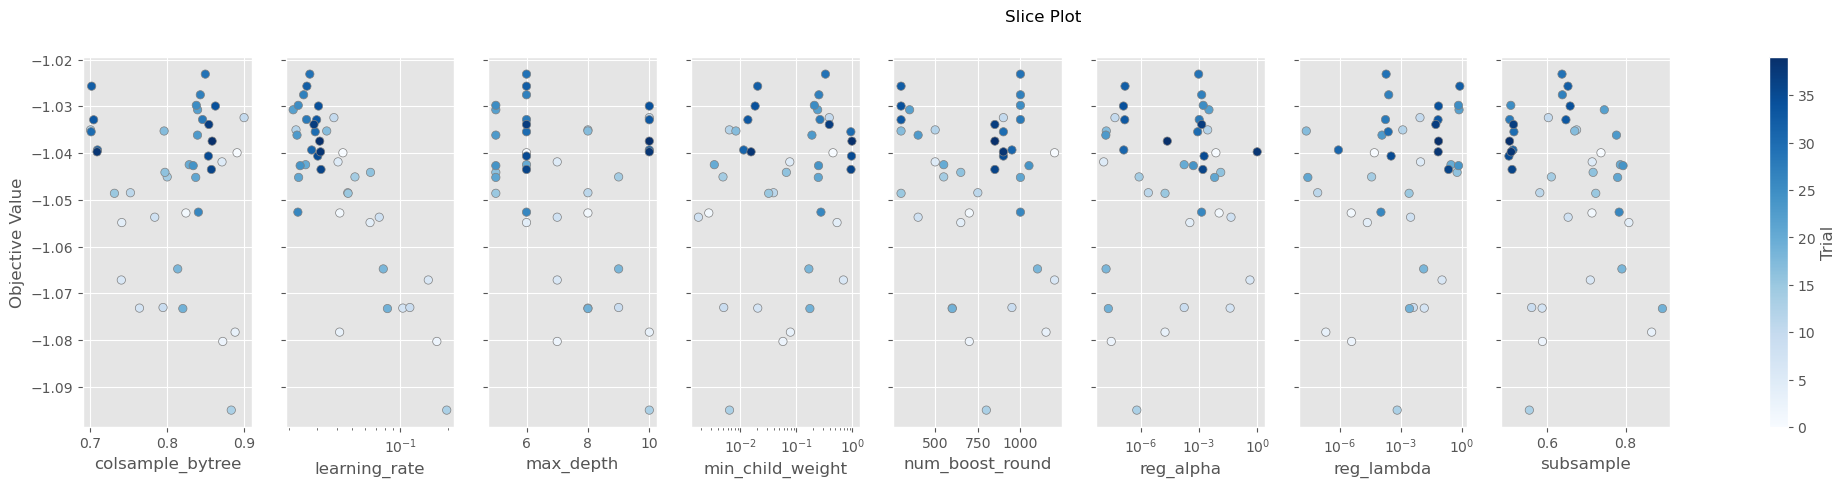

In [17]:
ax  = plot_slice(best_study)       # <- Axes
plt.show()                         # show in notebook / script

In [18]:
dall   = xgb.DMatrix(X, label=y)
best_booster = xgb.train(best_params, dall,
                         num_boost_round=best_params["num_boost_round"])
best_booster.save_model(RUN_DIR / "model" / "runtime_xgb_full.json")

/opt/anaconda3/envs/RuntimePerformancePredictionXGBoost/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:15:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [19]:
class BoosterWrapper:
    def __init__(self, booster): self.booster = booster
    def predict(self, X): return self.booster.predict(xgb.DMatrix(X))

best_model = BoosterWrapper(best_booster)


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import xgboost as xgb


def plot_runtime_scatter_xgb(best_param_dict,
                             X, y_log10,
                             n_folds=10,
                             lower=1e-4,  # seconds
                             upper=1e4,
                             figsize=(6, 6), random_state=1234):
    """
    Train‑/test splits an X matrix and log10‑runtime vector, predicts
    cross‑validated runtimes with the supplied XGBoost hyper‑parameters,
    and produces a scatter plot in **seconds** (log–log).
    """

    # cross‑validated predictions (in log space)
    kf          = KFold(n_splits=n_folds, shuffle=True,
                        random_state=random_state)
    y_pred_log  = np.empty_like(y_log10, dtype=float)

    params      = best_param_dict.copy()
    num_round   = params.pop("num_boost_round")

    X_np  = np.asarray(X)
    y_np  = np.asarray(y_log10)

    for train_idx, test_idx in kf.split(X_np):
        dtrain = xgb.DMatrix(X_np[train_idx], label=y_np[train_idx])
        booster = xgb.train(params, dtrain,
                            num_boost_round=num_round,
                            verbose_eval=False)

        dtest = xgb.DMatrix(X_np[test_idx])
        y_pred_log[test_idx] = booster.predict(dtest)

    # convert to seconds
    y_true_sec = 10 ** y_np
    y_pred_sec = 10 ** y_pred_log

    # in‑range vs. clipped points
    inside  = (y_pred_sec >= lower) & (y_pred_sec <= upper)
    outside = ~inside

    # plot

    fig, ax = plt.subplots(figsize=figsize, dpi=150)
    ax.set_prop_cycle(None)
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.scatter(y_true_sec[inside],  y_pred_sec[inside],
               s=18, alpha=0.6, edgecolor="k")
    ax.scatter(y_true_sec[outside],
               np.clip(y_pred_sec[outside], lower, upper),
               s=18, alpha=0.6, edgecolor="k", marker="x", color="tab:blue")

    ax.plot([lower, upper], [lower, upper],
            linestyle="--", linewidth=1.0, color="red")

    ax.set_xlim(lower, upper)
    ax.set_ylim(lower, upper)
    tick_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
    tick_lbls = [fr"$10^{{{int(np.log10(t))}}}$" for t in tick_vals]
    ax.set_xticks(tick_vals, tick_lbls)
    ax.set_yticks(tick_vals, tick_lbls)

    ax.set_xlabel("true runtime (s)")
    ax.set_ylabel("predicted runtime (s)")
    ax.set_title(f"XGBoost (Hyp. Opt)")
    ax.grid(which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    return fig, ax

/var/folders/38/bs3vdv8j2rgdlt3y8hp6jm_00000gn/T/ipykernel_2655/3227285866.py:70: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(y_true_sec[outside],


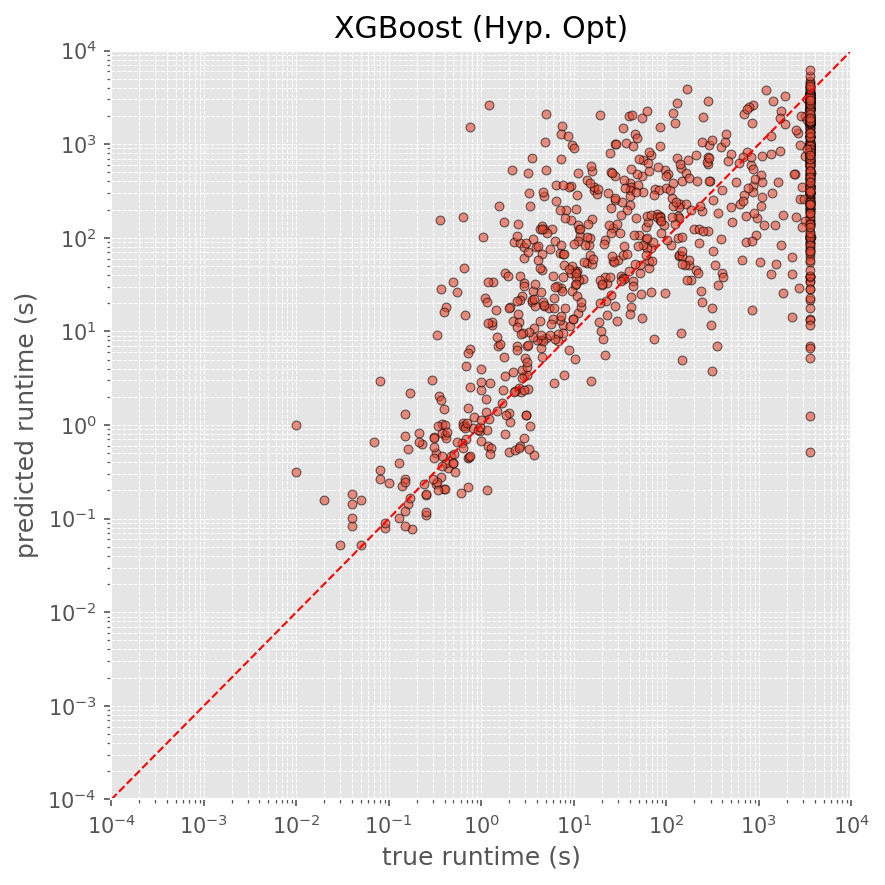

In [21]:
fig, ax = plot_runtime_scatter_xgb(best_params, X, y, n_folds=10)
plt.show()

In [ ]:
metrics_summary = {
    "rmse_outer_mean": float(np.mean(rmse_outer)) if len(rmse_outer) else None,
    "rmse_outer_std":  float(np.std(rmse_outer))  if len(rmse_outer) else None,
    "cc_outer_mean":   float(np.mean(ccs_outer))  if len(ccs_outer) else None,
    "cc_outer_std":    float(np.std(ccs_outer))   if len(ccs_outer) else None,
    "rmse_outer":      [float(v) for v in rmse_outer],
    "ccs_outer":       [float(v) for v in ccs_outer],
    "best_fold_idx":   int(best_fold_idx) if best_fold_idx is not None else None,
    "best_overall_rmse": float(best_overall_rmse) if np.isfinite(best_overall_rmse) else None,
}
save_metrics("nested_cv_summary", metrics_summary)

if best_params is None:
    raise RuntimeError("best_params is None — ensure the nested-CV loop completed successfully.")
save_metrics("best_params", {k: (float(v) if isinstance(v, np.floating) else v)
                             for k, v in best_params.items()})

params_final = best_params.copy()
num_round    = int(params_final.pop("num_boost_round"))

feature_names = list(X.columns) if hasattr(X, "columns") else None
dall = xgb.DMatrix(X, label=y, feature_names=feature_names)

final_booster = xgb.train(
    params=params_final,
    dtrain=dall,
    num_boost_round=num_round,
    verbose_eval=False,
)

save_model(final_booster, name="xgb-runtime-miplib-optimized-final")
save_optuna(best_booster)